# Análise do Classificador KFold e conjunto de dados FaQuAD

Realiza a análise do classificador binário kfold utilizando BERT no conjunto de dados FaQuAD que alcançou a melhor acurácia.

Utiliza os arquivos resultantes da classificação kfold de `X` documentos perturbados e `Y` top K predições com a melhor acurácia de classificação.

Classes:
- 1 - Documento original
- 0 - Documento perturbado

----------------------------

**Link biblioteca Transformers:**
https://github.com/huggingface/transformers

**Artigo original BERT:**
https://arxiv.org/pdf/1506.06724.pdf


# 1 Preparação do ambiente

Preparação do ambiente para execução do script.

## 1.1 Tempo inicial de processamento

In [1]:
# Import das bibliotecas.
import time
import datetime

# Marca o tempo de início do processamento
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [2]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [3]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [4]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [5]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [6]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [7]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [8]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempo_arredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempo_arredondado))    

Calcula a média de uma lista tempo string no formato hh:mm:ss.

In [9]:
# Import das bibliotecas.
from cmath import rect, phase
from math import radians, degrees
  
def mediaAngulo(deg):
    return degrees(phase(sum(rect(1, radians(d)) for d in deg)/len(deg)))
 
def mediaTempo(tempos):
    '''
    Calcula a média de uma lista de tempo string no formato hh:mm:ss
    '''
    t = (tempo.split(':') for tempo in tempos)
    # Converte para segundos
    segundos = ((float(s) + int(m) * 60 + int(h) * 3600) for h, m, s in t)
    # Verifica se deu algum dia
    dia = 24 * 60 * 60
    # Converte para angulos
    para_angulos = [s * 360. / dia for s in segundos]
    # Calcula a média dos angulos
    media_como_angulo = mediaAngulo(para_angulos)
    media_segundos = media_como_angulo * dia / 360.
    if media_segundos < 0:
        media_segundos += dia
    # Recupera as horas e os minutos  
    h, m = divmod(media_segundos, 3600)
    # Recupera os minutos e os segundos
    m, s = divmod(m, 60)    
    return '{:02d}:{:02d}:{:02d}'.format(int(h), int(m), int(s))

Calcula a soma de uma lista de tempo string no formato hh:mm:ss

In [10]:
def somaTempo(tempos):
    '''
    Calcula a soma de uma lista de tempo string no formato hh:mm:ss
    '''
    t = (tempo.split(':') for tempo in tempos)
    # Converte para segundos
    segundos = ((float(s) + int(m) * 60 + int(h) * 3600) for h, m, s in t)
    # Soma os segundos
    soma_segundos = sum([s * 1. for s in segundos])
    # Recupera as horas e os minutos   
    h, m = divmod(soma_segundos, 3600)
    # Recupera os minutos e os segundos
    m, s = divmod(m, 60)    
    return '{:02d}:{:02d}:{:02d}'.format(int(h), int(m), int(s))

Classe(ModeloArgumentosMedida) de definição dos parâmetros do modelo para medida

In [11]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={'help': 'max seq len'},
    )    
    pretrained_model_name_or_path: str = field(
        default='neuralmind/bert-base-portuguese-cased',
        metadata={'help': 'nome do modelo pré-treinado do BERT.'},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={'help': 'define se o texto do modelo deve ser todo em minúsculo.'},
    )  
    output_attentions: bool = field(
        default=False,
        metadata={'help': 'habilita se o modelo retorna os pesos de atenção.'},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={'help': 'habilita gerar as camadas ocultas do modelo.'},
    )
    use_wandb : bool = field(
        default=True,
        metadata={'help': 'habilita o uso do wandb.'},
    )
    salvar_avaliacao : bool = field(
        default=True,
        metadata={'help': 'habilita o salvamento do resultado da avaliação.'},
    )     
    salvar_medicao : bool = field(
        default=False,
        metadata={'help': 'habilita o salvamento da medicao.'},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={'help': 'habilita o carragamento de mcl ajustado.'},
    )
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos a serem perturbados a partir do original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de palavras a serem recuperadas mais próximas da máscara."},
    )
    estrategia_medida: int = field(
        default=0, # 0 - MEAN estratégia média / 1 - MAX  estratégia maior
        metadata={'help': 'Estratégia de cálculo da médida dos embeddings.'},
    )
    filtro_palavra: int = field(
        default=0, # 0 - Considera todas as palavras das sentenças / 1 - Desconsidera as stopwords / 2 - Considera somente as palavras substantivas
        metadata={'help': 'Define o filtro de palavras das sentenças para gerar os embeddings.'},
    )

Classe(ModeloArgumentosClassificacao) de definição dos parâmetros do modelo para classificação

In [12]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosClassificacao:
    '''
    Classe(ModeloArgumentosClassificacao) de definição dos parâmetros do modelo BERT para a classificação de coerência.
    '''
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )    
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )
    num_labels: int = field(
        default=2,
        metadata={"help": "número de rótulos a serem classificados."},
    )
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )
    optimizer: str = field(
        default="AdamW",
        metadata={"help": "otimizador do modelo."},
    )
    use_wandb : bool = field(
        default=True,
        metadata={"help": "habilita o uso do wandb."},
    )
    salvar_modelo_wandb : bool = field(
        default=True,
        metadata={"help": "habilita o salvamento do modelo no wandb."},
    )
    salvar_modelo : bool = field(
        default=False,
        metadata={"help": "habilita o salvamento do modelo."},
    )
    salvar_avaliacao : bool = field(
        default=True,
        metadata={"help": "habilita o salvamento do resultado da avaliação."},
    )     
    salvar_classificacao : bool = field(
        default=False,
        metadata={"help": "habilita o salvamento da classificação."},
    )
    usar_mcl_ajustado: bool = field(
        default=False,
        metadata={'help': 'habilita o carragamento de mcl ajustado.'},
    )    
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos perturbados comparados com o seu original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de previsões de palavras recuperadas mais próximas da máscara."},
    ) 
    epoca: int = field(
        default="1",
        metadata={"help": "Época a ser avaliada."},
    )    
    fold: int = field(
        default="1",
        metadata={"help": "Fold a ser avaliado."},
    )    

Biblioteca de limpeza de tela


In [13]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [14]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4 Identificando o ambiente Colab

In [15]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [16]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [17]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def getDeviceGPU():
    """
    Retorna um dispositivo de GPU se disponível ou CPU.
    
    Retorno:
    `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [18]:
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Conecta o modelo ao device

In [19]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def conectaGPU(model, device):
    """
      Conecta um modelo BERT a GPU.

      Parâmetros:
        `model` - Um modelo BERT carregado.       
        `device` - Um device de GPU.     
    
      Retorno:
        `model` - Um objeto model BERT conectado a GPU.     
    """
    # Associa a GPU ao modelo.
    model.to(device)

    # Se existe GPU disponível.
    if torch.cuda.is_available():    
        # Diga ao pytorch para rodar este modelo na GPU.
        logging.info("Pytorch rodando o modelo na GPU.")
        model.cuda()
        
    else:
        logging.info("Pytorch rodando sem GPU.")

    return model

Memória

Memória disponível no ambiente

In [20]:
# Import das bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [21]:
# Import das bibliotecas.
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")

Mounted at /content/drive


## 1.7 Instalação do spaCy

https://spacy.io/

Modelos do spaCy para português:
https://spacy.io/models/pt

In [22]:
# Instala o spacy
!pip install -U pip setuptools wheel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 33.0 MB/s 
     |████████████████████████████████| 1.2 MB 61.5 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
numba 0.56.2 requires setuptools<60, but you have setuptools 65.4.1 which is incompatible.


In [23]:
# Instala uma versão específica
!pip install -U spacy==3.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.6/660.6 kB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 121.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.9.2
    Uninstalling pydantic-1.9.2:
      Successfully uninstalled pydantic-1.9.2
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.0
    Uninstalling thinc-8.1.0:
      Successfully uninstalled thinc-8.1.0
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.1
    Uninstalling spacy-3.4.1:
      Successfully uninstalled spacy-3.4.1
ERROR: p

# 2 Parametrização

## Gerais

In [24]:
# Nome base das saidas do projeto C = Cris, SB = SmartBatch, KF = KFold
NOME_BASE_SAIDA = "AjusteFinoFaquad_C_SB_KF_v1"

## Específicos

Parâmetros do modelo

In [25]:
# Definição dos parâmetros do Modelo
model_args = ModeloArgumentosMedida(     
    max_seq_len = 512,    
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-large-portuguese-cased/bert-large-portuguese-cased_pytorch_checkpoint.zip",
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-base-portuguese-cased/bert-base-portuguese-cased_pytorch_checkpoint.zip",
    pretrained_model_name_or_path = "neuralmind/bert-large-portuguese-cased",
    #pretrained_model_name_or_path = "neuralmind/bert-base-portuguese-cased",    
    #pretrained_model_name_or_path = "bert-base-multilingual-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-uncased",
    modelo_spacy = "pt_core_news_lg",
    #modelo_spacy = "pt_core_news_md",
    #modelo_spacy = "pt_core_news_sm",
    versao_modelo_spacy = "3.2.0",
    do_lower_case = False,  # default True
    output_attentions = False,  # default False
    output_hidden_states = True, # default False
    use_wandb = True,    
    salvar_medicao = True, #Salva o resultado da medição
    salvar_avaliacao = True, # Salva o resultado da avaliação das medições
    usar_mcl_ajustado = False, # Especifica se deve ser carregado um MCL ajustado ou pré-treinado. Necessário especificar o tipo do modelo em pretrained_model_name_or_path. 
    estrategia_medida = 0, # Atributo usado para os logs do wandb. 0 - MEAN estratégia média / 1 - MAX  estratégia maior
    filtro_palavra = 0, # Atributo usado para os logs do wandb. 0 - Considera todas as palavras das sentenças / 1 - Desconsidera as stopwords / 2 - Considera somente as palavras substantivas
)

## Nome do diretório dos arquivos de dados

In [26]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "FAQUAD"

## Define o caminho para os arquivos de dados

In [27]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

# 3 spaCy

## 3.1 Download arquivo modelo

https://spacy.io/models/pt

### Função download modelo spaCy

In [28]:
def downloadSpacy(model_args):
    """
      Realiza o download do arquivo do modelo para o diretório corrente.
    
      Parâmetros:
        `model_args` - Objeto com os argumentos do modelo.       
    """
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
        
    # Nome arquivo spacy
    ARQUIVO_MODELO_SPACY = model_args.modelo_spacy
    # Versão spaCy
    VERSAO_SPACY = "-" + model_args.versao_modelo_spacy
    # Nome arquivo compactado
    NOME_ARQUIVO_MODELO_COMPACTADO = ARQUIVO_MODELO_SPACY + VERSAO_SPACY + ".tar.gz"
    
    # Url do arquivo
    URL_ARQUIVO_MODELO_COMPACTADO = "https://github.com/explosion/spacy-models/releases/download/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY + "/" + NOME_ARQUIVO_MODELO_COMPACTADO

    # Realiza o download do arquivo do modelo
    logging.info("Download do arquivo do modelo do spaCy.")
    downloadArquivo(URL_ARQUIVO_MODELO_COMPACTADO, DIRETORIO_COHEBERT + "/" + NOME_ARQUIVO_MODELO_COMPACTADO)

## 3.2 Descompacta o arquivo do modelo

### Função descompacta modelo spaCy

In [29]:
# Import das bibliotecas.
import tarfile # Biblioteca de descompactação

def descompactaSpacy(model_args):
    """
      Descompacta o arquivo do modelo.
    
      Parâmetros:
        `model_args` - Objeto com os argumentos do modelo.       
    """
    
    # Verifica se existe o diretório base do cohebert e retorna o nome do diretório
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Nome arquivo spacy
    ARQUIVO_MODELO_SPACY = model_args.modelo_spacy
    # Versão spaCy
    VERSAO_SPACY = "-" + model_args.versao_modelo_spacy
    
    # Nome do arquivo a ser descompactado
    NOME_ARQUIVO_MODELO_COMPACTADO = DIRETORIO_COHEBERT + "/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY + ".tar.gz"
    
    logging.info("Descompactando o arquivo do modelo do spaCy.")
    arquivoTar = tarfile.open(NOME_ARQUIVO_MODELO_COMPACTADO, "r:gz")    
    arquivoTar.extractall(DIRETORIO_COHEBERT)    
    arquivoTar.close()
    
    # Apaga o arquivo compactado
    if os.path.isfile(NOME_ARQUIVO_MODELO_COMPACTADO):        
        os.remove(NOME_ARQUIVO_MODELO_COMPACTADO)

## 3.3 Carrega o modelo

### Função carrega modelo spaCy

In [30]:
# Import das bibliotecas.
import spacy # Biblioteca do spaCy

def carregaSpacy(model_args):
    """
    Realiza o carregamento do Spacy.
    
    Parâmetros:
      `model_args` - Objeto com os argumentos do modelo.           
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
                  
    # Nome arquivo spacy
    ARQUIVO_MODELO_SPACY = model_args.modelo_spacy
    # Versão spaCy
    VERSAO_SPACY = "-" + model_args.versao_modelo_spacy
    # Caminho raoz do modelo do spaCy
    DIRETORIO_MODELO_SPACY =  DIRETORIO_COHEBERT + "/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY

    # Verifica se o diretório existe
    if os.path.exists(DIRETORIO_MODELO_SPACY) == False:
        # Realiza o download do arquivo modelo do spaCy
        downloadSpacy(model_args)
        # Descompacta o spaCy
        descompactaSpacy(model_args)

    # Diretório completo do spaCy
    DIRETORIO_MODELO_SPACY = DIRETORIO_COHEBERT + "/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY + "/" + ARQUIVO_MODELO_SPACY + "/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY + "/"

    # Carrega o spaCy. Necessário somente "tagger" para encontrar os substantivos
    nlp = spacy.load(DIRETORIO_MODELO_SPACY)
    logging.info("spaCy carregado.")

    # Retorna o spacy carregado
    return nlp 

### Carrega o modelo spaCy


In [31]:
# Carrega o modelo spaCy
nlp = carregaSpacy(model_args)

INFO:root:Diretório Cohebert criado: FAQUAD
INFO:root:Download do arquivo do modelo do spaCy.
INFO:root:Download do arquivo: FAQUAD/pt_core_news_lg-3.2.0.tar.gz.


  0%|          | 0.00/577M [00:00<?, ?B/s]

INFO:root:Descompactando o arquivo do modelo do spaCy.
INFO:root:spaCy carregado.


## 3.4 Funções auxiliares spaCy

### getStopwords

Recupera as stopwords do spaCy

In [32]:
def getStopwords(nlp):
    """
      Recupera as stop words do nlp(Spacy).
    
      Parâmetros:
        `nlp` - Um modelo spaCy carregado.           
    """
    
    spacy_stopwords = nlp.Defaults.stop_words

    return spacy_stopwords 

Lista dos stopwords

In [33]:
logging.info("Quantidade de stopwords: {}.".format(len(getStopwords(nlp))))

print(getStopwords(nlp))

INFO:root:Quantidade de stopwords: 416.


{'usar', 'neste', 'naquela', 'bem', 'nuns', 'todos', 'meus', 'tanta', 'três', 'algo', 'põe', 'sistema', 'ontem', 'apontar', 'pelo', 'nosso', 'és', 'da', 'disso', 'caminho', 'tal', 'daquela', 'ver', 'estivemos', 'fazia', 'de', 'ser', 'que', 'tentar', 'porém', 'tive', 'apoio', 'numa', 'cedo', 'vinda', 'nem', 'num', 'nossos', 'querem', 'quinto', 'pela', 'maior', 'baixo', 'vêm', 'veja', 'somos', 'números', 'aquela', 'todo', 'lugar', 'seus', 'embora', 'deve', 'posição', 'eventual', 'muito', 'te', 'cuja', 'inclusive', 'nós', 'aquele', 'posso', 'catorze', 'elas', 'fim', 'foste', 'podem', 'estado', 'geral', 'demais', 'estas', 'esteve', 'somente', 'vários', 'apenas', 'teu', 'à', 'deverá', 'dar', 'entre', 'sei', 'eu', 'segundo', 'dez', 'forma', 'certamente', 'vinte', 'irá', 'quem', 'saber', 'oitavo', 'sem', 'qualquer', 'próprio', 'menor', 'com', 'me', 'lhe', 'máximo', 'falta', 'sim', 'as', 'o', 'qual', 'você', 'esta', 'quero', 'ter', 'vocês', 'coisa', 'vem', 'final', 'grande', 'tua', 'poder', 'd

### getVerbos
Localiza os verbos da sentença

In [34]:
# Import das bibliotecas.
import spacy   
from spacy.util import filter_spans
from spacy.matcher import Matcher

# (verbo normal como auxilar ou auxilar) + vários verbos auxiliares +verbo principal ou verbo auxiliar
gramaticav1 =  [
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["aux","aux:pass"]}},  #verbo auxiliar                                  
                {"POS": "VERB", "OP": "?", "DEP": {"IN": ["ROOT","aux","xcomp","aux:pass"]}},  #verbo normal como auxiliar
                {"POS": "AUX", "OP": "*", "DEP": {"IN": ["aux","xcomp","aux:pass"]}},  #verbo auxiliar   
                {"POS": "VERB", "OP": "+"}, #verbo principal
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["cop","aux","xcomp","aux:pass"]}},  #verbo auxiliar
               ] 

# verbo auxiliar + verbo normal como auxiliar + conjunção com preposição + verbo
gramaticav2 =  [               
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["aux","aux:pass"]}},  #verbo auxiliar                   
                {"POS": "VERB", "OP": "+", "DEP": {"IN": ["ROOT"]}},  #verbo principal       
                {"POS": "SCONJ", "OP": "+", "DEP": {"IN": ["mark"]}}, #conjunção com preposição
                {"POS": "VERB", "OP": "+", "DEP": {"IN": ["xcomp"]}}, #verbo normal como complementar
               ] 

#Somente verbos auxiliares
gramaticav3 =  [
                {"POS": "AUX", "OP": "?"},  #Verbos auxiliar 
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["cop"]}},  #Verbos auxiliar de ligação (AUX+(cop))
                {"POS": "ADJ", "OP": "+", "DEP": {"IN": ["ROOT"]}}, 
                {"POS": "AUX", "OP": "?"}  #Verbos auxiliar 
               ] 

matcherv = Matcher(nlp.vocab)
         
matcherv.add("frase verbal", [gramaticav1])
matcherv.add("frase verbal", [gramaticav2])
matcherv.add("frase verbal", [gramaticav3])

#Retorna a Frase Verbal
def getVerbos(periodo):    
  #Processa o período
  doc1 = nlp(periodo.text)
  
  # Chama o mather para encontrar o padrão
  matches = matcherv(doc1)

  padrao = [doc1[start:end] for _, start, end in matches]

  #elimina as repetições e sobreposições
  #return filter_spans(padrao)
  lista1 = filter_spans(padrao)

  # Converte os itens em string
  lista2 = []
  for x in lista1:
      lista2.append(str(x))
  
  return lista2

### getDicPOSQtde

Conta as POS Tagging de uma sentença

In [35]:
def getDicPOSQtde(sentenca):

    # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Retorna inteiros que mapeiam para classes gramaticais
  conta_dicionarios = doc.count_by(spacy.attrs.IDS["POS"])

  # Dicionário com as tags e quantidades
  novodic = dict()
  
  for pos, qtde in conta_dicionarios.items():
    classe_gramatical = doc.vocab[pos].text
    novodic[classe_gramatical] = qtde

  return novodic

In [36]:
def getDicTodasPOSQtde(sentenca):

    # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Retorna inteiros que mapeiam para classes gramaticais
  conta_dicionarios = doc.count_by(spacy.attrs.IDS["POS"])

  # Dicionário com as tags e quantidades    
  novodic = {"PRON":0, "VERB":0, "PUNCT":0, "DET":0, "NOUN":0, "AUX":0, "CCONJ":0, "ADP":0, "PROPN":0, "ADJ":0, "ADV":0, "NUM":0, "SCONJ":0, "SYM":0, "SPACE":0, "INTJ":0, "X": 0}
    
  for pos, qtde in conta_dicionarios.items():
    classe_gramatical = doc.vocab[pos].text
    novodic[classe_gramatical] = qtde

  return novodic

### getDicTodasPOSQtde

Conta as POS Tagging de uma sentença

In [37]:
def getDicTodasPOSQtde(lista):

  # Dicionário com as tags e quantidades
  conjunto = {"PRON":0, "VERB":0, "PUNCT":0, "DET":0, "NOUN":0, "AUX":0, "CCONJ":0, "ADP":0, "PROPN":0, "ADJ":0, "ADV":0, "NUM":0, "SCONJ":0, "SYM":0, "SPACE":0, "INTJ": 0}

  for x in lista:
    valor = conjunto.get(x)
    if valor != None:
      conjunto[x] = valor + 1
    else:
      conjunto[x] = 1

  return conjunto

### getSomaDic

Soma os valores de dicionários com as mesmas chaves.

In [38]:
from collections import Counter
from functools import reduce

def atualizaValor(a,b):
    a.update(b)
    return a

def getSomaDic(lista):
    
  # Soma os dicionários da lista
  novodic = reduce(atualizaValor, (Counter(dict(x)) for x in lista))
 
  return novodic

### getTokensSentenca

Retorna a lista de tokens da sentenca.

In [39]:
def getTokensSentenca(sentenca):

    # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Lista dos tokens
  lista = []

  # Percorre a sentença adicionando os tokens
  for token in doc:    
    lista.append(token.text)

  return lista

### getPOSTokensSentenca

Retorna a lista das POS-Tagging dos tokens da sentenca.

In [40]:
def getPOSTokensSentenca(sentenca):

  # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Lista dos tokens
  lista = []

  # Percorre a sentença adicionando os tokens
  for token in doc:    
    lista.append(token.pos_)

  return lista

### getListaTokensPOSSentenca

Retorna duas listas uma com os tokens e a outra com a POS-Tagging dos tokens da sentenca.

In [41]:
def getListaTokensPOSSentenca(sentenca):
  # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Lista dos tokens
  listatokens = []
  listapos = []

  # Percorre a sentença adicionando os tokens e as POS
  for token in doc:    
    listatokens.append(token.text)
    listapos.append(token.pos_)
    
  return listatokens, listapos

### Tradução das tags

Tags de palavras universal

https://universaldependencies.org/u/pos/

Detalhes das tags em português:
http://www.dbd.puc-rio.br/pergamum/tesesabertas/1412298_2016_completo.pdf

In [42]:
#dicionário que contêm pos tag universal e suas explicações
palavra_universal_dict = {
  "X"    : "Outro",
  "VERB" : "Verbo ",
  "SYM"  : "Símbolo",
  "CONJ" : "Conjunção",
  "SCONJ": "Conjunção subordinativa",
  "PUNCT": "Pontuação",
  "PROPN": "Nome próprio",
  "PRON" : "Pronome substativo",
  "PART" : "Partícula, morfemas livres",
  "NUM"  : "Numeral",
  "NOUN" : "Substantivo",
  "INTJ" : "Interjeição",
  "DET"  : "Determinante, Artigo e pronomes adjetivos",
  "CCONJ": "Conjunção coordenativa",
  "AUX"  : "Verbo auxiliar",
  "ADV"  : "Advérbio",
  "ADP"  : "Preposição",
  "ADJ"  : "Adjetivo"
}
  
#Explica a POS
def getPOSPalavraUniversalTraduzido(palavra):
  if palavra in palavra_universal_dict.keys():
      traduzido = palavra_universal_dict[palavra]
  else:
      traduzido = "NA" 
  return traduzido

### getSentencaSemStopWord

Retorna uma lista dos tokens sem as stopwords.

In [43]:
def getSentencaSemStopWord(sentenca, stopwords):

  # Lista dos tokens
  lista = []

  # Percorre os tokens da sentença
  for i, token in enumerate(sentenca):

    # Verifica se o token é uma stopword
    if token.lower() not in stopwords:
      lista.append(token)

  # Retorna o documento
  return lista

### getSentencaSalientePOS

Retorna uma lista das palavras do tipo especificado.

In [44]:
def getSentencaSalientePOS(sentenca, pos, classe_saliente=["NOUN"]):
  
  # Lista dos tokens
  lista = []

  # Percorre a sentença
  for i, token in enumerate(sentenca):

    # Verifica se o token é do tipo especificado
    if pos[i] in classe_saliente:
      lista.append(token)

  # Retorna o documento
  return lista

###removeStopWords

Remove as stopwords de um documento ou senteça.

In [45]:
def removeStopWord(documento, stopwords):
  
  # Remoção das stopwords do documento
  documentoSemStopwords = [palavra for palavra in documento.split() if palavra.lower() not in stopwords]

  # Concatena o documento sem os stopwords
  documento_limpo = " ".join(documentoSemStopwords)

  # Retorna o documento
  return documento_limpo

# 4 Resultado do Classificador Binário usando o Método Kfold

## 4.1 Carrega o resultado e parâmetros da melhor classificação

### 4.1.1 Função que encontra a melhor classificação

In [46]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosClassificacaoKFold(DIRETORIO_COHEBERT, 
                                    _DOCUMENTOS_PERTURBADOS, 
                                    _TOP_K_PREDICAO):
  
  # Numero de Folds
  KFOLDS = 10

  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = _DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = _TOP_K_PREDICAO

  # MCL a serem avaliados
  #MODELO_BERT = ['_BERTimbau','_BERTmultilingual']
  MODELO_BERT = ['_BERTimbau']

  #TAMANHO_BERT = ['_base','_large']
  TAMANHO_BERT = ['_large']
  
  # Taxa de aprendizagem do nome do arquivo
  TAXAS_DE_APRENDIZAGEM = [1, 2, 3, 4, 5]

  # Tamanho dos lotes
  TAMANHO_LOTE = [16, 32]

  # Salva resultados intermediários
  EPOCA = [2, 3, 4]

  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_classificacao_palavra/kfold/Avaliacao/"  

  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0
  MELHOR_TAXAS_DE_APRENDIZAGEM = 0
  MELHOR_TAMANHO_LOTE = 0
  MELHOR_EPOCA_EXECUCA = 0
  MELHOR_ACURACIA = 0
  MELHOR_TEMPO = 0

  lista_resultados = []

  lista_tempo_total = []  
  
  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    for modelo in MODELO_BERT:    
      for tamanho in TAMANHO_BERT:
        if modelo != '_BERTmultilingual' or tamanho != '_large':                  
          for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
            for top_k_predicao in TOP_K_PREDICAO: 
              if documentos_perturbados ==  top_k_predicao:
                DIRETORIO_AVALIACAO_PK = DIRETORIO_AVALIACAO + "P_" + str(documentos_perturbados) + "_K_" + str(top_k_predicao) + "/"              
                # Verifica se o diretório dos resultados existe.
                if os.path.exists(DIRETORIO_AVALIACAO_PK):
                  arquivos = os.listdir(DIRETORIO_AVALIACAO_PK) 
                  conta_regR = 0
                  for lote in TAMANHO_LOTE:
                    for taxa_de_aprendizagem in TAXAS_DE_APRENDIZAGEM:                      
                      for epoca in EPOCA:  
                          # Acumuladores.
                          soma_acuracia = 0
                          lista_tempo = []
                          conta_folds = 0 
                          conta_reg = 0
                          
                          for i in range(len(arquivos)):
                            for fold in range(1,11):
                              # Filtra o nome do arquivo a ser avaliado                                                     
                              if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                                    and (("_K_" + str(top_k_predicao)+"_") in arquivos[i]) 
                                    and (("_b_" + str(lote)) in arquivos[i]) 
                                    and (modelo in arquivos[i]) 
                                    and (tamanho in arquivos[i]) 
                                    and (('_f' + str(fold) + '_') in arquivos[i]) 
                                    and (("e_" + str(epoca)) in arquivos[i]) 
                                    and (("lr_" + str(taxa_de_aprendizagem)) in arquivos[i])):                           

                                  NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO_PK + arquivos[i]                              
                                  # Verifica se o arquivo existe.
                                  if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                                    # Carrega os dados do arquivo  
                                    dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                        
                                    # Conta o número de folds.
                                    conta_folds = conta_folds + 1
                                    
                                    # Mostra os dados do teste do fold.
                                    for index, linha in dados.iterrows():        
                                      # Cálculo das estatísticas
                                      acc = (linha['vp']+linha['vn'])/(linha['vp']+linha['vn']+linha['fp']+linha['fn'])                         
                                      #print('{};{};{};{:.8f};{}'.format(fold, index, arquivos[i],acc,linha['tempo']))
                                      # Guarda o tempo.
                                      lista_tempo.append(str(linha['tempo']))
                                      # Conta o número de registros.
                                      conta_reg = conta_reg + 1
                                      
                                    # Realiza a soma da acurácia do arquivo.
                                    soma_acuracia = soma_acuracia + dados['acuracia'].sum()
                                          
                          if conta_folds != 0:
                            # Calcula a média.                          
                            media_acuracia = soma_acuracia/conta_reg

                            # Guarda os resultados de todos os folds  
                            lista_resultados.append([documentos_perturbados,top_k_predicao,taxa_de_aprendizagem,lote,epoca, media_acuracia, somaTempo(lista_tempo)])
                            
                            if media_acuracia > MELHOR_ACURACIA:
                                MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                                MELHOR_TOP_K_PREDICAO = top_k_predicao
                                MELHOR_TAXAS_DE_APRENDIZAGEM = taxa_de_aprendizagem
                                MELHOR_TAMANHO_LOTE = lote
                                MELHOR_EPOCA_EXECUCAO = epoca
                                MELHOR_ACURACIA = media_acuracia
                                MELHOR_TEMPO = somaTempo(lista_tempo)
                        
                          else:                          
                              print('Nenhum arquivo de avaliação encontrado')
                  
                else:
                  print('Diretório ' + 'P_' + str(documentos_perturbados) + '_K_' + str(top_k_predicao) + ' não encontrado')                        
    
    # Retorno do melhor valor
    lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[5], reverse=True)
    return MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_TAXAS_DE_APRENDIZAGEM, MELHOR_TAMANHO_LOTE, MELHOR_EPOCA_EXECUCAO, MELHOR_ACURACIA, MELHOR_TEMPO, lista_resultado_ordenado
  else:
    print('Diretório com os resultados não encontrado')

Recupera os melhores resultados

In [47]:
DOCUMENTOS_PERTURBADOS = [1, 20, 100]
TOP_K_PREDICAO = [1, 20, 100]

# Recupera os melhores parâmetros
MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_TAXAS_DE_APRENDIZAGEM, MELHOR_TAMANHO_LOTE, MELHOR_EPOCA_EXECUCAO, MELHOR_ACURACIA, MELHOR_TEMPO, lista_resultados = getResultadosClassificacaoKFold(DIRETORIO_COHEBERT, DOCUMENTOS_PERTURBADOS, TOP_K_PREDICAO)

In [48]:
print("Parâmetros da melhor acurácia do classificador")
print("\n  Documentos Perturbados:", MELHOR_DOCUMENTOS_PERTURBADOS, 
      "\n  Top k predição        :", MELHOR_TOP_K_PREDICAO, 
      "\n  Taxa de aprendizagem  :", MELHOR_TAXAS_DE_APRENDIZAGEM, 
      "\n  Lote                  :", MELHOR_TAMANHO_LOTE, 
      "\n  Epoca execução        :", MELHOR_EPOCA_EXECUCAO, 
      "\n  Acurácia              :", MELHOR_ACURACIA, 
      "\n  Tempo execução        :", MELHOR_TEMPO)

print("\nLista das acurácias ranqueadas")
for i, linha in enumerate(lista_resultados):
    print((i+1),"=", linha)

Parâmetros da melhor acurácia do classificador

  Documentos Perturbados: 100 
  Top k predição        : 100 
  Taxa de aprendizagem  : 1 
  Lote                  : 16 
  Epoca execução        : 3 
  Acurácia              : 0.9876333333333334 
  Tempo execução        : 19:59:18

Lista das acurácias ranqueadas
1 = [100, 100, 1, 16, 3, 0.9876333333333334, '19:59:18']
2 = [100, 100, 1, 16, 4, 0.9872444444444446, '30:23:41']
3 = [100, 100, 1, 32, 4, 0.9864777777777778, '16:35:32']
4 = [100, 100, 1, 32, 3, 0.9848222222222223, '11:30:05']
5 = [100, 100, 1, 16, 2, 0.9837555555555555, '12:04:05']
6 = [100, 100, 1, 32, 2, 0.9793222222222223, '07:28:05']
7 = [100, 100, 2, 32, 2, 0.9683000000000002, '07:57:27']
8 = [100, 100, 2, 32, 3, 0.9626055555555556, '12:32:58']
9 = [20, 20, 1, 16, 4, 0.9564722222222223, '05:01:57']
10 = [20, 20, 1, 16, 3, 0.9483888888888888, '03:29:29']
11 = [20, 20, 1, 32, 4, 0.9478055555555555, '03:25:20']
12 = [20, 20, 2, 32, 4, 0.941472222222222, '03:32:47']
13 = [20, 2

### Escolhendo um resultado diferente do melhor

In [49]:
# Parametros para melhor de 100
MELHOR_DOCUMENTOS_PERTURBADOS = 100
MELHOR_TOP_K_PREDICAO = 100
MELHOR_TAXAS_DE_APRENDIZAGEM = 1
MELHOR_TAMANHO_LOTE = 16
MELHOR_EPOCA_EXECUCAO = 3
MELHOR_ACURACIA = 0.9876333333333334
MELHOR_TEMPO = '19:59:18'
lista_resultados= []

# Parametros para melhor de 20
# MELHOR_DOCUMENTOS_PERTURBADOS = 20
# MELHOR_TOP_K_PREDICAO = 20
# MELHOR_TAXAS_DE_APRENDIZAGEM = 1
# MELHOR_TAMANHO_LOTE = 16
# MELHOR_EPOCA_EXECUCAO = 4
# MELHOR_ACURACIA =  0.9564722222222223
# MELHOR_TEMPO = '05:01:57'
# lista_resultados= []

#Parametros para melhor de 1
# MELHOR_DOCUMENTOS_PERTURBADOS = 1
# MELHOR_TOP_K_PREDICAO = 1
# MELHOR_TAXAS_DE_APRENDIZAGEM = 2
# MELHOR_TAMANHO_LOTE = 16
# MELHOR_EPOCA_EXECUCAO = 3
# MELHOR_ACURACIA = 0.6488888888888888
# MELHOR_TEMPO = '00:18:54'
# lista_resultados= []

### 4.1.2 Função que carrega e calcula a média da acurácia dos folds


In [50]:
# Import das bibliotecas.
import os
import pandas as pd

def relatorioResultados(DIRETORIO_COHEBERT, 
                        TEXTO_PURO, 
                        _DOCUMENTOS_PERTURBADOS, 
                        _TOP_K_PREDICAO,
                        _TAXAS_DE_APRENDIZAGEM,
                        _TAMANHO_LOTE,
                        _EPOCA_EXECUCAO
                        ):
  
  # Numero de Folds
  KFOLDS = 10

  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = _DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = _TOP_K_PREDICAO

  # MCL a serem avaliados
  #MODELO_BERT = ['_BERTimbau','_BERTmultilingual']
  MODELO_BERT = ['_BERTimbau']

  #TAMANHO_BERT = ['_base','_large']
  TAMANHO_BERT = ['_large']

  # Taxa de aprendizagem do nome do arquivo
  TAXAS_DE_APRENDIZAGEM = _TAXAS_DE_APRENDIZAGEM

  # Tamanho dos lotes
  TAMANHO_LOTE = _TAMANHO_LOTE

  # Salva resultados intermediários
  EPOCA = _EPOCA_EXECUCAO
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_classificacao_palavra/kfold/Avaliacao/"  

  lista_tempo_total = []  
  total_geral_folds = 0
  total_geral_registros = 0
  total_arquivos = (len(MODELO_BERT) * len(TAMANHO_BERT) *
                   len(DOCUMENTOS_PERTURBADOS) *  len(TOP_K_PREDICAO) * 
                   len(TAMANHO_LOTE) * len(EPOCA) * len(TAXAS_DE_APRENDIZAGEM) * KFOLDS)
  #total_arquivos = 400  
  if TEXTO_PURO == False:
    print("total_arquivos =", total_arquivos) 

  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    for modelo in MODELO_BERT:
      for tamanho in TAMANHO_BERT:        
        if modelo != '_BERTmultilingual' or tamanho != '_large':  
          for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
            for top_k_predicao in TOP_K_PREDICAO:        
              if documentos_perturbados ==  top_k_predicao:
                DIRETORIO_AVALIACAO_PK = DIRETORIO_AVALIACAO + "P_" + str(documentos_perturbados) + "_K_" + str(top_k_predicao) + "/"
          
                # Verifica se o diretório dos resultados existe.
                if os.path.exists(DIRETORIO_AVALIACAO_PK):
                  arquivos = os.listdir(DIRETORIO_AVALIACAO_PK) 
                  for lote in TAMANHO_LOTE:
                    for taxa_de_aprendizagem in TAXAS_DE_APRENDIZAGEM:
                      for epoca in EPOCA:                    
                          # Acumuladores.
                          soma_acuracia = 0
                          lista_tempo = []
                          conta_folds = 0 
                          conta_reg = 0
                          if TEXTO_PURO == False:
                            print("\nModelo:", modelo, " Tamanho:", tamanho, " N Doc:",documentos_perturbados,
                                  " Top k:", top_k_predicao, " Lote:", lote, " Taxa Apred.:", taxa_de_aprendizagem, " Época:", epoca)
        
                          for i in range(len(arquivos)):                                    
                            for fold in range(1,11):                                                         
                              if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                                  and (("_K_" + str(top_k_predicao)+"_") in arquivos[i]) 
                                  and (("_b_" + str(lote)) in arquivos[i]) 
                                  and (modelo in arquivos[i]) 
                                  and (tamanho in arquivos[i]) 
                                  and (("_b_" + str(lote)) in arquivos[i]) 
                                  and (('_f' + str(fold) + '_') in arquivos[i]) 
                                  and (("e_" + str(epoca)) in arquivos[i]) 
                                  and (("lr_" + str(taxa_de_aprendizagem)) in arquivos[i])):
                              
                                  NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO_PK + arquivos[i]                              
                                  # Verifica se o arquivo existe.
                                  if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                                    # Carrega os dados do arquivo  
                                    dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                        
                                    # Conta o número de folds.
                                    conta_folds = conta_folds + 1
                                    # Conta o número geral de folds
                                    total_geral_folds = total_geral_folds + 1

                                    # Mostra os dados do teste do fold.
                                    for index, linha in dados.iterrows():        
                                      # Cálculo das estatísticas
                                      acc = (linha['vp']+linha['vn'])/(linha['vp']+linha['vn']+linha['fp']+linha['fn'])                         
                                      print('{};{};{};{};{}'.format(fold, index, arquivos[i],str(acc).replace(".", ","),linha['tempo']))
                                      #print('{};{};{};{:.8f};{}'.format(fold, index, arquivos[i],acc,linha['tempo']))
                                      # Guarda o tempo.
                                      lista_tempo.append(str(linha['tempo']))

                                      # Conta o número de registros.
                                      conta_reg = conta_reg + 1
                                      # Conta o número geral de registros.
                                      total_geral_registros = total_geral_registros + 1

                                    # Realiza a soma da acurácia do arquivo.
                                    soma_acuracia = soma_acuracia + dados['acuracia'].sum()

                          
                          if conta_folds != 0:
                              # Mostra a soma da acurácia . 
                              if TEXTO_PURO == False:
                                print('Total acurácia                                           : {:.8f}'.format(soma_acuracia))
                              # Mostra a quantidade de folds.
                              if TEXTO_PURO == False:
                                print('Quantidade de folds                                      : {}'.format(conta_folds))  
                              # Mostra a quantidade de registros.
                              if TEXTO_PURO == False:
                                print('Quantidade de registros                                  : {}'.format(conta_reg))  
                              # Calcula a média.
                              if TEXTO_PURO == False:
                                media_acuracia = soma_acuracia/conta_reg
                                print('A média da acurácia de {:2d} registros é                    : {:.8f}'.format(conta_reg, media_acuracia))
                                print('O tempo gasto na execução do treinamento {:2d} registros é  : {}'.format(conta_reg, somaTempo(lista_tempo)))
                                print('A média de tempo de execução de {:2d} registros é           : {}\n'.format(conta_reg, mediaTempo(lista_tempo)))
                              
                              if epoca == 4:
                                # Guarda o tempo total
                                lista_tempo_total.append(somaTempo(lista_tempo))
                          else:
                              if TEXTO_PURO == False:
                                print('Nenhum arquivo de avaliação encontrado')
                                      
                else:
                  print('Diretório ' + 'P_' + str(documentos_perturbados) + '_K_' + str(top_k_predicao) + ' não encontrado')
    
  else:
      print('Diretório com os resultados não encontrado')        

Recupera os dados dos melhores resultados

In [51]:
# Diretório do cohebert
DOCUMENTOS_PERTURBADOS = [MELHOR_DOCUMENTOS_PERTURBADOS]
TOP_K_PREDICAO = [MELHOR_TOP_K_PREDICAO]
TAXAS_DE_APRENDIZAGEM = [MELHOR_TAXAS_DE_APRENDIZAGEM]
TAMANHO_LOTE = [MELHOR_TAMANHO_LOTE]
EPOCA_EXECUCAO = [MELHOR_EPOCA_EXECUCAO]
TEXTO_PURO = False

relatorioResultados(DIRETORIO_COHEBERT, 
                    TEXTO_PURO, 
                    DOCUMENTOS_PERTURBADOS, 
                    TOP_K_PREDICAO, 
                    TAXAS_DE_APRENDIZAGEM, 
                    TAMANHO_LOTE, 
                    EPOCA_EXECUCAO)

total_arquivos = 10

Modelo: _BERTimbau  Tamanho: _large  N Doc: 100  Top k: 100  Lote: 16  Taxa Apred.: 1  Época: 3
1;0;AjusteFinoFaquad_C_SB_KF_v1_P_100_K_100_E_4_e_3_lr_1_b_16_16_f1_BERTimbau_large.csv;0,9813888888888889;2:17:36
2;0;AjusteFinoFaquad_C_SB_KF_v1_P_100_K_100_E_4_e_3_lr_1_b_16_16_f2_BERTimbau_large.csv;0,9847222222222223;2:15:12
3;0;AjusteFinoFaquad_C_SB_KF_v1_P_100_K_100_E_4_e_3_lr_1_b_16_16_f3_BERTimbau_large.csv;0,9905555555555555;2:19:25
4;0;AjusteFinoFaquad_C_SB_KF_v1_P_100_K_100_E_4_e_3_lr_1_b_16_16_f4_BERTimbau_large.csv;0,9853888888888889;2:21:57
5;0;AjusteFinoFaquad_C_SB_KF_v1_P_100_K_100_E_4_e_3_lr_1_b_16_16_f5_BERTimbau_large.csv;0,9896111111111111;1:46:02
6;0;AjusteFinoFaquad_C_SB_KF_v1_P_100_K_100_E_4_e_3_lr_1_b_16_16_f6_BERTimbau_large.csv;0,9897777777777778;1:48:26
7;0;AjusteFinoFaquad_C_SB_KF_v1_P_100_K_100_E_4_e_3_lr_1_b_16_16_f7_BERTimbau_large.csv;0,9885555555555555;1:48:49
8;0;AjusteFinoFaquad_C_SB_KF_v1_P_100_K_100_E_4_e_3_lr_1_b_16_16_f8_BERTimbau_

## 4.2 Carregamento dos arquivos de dados originais e perturbados

### 4.2.1 Especifica os nomes dos arquivos de dados



In [52]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"

### 4.2.2 Cria o diretório local para receber os dados

In [53]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Perturbados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório já existe: /content/FAQUAD


### 4.2.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [54]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [55]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

INFO:root:Terminei a descompactação!


### 4.2.4 Carregamento das lista com os dados dos arquivos originais e perturbados

#### Carrega o arquivo dos dados originais e POS

In [56]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO ORIGINAIS: 900.
INFO:root:TERMINADO ORIGINAIS POS: 900.


In [57]:
lista_documentos_originais.sample(5)

id  \
675  47d46519fe4241fcacde161a08cea75a   
11   bc649c8e94fd489b96bc6274af04ca6c   
365  3f79276bb7264eb3add9616a046861c3   
572  76e17beb97654e26a623cc62f2280020   
694  0f6e8e08b08d471184abddbf0604f587   

                                             sentencas  \
675  ['Quais os possíveis tipos de disciplinas disp...   
11   ['O que permite com que profissionais que não ...   
365                  ['Qual o objetivo do Redecomep?']   
572  ['Como é chamado o iniciante na carreira acadê...   
694  ['Quem emite a declaração de realização de mon...   

                                             documento  
675  Quais os possíveis tipos de disciplinas dispen...  
11   O que permite com que profissionais que não po...  
365                      Qual o objetivo do Redecomep?  
572  Como é chamado o iniciante na carreira acadêmi...  
694  Quem emite a declaração de realização de monit...

In [58]:
lista_documentos_originais_pos.sample(5)

id  \
255  71831ba838dd491ba282a072bad4ad0d   
327  ad7f31c0c7c942a4a00c6ab589794583   
701  5fa56370fe8e4793b5a43ba3037cd895   
32   d55d83a33e9343ddad53d78a2d2dac9e   
431  d7f925c95a36489cb71eec33be7ae1ce   

                                         pos_documento  
255  [[['Quem', 'dominava', 'a', 'área', 'de', 'ens...  
327  [[['O', 'que', 'o', 'acadêmico', 'deve', 'faze...  
701  [[['Onde', 'deve', 'ser', 'entregue', 'o', 'pe...  
32   [[['Com', 'o', 'que', 'as', 'atividades', 'com...  
431  [[['Como', 'pode', 'ser', 'requisitada', 'a', ...

#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [59]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

def corrigirTipoDadosColunasOriginais(lista_documentos_originais, lista_documentos_originais_pos):

  # Corrige os tipos dos dados 
  tipos = {"id": str}
  lista_documentos_originais = lista_documentos_originais.astype(tipos)
  lista_documentos_originais_pos = lista_documentos_originais_pos.astype(tipos)

  # Verifica se o tipo da coluna não é list e converte
  lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
  logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

  return lista_documentos_originais, lista_documentos_originais_pos

In [60]:
lista_documentos_originais, lista_documentos_originais_pos = corrigirTipoDadosColunasOriginais(lista_documentos_originais, lista_documentos_originais_pos)

INFO:root:TERMINADO CORREÇÃO ORIGINAIS: 900.
INFO:root:TERMINADO CORREÇÃO ORIGINAIS POS: 900.


#### Criando dados indexados originais

In [61]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_indexado = lista_documentos_originais.set_index(["id"])
lista_documentos_originais_indexado.head()

sentencas  \
id                                                                                    
4918ff59e83343b88c1fd3a204f55a3b  [Como pode ser definido um sistema de informaç...   
fb885a2f0a624520a6586476563715e8      [O que as soluções tecnológicas automatizam?]   
a8d728463e2f4fe792c6c756e0fd14a4  [Por que a preocupação com a coleta, armazenam...   
927902205b9f494881848f7fc065c347  [Qual um componente indispensável nas organiza...   
ee17827309224fa8acfb23a05e2fa853  [Em que se concentram as responsabilidades do ...   

                                                                          documento  
id                                                                                   
4918ff59e83343b88c1fd3a204f55a3b   Como pode ser definido um sistema de informação?  
fb885a2f0a624520a6586476563715e8        O que as soluções tecnológicas automatizam?  
a8d728463e2f4fe792c6c756e0fd14a4  Por que a preocupação com a coleta, armazename...  
927902205b9f494881848f7fc065c347  Qual um componente indispensável nas organizaç...  
ee17827309224fa8acfb23a05e2fa853  Em que se concentram as responsabilidades do a...

In [62]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.set_index(["id"])
lista_documentos_originais_pos_indexado.head()

pos_documento
id                                                                                 
4918ff59e83343b88c1fd3a204f55a3b  [[[Como, pode, ser, definido, um, sistema, de,...
fb885a2f0a624520a6586476563715e8  [[[O, que, as, soluções, tecnológicas, automat...
a8d728463e2f4fe792c6c756e0fd14a4  [[[Por, que, a, preocupação, com, a, coleta, ,...
927902205b9f494881848f7fc065c347  [[[Qual, um, componente, indispensável, nas, o...
ee17827309224fa8acfb23a05e2fa853  [[[Em, que, se, concentram, as, responsabilida...

#### Carrega o arquivo dos dados perturbados e POS

In [63]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO PERTURBADOS: 90000.
INFO:root:TERMINADO PERTURBADOS POS: 90000.


AlgUns csv estão com os nomes das colunas errados

In [64]:
lista_documentos_perturbados = lista_documentos_perturbados.rename(columns={'documentoPerturbado': 'documento_perturbado'})

In [65]:
lista_documentos_perturbados.sample(5)

id  \
67415  6195e07726c44dfdb5db36360e8f6ebd_pert_15   
44624  c648549f960f421fbe4488250e1e84c8_pert_24   
52746  29f13da0db884441a2e7dc9e34f62d4d_pert_46   
57441  4a9d7e7b04f0430b9f82cef937ae6e61_pert_41   
64399  9e9888a80fe84769aa7621bd91d5eb13_pert_99   

                                              perturbado  \
67415  ['O que o coordenador de curso fazer na anális...   
44624  ['Onde se informa as médias de aproveitamento ...   
52746  ['Qual era o foco de mestrados acadêmicos no B...   
57441  ['O que os professors no Reino Unido geralment...   
64399  ['Quem a coordenação de curso designar para el...   

                                    documento_perturbado  \
67415  O que o coordenador de curso fazer na análise ...   
44624  Onde se informa as médias de aproveitamento da...   
52746  Qual era o foco de mestrados acadêmicos no Bra...   
57441  O que os professors no Reino Unido geralmente ...   
64399  Quem a coordenação de curso designar para elab...   

                                               sentencas  
67415  [['O que o coordenador de curso [MASK] na anál...  
44624  [['Onde se [MASK] as médias de aproveitamento ...  
52746  [['Qual era o [MASK] de mestrados acadêmicos n...  
57441  [['O que os professors no Reino Unido geralmen...  
64399  [['Quem a coordenação de curso [MASK] para ela...

In [66]:
lista_documentos_perturbados_pos.sample(5)

id  \
40158  7ecd158bfb17404b83aa9761ade8b1f0_pert_58   
21082  63a1241f10134c59a6f7d6f70f6e043a_pert_82   
38492  83e3da1f287e4628b9b96ec37f549407_pert_92   
74355  96e8ce565bb2431d89c19b2c7734377b_pert_55   
74233  a615e355f5e540839943856a2b730959_pert_33   

                                           pos_documento  
40158  [[['Como', 'foi', 'estabelecer', 'as', 'bolsas...  
21082  [[['Quantas', 'instruções', 'dos', 'programas'...  
38492  [[['Qual', 'era', 'o', 'Ministério', 'do', 'ME...  
74355  [[['O', 'que', 'amplia', 'o', 'uso', 'da', 'TI...  
74233  [[['Por', 'que', 'as', 'aplicações', 'eram', '...

#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [67]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

def corrigirTipoDadosColunasPerturbados(lista_documentos_perturbados, lista_documentos_perturbados_pos):

  # Corrige os tipos dos dados 
  tipos = {"id": str}
  lista_documentos_perturbados = lista_documentos_perturbados.astype(tipos)
  lista_documentos_perturbados_pos = lista_documentos_perturbados_pos.astype(tipos)

  # Verifica se o tipo da coluna não é list e converte
  lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
  lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
  logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

  return lista_documentos_perturbados, lista_documentos_perturbados_pos

In [68]:
lista_documentos_perturbados, lista_documentos_perturbados_pos = corrigirTipoDadosColunasPerturbados(lista_documentos_perturbados, lista_documentos_perturbados_pos)

INFO:root:TERMINADO CORREÇÃO PERTURBADO: 90000.
INFO:root:TERMINADO CORREÇÃO PERTURBADO POS: 90000.


#### Criando dados indexados perturbados

In [69]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.set_index(["id"])
lista_documentos_perturbados_indexado.head()

perturbado  \
id                                                                                           
4918ff59e83343b88c1fd3a204f55a3b_pert_0  [Como pode ser definido um sistema de informaç...   
4918ff59e83343b88c1fd3a204f55a3b_pert_1  [Como deve ser definido um sistema de informaç...   
4918ff59e83343b88c1fd3a204f55a3b_pert_2  [Como poderia ser definido um sistema de infor...   
4918ff59e83343b88c1fd3a204f55a3b_pert_3  [Como deveria ser definido um sistema de infor...   
4918ff59e83343b88c1fd3a204f55a3b_pert_4  [Como poderá ser definido um sistema de inform...   

                                                                      documento_perturbado  \
id                                                                                           
4918ff59e83343b88c1fd3a204f55a3b_pert_0  Como pode ser definido um sistema de informação ?   
4918ff59e83343b88c1fd3a204f55a3b_pert_1  Como deve ser definido um sistema de informação ?   
4918ff59e83343b88c1fd3a204f55a3b_pert_2  Como poderia ser definido um sistema de inform...   
4918ff59e83343b88c1fd3a204f55a3b_pert_3  Como deveria ser definido um sistema de inform...   
4918ff59e83343b88c1fd3a204f55a3b_pert_4  Como poderá ser definido um sistema de informa...   

                                                                                 sentencas  
id                                                                                          
4918ff59e83343b88c1fd3a204f55a3b_pert_0  [[Como [MASK] ser definido um sistema de infor...  
4918ff59e83343b88c1fd3a204f55a3b_pert_1  [[Como [MASK] ser definido um sistema de infor...  
4918ff59e83343b88c1fd3a204f55a3b_pert_2  [[Como [MASK] ser definido um sistema de infor...  
4918ff59e83343b88c1fd3a204f55a3b_pert_3  [[Como [MASK] ser definido um sistema de infor...  
4918ff59e83343b88c1fd3a204f55a3b_pert_4  [[Como [MASK] ser definido um sistema de infor...

In [70]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.set_index(["id"])
lista_documentos_perturbados_pos_indexado.head()

pos_documento
id                                                                                        
4918ff59e83343b88c1fd3a204f55a3b_pert_0  [[[Como, pode, ser, definido, um, sistema, de,...
4918ff59e83343b88c1fd3a204f55a3b_pert_1  [[[Como, deve, ser, definido, um, sistema, de,...
4918ff59e83343b88c1fd3a204f55a3b_pert_2  [[[Como, poderia, ser, definido, um, sistema, ...
4918ff59e83343b88c1fd3a204f55a3b_pert_3  [[[Como, deveria, ser, definido, um, sistema, ...
4918ff59e83343b88c1fd3a204f55a3b_pert_4  [[[Como, poderá, ser, definido, um, sistema, d...

### 4.2.5 Agrupar os dados originais e perturbados

In [71]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados_indexado):

  print("Processando",len(lista_documentos_originais),"documentos originais")

  lista_documentos_agrupados = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha_documento in lista_documentos_originais_bar: 
    #if i < 2:
      #print("linha_documento:",linha_documento)
      # Recupera o id do documento
      id_documento = linha_documento[0]     
      #print("id_documento:",id_documento)     
  
      # Carrega a lista das sentenças do documento
      lista_sentenca_documento = linha_documento[1]    
      #print("\nlista_sentenca_documento:",lista_sentenca_documento)
      #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

      # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
      lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])
    
      # Percorre os documentos perturbados apartir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

        # Id do documento perturbado
        id_perturbado = str(id_documento) + "_pert_" + str(j)

        # localiza o documento perturbado 
        #documento_perturbado = lista_documentos_perturbados.loc[lista_documentos_perturbados['id']==id_perturbado].values[0]
        documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
        # Recupera a sentença do documento perturbado
        lista_perturbado = documento_perturbado[0]
            
        # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
        lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

  logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

  # Cria o dataframe da lista
  lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

  # Corrige os tipos dos dados da lista agrupada
  tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

  lista_documentos_agrupados = lista_documentos_agrupados.astype(tipos)

  return lista_documentos_agrupados

In [72]:
# Importa das bibliotecas
import pandas as pd

print("Analisando documentos originais e perturbados")
# Concatena as listas de documentos originais e perturbados
lista_documentos_agrupados = agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados_indexado)
lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])

# Corrige o tipo de dado da coluna id da lista
tipos = {"id": str}
lista_documentos_agrupados_pos = lista_documentos_agrupados_pos.astype(tipos)

Analisando documentos originais e perturbados
Processando 900 documentos originais


Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

INFO:root:TERMINADO AGRUPAMENTO: 90900.


In [73]:
logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

INFO:root:TERMINADO AGRUPAMENTO: 90900.


In [74]:
lista_documentos_agrupados.sample(5)

id  \
34365  5683963c146a4648b247f0635bb04b15_pert_24   
83769  f417bfe6a66c4e358e9730d4e72f5b7d_pert_39   
3759   3d31d68afdc844cd870898365320682c_pert_21   
54970  7658ba14567e49d6ac1142cb1e5bddd0_pert_25   
18922  d0b4d7d5901643719e812aab15d70068_pert_34   

                                               sentencas  \
34365                                [O que é a mídia ?]   
83769       [Quando mudar o ensino superior no Brasil ?]   
3759   [Ao que as cotas do estágio devem ser superior...   
54970  [Qual fundação do estado de São Paulo criou bo...   
18922      [Como os primeiros portos eram construídos ?]   

                                               documento  classe  
34365                                  O que é a mídia ?       0  
83769         Quando mudar o ensino superior no Brasil ?       0  
3759   Ao que as cotas do estágio devem ser superiores ?       0  
54970  Qual fundação do estado de São Paulo criou bol...       0  
18922        Como os primeiros portos eram construídos ?       0

In [75]:
logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(lista_documentos_agrupados_pos)))

INFO:root:TERMINADO AGRUPAMENTO POS: 90900.


In [76]:
lista_documentos_agrupados_pos.sample(5)

id  \
30961  967a8827b6ea48ddb4ff381729810ae4_pert_61   
75774  c022e0c917d148d784d2594b4652e20b_pert_74   
522    42278edf69f44a3a92ebecee3526b931_pert_22   
73034  ad16bf63128d408fbe8bfd7abaedbcd8_pert_34   
15921  59ca719898f047158aead30e19e65d36_pert_21   

                                           pos_documento  
30961  [[[Qual, a, meta, do, estágio, ?], [PRON, DET,...  
75774  [[[Qual, gerenciamento, de, TI, é, indispensáv...  
522    [[[O, que, os, profissionais, da, área, recebe...  
73034  [[[Em, que, os, sistemas, de, informação, de, ...  
15921  [[[Em, que, o, prolog, é, indicado, ?], [ADP, ...

#### Criando dados indexados

In [77]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_indexado = lista_documentos_agrupados.set_index(["id"])
lista_documentos_agrupados_indexado.head()

sentencas  \
id                                                                                           
4918ff59e83343b88c1fd3a204f55a3b         [Como pode ser definido um sistema de informaç...   
4918ff59e83343b88c1fd3a204f55a3b_pert_0  [Como pode ser definido um sistema de informaç...   
4918ff59e83343b88c1fd3a204f55a3b_pert_1  [Como deve ser definido um sistema de informaç...   
4918ff59e83343b88c1fd3a204f55a3b_pert_2  [Como poderia ser definido um sistema de infor...   
4918ff59e83343b88c1fd3a204f55a3b_pert_3  [Como deveria ser definido um sistema de infor...   

                                                                                 documento  \
id                                                                                           
4918ff59e83343b88c1fd3a204f55a3b          Como pode ser definido um sistema de informação?   
4918ff59e83343b88c1fd3a204f55a3b_pert_0  Como pode ser definido um sistema de informação ?   
4918ff59e83343b88c1fd3a204f55a3b_pert_1  Como deve ser definido um sistema de informação ?   
4918ff59e83343b88c1fd3a204f55a3b_pert_2  Como poderia ser definido um sistema de inform...   
4918ff59e83343b88c1fd3a204f55a3b_pert_3  Como deveria ser definido um sistema de inform...   

                                         classe  
id                                               
4918ff59e83343b88c1fd3a204f55a3b              1  
4918ff59e83343b88c1fd3a204f55a3b_pert_0       0  
4918ff59e83343b88c1fd3a204f55a3b_pert_1       0  
4918ff59e83343b88c1fd3a204f55a3b_pert_2       0  
4918ff59e83343b88c1fd3a204f55a3b_pert_3       0

In [78]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_pos_indexado = lista_documentos_agrupados_pos.set_index(["id"])
lista_documentos_agrupados_pos_indexado.head()

pos_documento
id                                                                                 
4918ff59e83343b88c1fd3a204f55a3b  [[[Como, pode, ser, definido, um, sistema, de,...
fb885a2f0a624520a6586476563715e8  [[[O, que, as, soluções, tecnológicas, automat...
a8d728463e2f4fe792c6c756e0fd14a4  [[[Por, que, a, preocupação, com, a, coleta, ,...
927902205b9f494881848f7fc065c347  [[[Qual, um, componente, indispensável, nas, o...
ee17827309224fa8acfb23a05e2fa853  [[[Em, que, se, concentram, as, responsabilida...

## 4.3 Carrega os dados da classificação

In [79]:
# Import das bibliotecas.
import os
import pandas as pd

def getDadosClassificacaoCompactado(DIRETORIO_COHEBERT,                           
                          _DOCUMENTOS_PERTURBADOS, 
                          _TOP_K_PREDICAO,
                          _EPOCA,
                          _TAXAS_DE_APRENDIZAGEM,
                          _TAMANHO_LOTE,
                          _EPOCA_EXECUCAO,
                          _MODELO_BERT = '_BERTimbau',
                          _TAMANHO_BERT = '_large'
                          ):

  # Diretório para carregar o arquivo.
  DIRETORIO_CLASSIFICACAO_DRIVE = DIRETORIO_DRIVE + "validacao_classificacao_palavra/kfold/Classificacao/" + "P_" + str(_DOCUMENTOS_PERTURBADOS) + "_K_" + str(_TOP_K_PREDICAO) + "/"

  # Diretório local para carregar o arquivo
  DIRETORIO_CLASSIFICACAO_LOCAL = DIRETORIO_LOCAL + "Classificacao/"

  # Verifica se o diretório existe
  if not os.path.exists(DIRETORIO_CLASSIFICACAO_LOCAL):  
    # Cria o diretório
    os.makedirs(DIRETORIO_CLASSIFICACAO_LOCAL)
    logging.info("Diretório criado: {}.".format(DIRETORIO_CLASSIFICACAO_LOCAL))
  else:
    logging.info("Diretório já existe: {}.".format(DIRETORIO_CLASSIFICACAO_LOCAL))
    
  # Dataframe que será retornado após o preenchimento
  df_dados_classificacao = pd.DataFrame()

  # Verifica se o diretório das classificações existem.
  if os.path.exists(DIRETORIO_CLASSIFICACAO_DRIVE):
    
    # Carrega o nome dos arquivos do drive
    arquivos = os.listdir(DIRETORIO_CLASSIFICACAO_DRIVE)     

    print('\nModelo:', _MODELO_BERT, 
          ' Tamanho:', _TAMANHO_BERT, 
          ' Np:', str(_DOCUMENTOS_PERTURBADOS), 
          ' Topk:', str(_TOP_K_PREDICAO), 
          ' Lote:', str(_TAMANHO_LOTE), 
          ' Taxa Apr.: ', str(_TAXAS_DE_APRENDIZAGEM),
          ' Epoca:', str(_EPOCA_EXECUCAO))
    
    # Acumuladores.
    conta_folds = 0 
    conta_reg = 0

    # Percorre os folds 
    for fold in range(1,11): 
      # Nome do arquivo
      NOME_ARQUIVO_CLASSIFICACAO = (NOME_BASE_SAIDA + "_P_" +  str(_DOCUMENTOS_PERTURBADOS) 
                                  + "_K_" + str(_TOP_K_PREDICAO) 
                                  + "_E_" + str(_EPOCA) 
                                  + "_e_" + str(_EPOCA_EXECUCAO) 
                                  + "_lr_" + str(_TAXAS_DE_APRENDIZAGEM) 
                                  + "_b_" +  str(_TAMANHO_LOTE)  
                                  + "_" +  str(_TAMANHO_LOTE)  
                                  + "_f" + str(fold) 
                                  + _MODELO_BERT 
                                  + _TAMANHO_BERT)
      
      # Caminho completo do arquivo compactado no drive
      NOME_ARQUIVO_CLASSIFICACAO_DRIVE_COMPACTADO = DIRETORIO_CLASSIFICACAO_DRIVE + NOME_ARQUIVO_CLASSIFICACAO + ".zip"
      # print("NOME_ARQUIVO_CLASSIFICACAO_DRIVE_COMPACTADO:", NOME_ARQUIVO_CLASSIFICACAO_DRIVE_COMPACTADO)

      # Caminho completo do arquivo compactado no local
      NOME_ARQUIVO_CLASSIFICACAO_LOCAL_COMPACTADO = DIRETORIO_CLASSIFICACAO_LOCAL + NOME_ARQUIVO_CLASSIFICACAO + ".zip"
      # print("NOME_ARQUIVO_CLASSIFICACAO_LOCAL_COMPACTADO:", NOME_ARQUIVO_CLASSIFICACAO_LOCAL_COMPACTADO)

      # Caminho completo do arquivo no local
      NOME_ARQUIVO_CLASSIFICACAO_LOCAL = DIRETORIO_CLASSIFICACAO_LOCAL + NOME_ARQUIVO_CLASSIFICACAO + ".csv"
      # print("NOME_ARQUIVO_CLASSIFICACAO_LOCAL:", NOME_ARQUIVO_CLASSIFICACAO_LOCAL)

      # Verifica se o arquivo existe.
      if os.path.isfile(NOME_ARQUIVO_CLASSIFICACAO_DRIVE_COMPACTADO):

          # Copia arquivo da classificação compactado do google drive para o drive local
          !cp "$NOME_ARQUIVO_CLASSIFICACAO_DRIVE_COMPACTADO" "$NOME_ARQUIVO_CLASSIFICACAO_LOCAL_COMPACTADO"  
                        
          # Descompacta arquivo da classificação compactado no drive local
          !unzip -o -j -q "$NOME_ARQUIVO_CLASSIFICACAO_LOCAL_COMPACTADO" -d "$DIRETORIO_CLASSIFICACAO_LOCAL"

          # Carrega os dados do arquivo  
          dados = pd.read_csv(NOME_ARQUIVO_CLASSIFICACAO_LOCAL, sep=';')
          
          # Concatena com os dados lidos anteriormente
          df_dados_classificacao = pd.concat([df_dados_classificacao, dados], ignore_index=True)
            
          # Conta o número de folds.
          conta_folds = conta_folds + 1

          conta_reg = conta_reg + len(dados)
      else:
          print('Arquivo não encontrado')
              
    print('Folds:', conta_folds, ' Regs:', conta_reg)
  else:
      print('Diretório com os resultados não encontrado')

  # Corrige os tipos dos dados 
  tipos = {"id": str}
  df_dados_classificacao = df_dados_classificacao.astype(tipos)      

  print('Registros:', len(df_dados_classificacao))   

  return df_dados_classificacao 

In [80]:
DOCUMENTOS_PERTURBADOS = MELHOR_DOCUMENTOS_PERTURBADOS
TOP_K_PREDICAO = MELHOR_TOP_K_PREDICAO
EPOCA = 4
TAXAS_DE_APRENDIZAGEM = MELHOR_TAXAS_DE_APRENDIZAGEM
TAMANHO_LOTE = MELHOR_TAMANHO_LOTE
EPOCA_EXECUCAO = MELHOR_EPOCA_EXECUCAO

# Recupera os dados da melhor classificação
df_dados_classificacao = getDadosClassificacaoCompactado(DIRETORIO_COHEBERT, 
                                             DOCUMENTOS_PERTURBADOS, 
                                             TOP_K_PREDICAO,
                                             EPOCA,
                                             TAXAS_DE_APRENDIZAGEM,
                                             TAMANHO_LOTE,
                                             EPOCA_EXECUCAO)

INFO:root:Diretório criado: /content/FAQUAD/Classificacao/.



Modelo: _BERTimbau  Tamanho: _large  Np: 100  Topk: 100  Lote: 16  Taxa Apr.:  1  Epoca: 3
Folds: 10  Regs: 180000
Registros: 180000


In [81]:
df_dados_classificacao.sample(5)

data                                        id  classe  \
51720   05/04/2022 03:17          7955d0a6cc9b4b8297a7ea52c8b2d0ea       1   
116007  06/04/2022 10:37  bb9ce6fcdda2466ca777711c04188028_pert_95       0   
33830   04/04/2022 23:03  ac008fbebca8499294b1db9c95e6396e_pert_80       0   
20735   04/04/2022 23:03          3d263b97f9ee48b195790dd190d80224       1   
112151  06/04/2022 10:37  d4a8ba71df234392a2b0f1d9e678fb09_pert_21       0   

        predicao  
51720          1  
116007         0  
33830          0  
20735          1  
112151         0

## 4.4 Carregamento dos arquivos de comparação

### 4.4.1 Carregamento do arquivo de dado comparação entre palavras

#### 4.4.1.1 Especifica os nomes dos arquivos de dados



In [82]:
# Nome do arquivo
NOME_ARQUIVO_COMPARACAO_PALAVRA = "comparacao_palavra_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_COMPARACAO_PALAVRA_COMPACTADO = "comparacao_palavra_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"

#### 4.4.1.2 Cria o diretório local para receber os dados

In [83]:
# Importando as bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório já existe: /content/FAQUAD


#### 4.4.1.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [84]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  # Copia o arquivo de comparações do google drive para a diretório local
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_COMPARACAO_PALAVRA_COMPACTADO" "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_PALAVRA_COMPACTADO"
  
  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [85]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_PALAVRA_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Descompactação realizada!")

INFO:root:Descompactação realizada!


#### 4.4.1.4 Carregamento das lista com os dados do arquivo


In [86]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_comparacao_palavra = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_COMPARACAO_PALAVRA, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_comparacao_palavra)))

INFO:root:TERMINADO ORIGINAIS: 5598531.


In [87]:
lista_comparacao_palavra.sample(5)

id  index_documento  \
3786094  0fd9989c6b1e485793a9127aecbcace8_pert_53            61462   
3777079  2cf2ee19e7554fda84549716ae55a497_pert_56            61263   
2466530  7ecd158bfb17404b83aa9761ade8b1f0_pert_12            40514   
1864808  e598bbb0f3ad48adb40b7df47b9894d8_pert_89            33521   
2415247  e42ea1d7ce074e428d6320a0f438ecd4_pert_96            39184   

         index_sentenca  index_wi          wi  pos_i  index_wj             wj  \
3786094               0         1         uma    DET         6      hora-aula   
3777079               0         7     estágio   NOUN         9              ?   
2466530               0         8          de    ADP         9  administração   
1864808               0         3          se  SCONJ         4              o   
2415247               0         3  Ministério  PROPN         6              ?   

         pos_j  cos_mean   euc_mean   man_mean   cos_max    euc_max    man_max  
3786094   NOUN  0.726638  27.995893  1382.5227  0.608765  35.219646  1722.1096  
3777079  PUNCT  0.551137  47.094261  2023.6877  0.551137  47.094261  2023.6877  
2466530   NOUN  0.658269  34.553871  1609.7344  0.658269  34.553871  1609.7344  
1864808    DET  0.600390  35.274967  1774.1775  0.600390  35.274967  1774.1775  
2415247  PUNCT  0.672502  29.317280  1418.1978  0.672502  29.317280  1418.1978

#### 4.4.1.5 Criando dados indexados

In [88]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_palavra_indexado = lista_comparacao_palavra.set_index(["id", "index_sentenca", "index_wi", "index_wj"])
lista_comparacao_palavra_indexado.head()

index_documento  \
id                               index_sentenca index_wi index_wj                    
4918ff59e83343b88c1fd3a204f55a3b 0              0        1                       0   
                                                         2                       0   
                                                         3                       0   
                                                         4                       0   
                                                         5                       0   

                                                                     wi pos_i  \
id                               index_sentenca index_wi index_wj               
4918ff59e83343b88c1fd3a204f55a3b 0              0        1         Como   ADV   
                                                         2         Como   ADV   
                                                         3         Como   ADV   
                                                         4         Como   ADV   
                                                         5         Como   ADV   

                                                                         wj  \
id                               index_sentenca index_wi index_wj             
4918ff59e83343b88c1fd3a204f55a3b 0              0        1             pode   
                                                         2              ser   
                                                         3         definido   
                                                         4               um   
                                                         5          sistema   

                                                                  pos_j  \
id                               index_sentenca index_wi index_wj         
4918ff59e83343b88c1fd3a204f55a3b 0              0        1         VERB   
                                                         2          AUX   
                                                         3         VERB   
                                                         4          DET   
                                                         5         NOUN   

                                                                   cos_mean  \
id                               index_sentenca index_wi index_wj             
4918ff59e83343b88c1fd3a204f55a3b 0              0        1         0.760737   
                                                         2         0.726171   
                                                         3         0.667557   
                                                         4         0.695474   
                                                         5         0.603486   

                                                                    euc_mean  \
id                               index_sentenca index_wi index_wj              
4918ff59e83343b88c1fd3a204f55a3b 0              0        1         26.535879   
                                                         2         28.520641   
                                                         3         32.280819   
                                                         4         29.100225   
                                                         5         33.430214   

                                                                    man_mean  \
id                               index_sentenca index_wi index_wj              
4918ff59e83343b88c1fd3a204f55a3b 0              0        1         1280.3832   
                                                         2         1403.3943   
                                                         3         1582.5754   
                                                         4         1442.6814   
                                                         5         1588.4958   

                                                                    cos_max  \
id                               index_sentenca index_wi inde

### 4.4.2 Carregamento do arquivo de dado comparação palavra e contexto

#### 4.4.2.1 Especifica os nomes dos arquivos de dados



In [89]:
# Nome do arquivo
NOME_ARQUIVO_COMPARACAO_CONTEXTO = "comparacao_contexto_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO = "comparacao_contexto_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"

#### 4.4.2.2 Cria o diretório local para receber os dados

In [90]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório já existe: /content/FAQUAD


#### 4.4.2.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [91]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  # Copia o arquivo de comparações do google drive para a diretório local
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO" "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO"
  
  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [92]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Descompactação realizada!")

INFO:root:Descompactação realizada!


#### 4.4.2.4 Carregamento das lista com os dados do arquivo


In [93]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_comparacao_contexto = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_COMPARACAO_CONTEXTO, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_comparacao_contexto))) 

INFO:root:TERMINADO ORIGINAIS: 983942.


In [94]:
lista_comparacao_contexto.sample(5)

id  index_documento  \
563917  a9814c246dee46b59b733c3a473b595e_pert_68            53094   
501509   f7276a966c1e47dc9186d1ede2bd34fd_pert_3            47070   
420812  4c40f79958644cf598797fa5da085ec6_pert_74            39465   
938206  bb7dc667337b4cf2af309d60a1f1ecb2_pert_72            86428   
204567   28c3c251291c4b788ff9bd8573e3956f_pert_1            20202   

        index_sentenca  index_wi           wi pos_i  cos_ctxall_mean  \
563917               0         4           de   ADP         0.866487   
501509               0         0         Qual   DET         0.852917   
420812               0         3       prédio  NOUN         0.855927   
938206               0         5  disciplinas  NOUN         0.783849   
204567               0        12           de   ADP         0.799674   

        euc_ctxall_mean  man_ctxall_mean  cos_ctxclean_mean  ...  \
563917        19.816912        984.26680           0.816034  ...   
501509        20.012758        977.26514           0.788379  ...   
420812        20.232254        938.64360           0.863205  ...   
938206        23.473289       1072.57810           0.838902  ...   
204567        22.851526       1050.40800           0.767474  ...   

        man_ctxclean_max  cos_ctxverb_max  euc_ctxverb_max  man_ctxverb_max  \
563917         1135.1792         0.725910        30.235270      1460.522949   
501509         1143.6892              NaN              NaN              NaN   
420812          934.6099         0.761162        26.676495      1267.312256   
938206          943.9825         0.704901        27.908493      1290.437744   
204567         1141.3430              NaN              NaN              NaN   

        cos_ctxnoun_max  euc_ctxnoun_max  man_ctxnoun_max  \
563917         0.742040        27.927343      1358.210938   
501509         0.743236        25.863592      1238.987305   
420812         1.000000         0.000000         0.000000   
938206         0.924114        14.326694       653.199951   
204567         0.766903        24.231775      1173.552368   

        cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
563917             0.776742            25.839359          1263.770508  
501509             0.743236            25.863592          1238.987305  
420812             0.939702            13.338247           633.656128  
938206             0.806337            22.374857          1033.474121  
204567             0.766903            24.231775          1173.552368  

[5 rows x 36 columns]

#### 4.4.2.5 Criando dados indexados

In [95]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_contexto_indexado = lista_comparacao_contexto.set_index(["id", "index_sentenca", "index_wi"])
lista_comparacao_contexto_indexado.head()

index_documento  \
id                               index_sentenca index_wi                    
4918ff59e83343b88c1fd3a204f55a3b 0              0                       0   
                                                1                       0   
                                                2                       0   
                                                3                       0   
                                                4                       0   

                                                                wi pos_i  \
id                               index_sentenca index_wi                   
4918ff59e83343b88c1fd3a204f55a3b 0              0             Como   ADV   
                                                1             pode  VERB   
                                                2              ser   AUX   
                                                3         definido  VERB   
                                                4               um   DET   

                                                          cos_ctxall_mean  \
id                               index_sentenca index_wi                    
4918ff59e83343b88c1fd3a204f55a3b 0              0                0.853577   
                                                1                0.843366   
                                                2                0.842175   
                                                3                0.822999   
                                                4                0.890127   

                                                          euc_ctxall_mean  \
id                               index_sentenca index_wi                    
4918ff59e83343b88c1fd3a204f55a3b 0              0               19.730730   
                                                1               20.869614   
                                                2               21.132103   
                                                3               23.358629   
                                                4               16.717981   

                                                          man_ctxall_mean  \
id                               index_sentenca index_wi                    
4918ff59e83343b88c1fd3a204f55a3b 0              0               958.74950   
                                                1               984.97650   
                                                2              1042.47640   
                                                3              1126.17190   
                                                4               830.50824   

                                                          cos_ctxclean_mean  \
id                               index_sentenca index_wi                      
4918ff59e83343b88c1fd3a204f55a3b 0              0                  0.793780   
                                                1                  0.762653   
                                                2                  0.758202   
                                                3                  0.872648   
                                                4                  0.800822   

                                                          euc_ctxclean_mean  \
id                               index_sentenca index_wi                      
4918ff59e83343b88c1fd3a204f55a3b 0              0                 23.196814   
                                                1                 25.310417   
                                                2                 25.717234   
                                                3                 20.237915   
                                                4                 22.226166   

                                                          man_ctxclean_mean  \
id                               index_sentenca index_wi                      
4918ff59e83343b88c1fd3a204f55a3b 0              0                 1122.6018   
                    

## 4.5 Analisa os dados das classificações

### Acurácia

In [96]:
def calculoClassificacao(df_dados_classificacao):
  vp_s = 0
  vn_s = 0
  fp_s = 0
  fn_s = 0
  for i, linha in df_dados_classificacao.iterrows():
    #if i < 20:
    if linha['classe'] == 1 and linha['predicao'] == 1:
        vp_s = vp_s + 1
    if linha['classe'] == 0 and linha['predicao'] == 0:
        vn_s = vn_s + 1        
    if linha['classe'] == 1 and linha['predicao'] == 0:
        fp_s = fp_s + 1        
    if linha['classe'] == 0 and linha['predicao'] == 1:
        fn_s = fn_s + 1        

  # Acurácia indica uma performance geral do modelo. 
  # Dentre todas as classificações, quantas o modelo classificou corretamente(vp=1 e vn=0).
  if (vp_s+vn_s+fp_s+fn_s) != 0:
    acc = (vp_s+vn_s)/(vp_s+vn_s+fp_s+fn_s)
  else:
    acc  = 0
    
  # Recall(Revocação) avalia todas as situações da classe Positivo(vp=1) com o valor esperado e quantas estão corretas.
  if (vp_s+fn_s) != 0:
      rec = (vp_s)/(vp_s+fn_s)
  else:
      rec = 0
  
  # Precisão avalia as classificações da classe positivo(vp=1 e fp=0) que o modelo fez e quantas estão corretas.
  if (vp_s+fp_s) != 0:
      pre = (vp_s)/(vp_s+fp_s)
  else:
      pre = 0  

  # F1 é a média harmônica entre precisão e recall.
  if (pre + rec) != 0:  
    f1 = 2 * ((pre * rec)/(pre + rec))
  else:
    f1 = 0

  return acc, rec, pre, f1, vp_s, vn_s, fp_s, fn_s

In [97]:
acc, rec, pre, f1, vp_s, vn_s, fp_s, fn_s = calculoClassificacao(df_dados_classificacao)

print("Acurácia: {0:.2%}".format(acc))
print("Recall  : {0:.2%}".format(rec))
print("Precisão: {0:.2%}".format(pre))
print("F1      : {0:.2%}".format(f1))

total = vp_s + vn_s + fp_s + fn_s
print("Total   :", total)
print("vp      : {0:.2%} de {1:1d}".format((vp_s/total), vp_s))
print("vn      : {0:.2%} de {1:1d}".format((vn_s/total), vn_s))
print("fp      : {0:.2%} de {1:1d}".format((fp_s/total), fp_s))
print("fn      : {0:.2%} de {1:1d}".format((fn_s/total), fn_s))

Acurácia: 98.76%
Recall  : 98.59%
Precisão: 98.94%
F1      : 98.77%
Total   : 180000
vp      : 49.47% de 89043
vn      : 49.30% de 88731
fp      : 0.53% de 957
fn      : 0.70% de 1269


#### Matriz de confusão

In [98]:
# Import das bibliotecas.
import matplotlib
import matplotlib.pyplot as plt

TAMANHO_FONTE = 38
matplotlib.rc('font', size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc('axes', titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc('axes', labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc('xtick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc('ytick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc('legend', fontsize=TAMANHO_FONTE)    # Tamanho da fonte da legenda
matplotlib.rc('figure', titlesize=TAMANHO_FONTE+2)   # Tamanho da fonte do título da figura

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams['figure.figsize'] = (15,8)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     90000
           1       0.99      0.99      0.99     90000

    accuracy                           0.99    180000
   macro avg       0.99      0.99      0.99    180000
weighted avg       0.99      0.99      0.99    180000



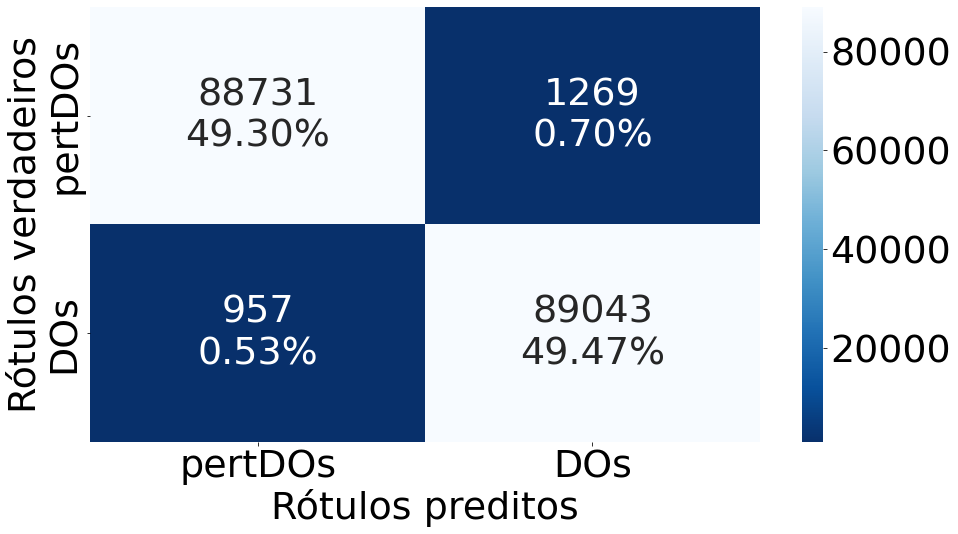

In [99]:
# Import das bibliotecas.
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

x_alvo =     df_dados_classificacao['classe'].tolist()
y_predicao = df_dados_classificacao['predicao'].tolist()

print(classification_report(x_alvo, y_predicao))

# Insere os dados no gráfico
cf_matrix = confusion_matrix(x_alvo, y_predicao)
quantidade_grupos = ["{0:0.0f}".format(valor) for valor in cf_matrix.flatten()]
percentual_grupos = ["{0:.2%}".format(valor) for valor in cf_matrix.flatten()/np.sum(cf_matrix)]
rotulos = [f"{v1}\n{v2}" for v1, v2 in zip(quantidade_grupos,percentual_grupos)]
rotulos = np.asarray(rotulos).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=rotulos, fmt='', cmap='Blues_r')

# Texto do eixo x
ax.set_xlabel('Rótulos preditos')
# Texto do eixo y
ax.set_ylabel('Rótulos verdadeiros')
# Rótulos adicionais
ax.xaxis.set_ticklabels(['pertDOs','DOs'])
ax.yaxis.set_ticklabels(['pertDOs','DOs'])

# Mostra o gráfico
plt.show()

### Listas em pares

#### Listas de pares de documentos originais e perturbados classificados corretamente

In [100]:
def listaClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []  
  lista_retorno_DO = []
  lista_retorno_pertDO = []
  for i, linha in df_dados_classificacao.iterrows():
    #if i < 20:    
    # 1 - Documento Original
    if linha['classe'] == 1 and linha['predicao'] == 1:
        lista_retorno_DO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])
    # 0 - Documento perturbado 
    if linha['classe'] == 0 and linha['predicao'] == 0:
        lista_retorno_pertDO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])

  tipos = {"id": str} 
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id","classe","predicao"]) 
  df_lista_retorno = df_lista_retorno.astype(tipos)

  df_lista_retorno_DO = pd.DataFrame(lista_retorno_DO, columns = ["id","classe","predicao"])
  df_lista_retorno_DO = df_lista_retorno_DO.astype(tipos)

  df_lista_retorno_pertDO = pd.DataFrame(lista_retorno_pertDO, columns = ["id","classe","predicao"])
  df_lista_retorno_pertDO = df_lista_retorno_pertDO.astype(tipos)
  
  return df_lista_retorno, df_lista_retorno_DO, df_lista_retorno_pertDO

In [101]:
lista_retorno_classificado_corretamente, lista_retorno_DO_correto, lista_retorno_pertDO_correto = listaClassificadoCorretamente(df_dados_classificacao)
print('DO e pertDO classificados corretamente:', len(lista_retorno_classificado_corretamente))
print('DO classificados corretamente(VP)     :', len(lista_retorno_DO_correto))
print('pertDO classificados corretamente(FP) :', len(lista_retorno_pertDO_correto))

DO e pertDO classificados corretamente: 177774
DO classificados corretamente(VP)     : 89043
pertDO classificados corretamente(FP) : 88731


#### Listas de pares de documentos originais e perturbados classificados incorretamente

In [102]:
def listaClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []  
  lista_retorno_DO = []
  lista_retorno_pertDO = []
  for i, linha in df_dados_classificacao.iterrows():
    # 1 - Documento Original
    if linha['classe'] == 1 and linha['predicao'] == 0:
        lista_retorno_DO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])        
    # 0 - Documento Perturbado
    if linha['classe'] == 0 and linha['predicao'] == 1:
        lista_retorno_pertDO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])
  
  tipos = {"id": str} 
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id","classe","predicao"])     
  df_lista_retorno = df_lista_retorno.astype(tipos)

  df_lista_retorno_DO = pd.DataFrame(lista_retorno_DO, columns = ["id","classe","predicao"])
  df_lista_retorno_DO = df_lista_retorno_DO.astype(tipos)

  df_lista_retorno_pertDO = pd.DataFrame(lista_retorno_pertDO, columns = ["id","classe","predicao"])
  df_lista_retorno_pertDO = df_lista_retorno_pertDO.astype(tipos)

  return df_lista_retorno, df_lista_retorno_DO, df_lista_retorno_pertDO

In [103]:
lista_retorno_classificado_incorretamente, lista_retorno_DO_incorreto, lista_retorno_pertDO_incorreto = listaClassificadoIncorretamente(df_dados_classificacao)
print('DO e pertDO classificados incorretamente:', len(lista_retorno_classificado_incorretamente))
print('DO classificados incorretamente(VN)     :', len(lista_retorno_DO_incorreto))
print('pertDO classificados incorretamente(FN) :', len(lista_retorno_pertDO_incorreto))

DO e pertDO classificados incorretamente: 2226
DO classificados incorretamente(VN)     : 957
pertDO classificados incorretamente(FN) : 1269


#### Acurácia das listas

In [104]:
total = len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente)
print("Total de documentos                 :", total)
print("  Total de documentos originais     :", (len(lista_retorno_DO_correto)+len(lista_retorno_DO_incorreto)))
print("  Total de documentos perturbados   :", (len(lista_retorno_pertDO_correto)+len(lista_retorno_pertDO_incorreto)))
print("Total de acertos                    :", len(lista_retorno_classificado_corretamente))
print("Total de erros                      :", len(lista_retorno_classificado_incorretamente))
print()
print("Acurácia                                        : {0:.2%}".format(len(lista_retorno_classificado_corretamente)/total))
print("  DO coerentes       = Verdadeiros positivos(VP): {0:.2%}".format(len(lista_retorno_DO_correto)/total))
print("  pertDO incoerentes = Falsos positivos(FP)     : {0:.2%}".format(len(lista_retorno_pertDO_correto)/total))
print("  DO incoerentes     = Verdadeiro negativos(VN) : {0:.2%}".format(len(lista_retorno_DO_incorreto)/total))
print("  pertDO coerentes   = Falsos negativos(FN)     : {0:.2%}".format(len(lista_retorno_pertDO_incorreto)/total))

Total de documentos                 : 180000
  Total de documentos originais     : 90000
  Total de documentos perturbados   : 90000
Total de acertos                    : 177774
Total de erros                      : 2226

Acurácia                                        : 98.76%
  DO coerentes       = Verdadeiros positivos(VP): 49.47%
  pertDO incoerentes = Falsos positivos(FP)     : 49.30%
  DO incoerentes     = Verdadeiro negativos(VN) : 0.53%
  pertDO coerentes   = Falsos negativos(FN)     : 0.70%


#### Listas documentos originais e perturbados e suas classificações sem repetições

Remove a duplicidade dos documentos originais classificados corretamente(VP)

In [105]:
print("Com repetição:",len(lista_retorno_DO_correto))
lista_retorno_DO_classificado_corretamente_sem_repeticao = lista_retorno_DO_correto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_DO_classificado_corretamente_sem_repeticao))

Com repetição: 89043
Sem repetição: 900


Criando dados indexados

In [106]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_DO_classificado_corretamente_sem_repeticao_indexado = lista_retorno_DO_classificado_corretamente_sem_repeticao.set_index(["id"])
lista_retorno_DO_classificado_corretamente_sem_repeticao_indexado.head()

classe  predicao
id                                                
d4e72ad45eee4e64bd9e37a82ecc91b9       1         1
9239d8d17edf4f5fa2d1c489b03a1f84       1         1
210b3fcad3934c3490559ce555e26dcf       1         1
967a8827b6ea48ddb4ff381729810ae4       1         1
879f1d34d55b42fb9a0250288ca2537e       1         1

Remove a duplicidade dos documentos originais classificados incorretamente(VN)

In [107]:
print("Com repetição:",len(lista_retorno_DO_incorreto))
lista_retorno_DO_classificado_incorretamente_sem_repeticao = lista_retorno_DO_incorreto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_DO_classificado_incorretamente_sem_repeticao))

Com repetição: 957
Sem repetição: 82


Criando dados indexados

In [108]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_DO_classificado_incorretamente_sem_repeticao_indexado = lista_retorno_DO_classificado_incorretamente_sem_repeticao.set_index(["id"])
lista_retorno_DO_classificado_incorretamente_sem_repeticao_indexado.head()

classe  predicao
id                                                
0ee23a8c2c064706afc6d0dfed753e40       1         0
369eec14595c4406800332c62cd3a035       1         0
f3a38e6e0cb6480bac4b6661a9558acc       1         0
0c5af052543447e081b723ed3f7aca08       1         0
af6015c7eb864b55a83770490dbbcfbe       1         0

Remove a duplicidade dos documentos perturbados classificados corretamente(FP)

In [109]:
print("Com repetição:",len(lista_retorno_pertDO_correto))
lista_retorno_pertDO_classificado_corretamente_sem_repeticao = lista_retorno_pertDO_correto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_pertDO_classificado_corretamente_sem_repeticao))

Com repetição: 88731
Sem repetição: 88731


Criando dados indexados

In [110]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_pertDO_classificado_corretamente_sem_repeticao_indexado = lista_retorno_pertDO_classificado_corretamente_sem_repeticao.set_index(["id"])
lista_retorno_pertDO_classificado_corretamente_sem_repeticao_indexado.head()

classe  predicao
id                                                        
d4e72ad45eee4e64bd9e37a82ecc91b9_pert_21       0         0
d4e72ad45eee4e64bd9e37a82ecc91b9_pert_23       0         0
d4e72ad45eee4e64bd9e37a82ecc91b9_pert_39       0         0
d4e72ad45eee4e64bd9e37a82ecc91b9_pert_40       0         0
d4e72ad45eee4e64bd9e37a82ecc91b9_pert_53       0         0

Remove a duplicidade dos documentos perturbados classificados incorretamente(FN)

In [111]:
print("Com repetição:",len(lista_retorno_pertDO_incorreto))
lista_retorno_pertDO_classificado_incorretamente_sem_repeticao = lista_retorno_pertDO_incorreto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_pertDO_classificado_incorretamente_sem_repeticao))

Com repetição: 1269
Sem repetição: 1269


Criando dados indexados

In [112]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_pertDO_classificado_incorretamente_sem_repeticao_indexado = lista_retorno_pertDO_classificado_incorretamente_sem_repeticao.set_index(["id"])
lista_retorno_pertDO_classificado_incorretamente_sem_repeticao_indexado.head()

classe  predicao
id                                                        
59ca719898f047158aead30e19e65d36_pert_25       0         1
59ca719898f047158aead30e19e65d36_pert_36       0         1
9b318d04be504fc19d969bd7d0c59260_pert_4        0         1
fc57d366ec674b21a423d6c93c7af751_pert_2        0         1
ee2a6e83216b47f5b390be193221f4e5_pert_1        0         1

Remove as duplicidades dos documentos classificados corretamente.

In [113]:
print("Com repetição:",len(lista_retorno_classificado_corretamente))
lista_retorno_classificado_corretamente_sem_repeticao = lista_retorno_classificado_corretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_classificado_corretamente_sem_repeticao))

Com repetição: 177774
Sem repetição: 89631


Criando dados indexados

In [114]:
lista_retorno_classificado_corretamente_sem_repeticao.sample(5)

id  classe  predicao
83538   a41abb00c3fc4b2984c234804b4f544d_pert_25       0         0
135109  50ce059f18ce4d288c9a0a64df15be80_pert_25       0         0
73024    5e3497732579442ca4848c39d6b44190_pert_5       0         0
61607   fa1bcf9d63e348fda7210b82a3c3688b_pert_16       0         0
93825   8f840d3868ef4e0f98a19bcf5644517a_pert_62       0         0

In [115]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_classificado_corretamente_sem_repeticao_indexado = lista_retorno_classificado_corretamente_sem_repeticao.set_index(["id"])
lista_retorno_classificado_corretamente_sem_repeticao_indexado.head()

classe  predicao
id                                                        
d4e72ad45eee4e64bd9e37a82ecc91b9               1         1
d4e72ad45eee4e64bd9e37a82ecc91b9_pert_21       0         0
d4e72ad45eee4e64bd9e37a82ecc91b9_pert_23       0         0
d4e72ad45eee4e64bd9e37a82ecc91b9_pert_39       0         0
d4e72ad45eee4e64bd9e37a82ecc91b9_pert_40       0         0

Remove as duplicidades dos documentos perturbados classificados incorretamente.

In [116]:
print("Com repetição:",len(lista_retorno_classificado_incorretamente))
lista_retorno_classificado_incorretamente_sem_repeticao = lista_retorno_classificado_incorretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_classificado_incorretamente_sem_repeticao))

Com repetição: 2226
Sem repetição: 1351


Criando dados indexados

In [117]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_classificado_incorretamente_sem_repeticao_indexado = lista_retorno_classificado_incorretamente_sem_repeticao.set_index(["id"])
lista_retorno_classificado_incorretamente_sem_repeticao_indexado.head()

classe  predicao
id                                                        
0ee23a8c2c064706afc6d0dfed753e40               1         0
369eec14595c4406800332c62cd3a035               1         0
59ca719898f047158aead30e19e65d36_pert_25       0         1
59ca719898f047158aead30e19e65d36_pert_36       0         1
9b318d04be504fc19d969bd7d0c59260_pert_4        0         1

### Medidas de DO e pertDO

#### Função quer realiza a medição dos documentos



##### getMedidasComparacaoPalavra

In [118]:
import sys

def getMedidasComparacaoPalavra(id_documento, 
                                index_sentenca,
                                index_wi,
                                index_wj,
                                estrategia_medida=0):

  # Pesquisa a medida de comparação das palavras wi e wj
  # pelo id do documento, índice da sentença, índice da palavra wi e índice da palavra wj
  medidas = lista_comparacao_palavra_indexado.loc[str(id_documento),
                                                  index_sentenca,
                                                  index_wi,
                                                  index_wj]

  if len(medidas) != 0:
    # print(">>>>medidas:",medidas)
    # Seleciona a estratégia de pooling
    pooling = "_mean"
    if estrategia_medida == 1:
      pooling = "_max"

    cos = medidas["cos" + pooling]
    euc = medidas["euc" + pooling]
    man = medidas["man" + pooling]

    return cos, euc, man

  else:
   print("Problemas comparação palavras:", medidas)
   return 0, float(sys.maxsize), float(sys.maxsize)

##### Palavras Adjacentes

###### getMedidasCoerenciaPalavrasAdjacentesDocumentoTodasPalavras

In [119]:
def getMedidasCoerenciaPalavrasAdjacentesDocumentoTodasPalavras(id_documento,
                                                                documento, 
                                                                lista_sentenca_documento, 
                                                                lista_tokens_documento,
                                                                lista_pos_documento,
                                                                estrategia_medida):
  '''
    Percorre as sentenças de um documento para calcular as medidas
  '''
  
  #print("lista_sentenca_documento:", lista_sentenca_documento)
  #print("lista_tokens_documento:", lista_tokens_documento)
  #print("lista_pos_documento:", lista_pos_documento)
  
  # Acumuladores das medidas entre as sentenças    
  soma_Scos = 0
  soma_Seuc = 0
  soma_Sman = 0

  # Quantidade de sentenças no documento
  n = len(lista_sentenca_documento)

  # Percorre as sentenças do documento
  for i, sentenca in enumerate(lista_sentenca_documento):    

    # Carrega as POSTagging da sentença
    sentenca_token = lista_tokens_documento[i]
    # print("sentenca_token:",sentenca_token)
    sentenca_pos = lista_pos_documento[i]
    # print("sentenca_pos:",sentenca_pos)
    #print("Quantidade de palavras:",len(sentenca_token))

    # Quantidade de palavras da sentença
    k = len(sentenca_token)
  
    # Acumuladores das medidas entre as palavras  
    soma_Wcos = 0
    soma_Weuc = 0
    soma_Wman = 0
    
    #Percorre as palavras do documento    
    for ix in range(0,k-1):

      # Seleciona as palavras do documento  
      wi = sentenca_token[ix]
      wj = sentenca_token[ix+1]
      # Seleciona as POS-Tagging das palavras
      pos_i = sentenca_pos[ix]
      pos_j = sentenca_pos[ix+1]

      # print("\nwi:", wi, ix)
      # print("wj:", wj, ix+1)

      # Recupera as medidas entre wi e wj             
      cos, euc, man = getMedidasComparacaoPalavra(id_documento, i, ix, ix+1, estrategia_medida)
  
      # Acumula as medidas do par de palavras
      soma_Wcos = soma_Wcos + abs(cos)
      soma_Weuc = soma_Weuc + abs(euc)
      soma_Wman = soma_Wman + abs(man)

    # Calcula a média das medidas para as k-1 palavras da sentença   
    MWcos = 0
    MWeuc = 0
    MWman = 0

    # Se existe palavras
    if float(k-1) != 0:
      
      MWcos = float(soma_Wcos)/float(k-1)
      MWeuc = float(soma_Weuc)/float(k-1)
      MWman = float(soma_Wman)/float(k-1)
    
    # Acumula a média das medidas das palavras da sentença
    soma_Scos = soma_Scos + MWcos
    soma_Seuc = soma_Seuc + MWeuc
    soma_Sman = soma_Sman + MWman

  # Calcula a média das medidas para o documento
  MScos = float(soma_Scos)/float(n)
  MSeuc = float(soma_Seuc)/float(n)
  MSman = float(soma_Sman)/float(n)
  
  return MScos, MSeuc, MSman

###### getMedidasCoerenciaPalavrasAdjacentesDocumentoSemStopWord

In [120]:
def getMedidasCoerenciaPalavrasAdjacentesDocumentoSemStopWord(id_documento,
                                                              documento, 
                                                              lista_sentenca_documento, 
                                                              lista_tokens_documento, 
                                                              lista_pos_documento,
                                                              estrategia_medida):
  
  '''
    Percorre as sentenças de um documento para calcular as medidas
  '''
  
  #print("lista_sentenca_documento:", lista_sentenca_documento)
  #print("lista_tokens_documento:", lista_tokens_documento)
  #print("lista_pos_documento:", lista_pos_documento)

  # Acumuladores das medidas entre as sentenças    
  soma_Scos = 0
  soma_Seuc = 0
  soma_Sman = 0

  # Quantidade de sentenças no documento
  n = len(lista_sentenca_documento)

  # Percorre as sentenças do documento
  for i, sentenca in enumerate(lista_sentenca_documento):    

    #print("sentenca:",sentenca)  
    # Carrega as POSTagging da sentença
    sentenca_token = lista_tokens_documento[i]
    #print("sentenca_token:",sentenca_token)
    sentenca_pos = lista_pos_documento[i]
    #print("sentenca_pos:",sentenca_pos)
    #print("Quantidade de palavras:",len(sentenca_token))
   
    # Seleciona as palavras e POS-Tagging sem as Stopwords
    lista_tokens_nova = []
    lista_pos_nova = []    
    # Percorre as postagging das palavras
    for ix, palavra in enumerate(sentenca_token):
        # Se o token estiver não lista de stopwords
        if palavra.lower() not in getStopwords(nlp):
          # Guarda os elementos utilizados
          lista_tokens_nova.append(sentenca_token[ix])
          lista_pos_nova.append(sentenca_pos[ix])              
   
    #print("Depois")
    #print("lista_tokens_nova:",lista_tokens_nova)
    #print("POS Tagging:",lista_pos_nova)
    #print("Quantidade de palavras:",len(lista_tokens_nova))

    # Quantidade de palavras na sentença
    k = len(lista_tokens_nova)
      
    # Acumuladores das medidas entre as palavras  
    soma_Wcos = 0
    soma_Weuc = 0
    soma_Wman = 0
    
    #Percorre as palavras do documento    
    for ix in range(0,k-1):

      # Seleciona as palavras do documento  
      wi = lista_tokens_nova[ix]
      wj = lista_tokens_nova[ix+1]
      # Seleciona as POS-Tagging das palavras
      pos_i = lista_pos_nova[ix]
      pos_j = lista_pos_nova[ix+1]

      # print("\nwi:", wi, ix)
      # print("wj:", wj, ix+1)                    

      # Recupera as medidas entre wi e wj             
      cos, euc, man = getMedidasComparacaoPalavra(id_documento, i, ix, ix+1, estrategia_medida)
     
      # Acumula as medidas do par de palavras
      soma_Wcos = soma_Wcos + abs(cos)
      soma_Weuc = soma_Weuc + abs(euc)
      soma_Wman = soma_Wman + abs(man)
   
    # Calcula a média das medidas para as m-1 palavras da sentença   
    MWcos = 0
    MWeuc = 0
    MWman = 0

    # Se existe palavras
    if float(k-1) != 0:
      MWcos = float(soma_Wcos)/float(k-1)
      MWeuc = float(soma_Weuc)/float(k-1)
      MWman = float(soma_Wman)/float(k-1)

    # Acumula a média das medidas das palavras da sentença
    soma_Scos = soma_Scos + MWcos
    soma_Seuc = soma_Seuc + MWeuc
    soma_Sman = soma_Sman + MWman
    
    del lista_tokens_nova
    del lista_pos_nova    
    
  # Calcula a média das medidas para o documento
  MScos = float(soma_Scos)/float(n)
  MSeuc = float(soma_Seuc)/float(n)
  MSman = float(soma_Sman)/float(n)
  
  return MScos, MSeuc, MSman

###### getMedidasCoerenciaPalavrasAdjacentesDocumentoPalavrasSalientes

In [121]:
def getMedidasCoerenciaPalavrasAdjacentesDocumentoPalavrasSalientes(id_documento,
                                                                    documento, 
                                                                    lista_sentenca_documento, 
                                                                    lista_tokens_documento, 
                                                                    lista_pos_documento,
                                                                    estrategia_medida,
                                                                    classe_saliente=["NOUN","VERB","AUX"]):
  
  # Acumuladores das medidas entre as sentenças    
  soma_Scos = 0
  soma_Seuc = 0
  soma_Sman = 0

  # Quantidade de sentenças no documento
  n = len(lista_sentenca_documento)

  # Percorre as sentenças do documento
  for i, sentenca in enumerate(lista_sentenca_documento):    

    # Carrega as POSTagging da sentença
    sentenca_token = lista_tokens_documento[i]
    # print("sentenca_token:",sentenca_token)
    sentenca_pos = lista_pos_documento[i]
    # print("sentenca_pos:",sentenca_pos)
    # print("Quantidade de palavras:",len(sentenca_token))

    # Seleciona somente palavras saliente 
    lista_tokens_nova = []
    lista_pos_nova = []    
    # Percorre as postagging das palavras
    for ix, pos in enumerate(sentenca_pos):
        # Se a postagging da palavra estiver na lista das classes das salientes
        if pos in classe_saliente:
          # Guarda os elementos utilizados
          lista_tokens_nova.append(sentenca_token[ix])
          lista_pos_nova.append(sentenca_pos[ix])    
       
    #print("Depois")
    #print("lista_tokens_nova:",lista_tokens_nova)
    #print("POS Tagging:",lista_pos_nova)
    #print("Quantidade de palavras:",len(lista_tokens_nova))

    # Quantidade de palavras na sentença
    k = len(lista_tokens_nova)
  
    # Acumuladores das medidas entre as palavras  
    soma_Wcos = 0
    soma_Weuc = 0
    soma_Wman = 0
    
    #Percorre as palavras do documento    
    for ix in range(0,k-1):

      # Seleciona as palavras do documento  
      wi = lista_tokens_nova[ix]
      wj = lista_tokens_nova[ix+1]
      # Seleciona as POS-Tagging das palavras
      pos_i = lista_pos_nova[ix]
      pos_j = lista_pos_nova[ix+1]

      # print("\nwi:", wi, ix)
      # print("wj:", wj, ix+1)                  

      # Recupera as medidas entre wi e wj             
      cos, euc, man = getMedidasComparacaoPalavra(id_documento, i, ix, ix+1, estrategia_medida)
     
      # Acumula as medidas do par de palavras
      soma_Wcos = soma_Wcos + abs(cos)
      soma_Weuc = soma_Weuc + abs(euc)
      soma_Wman = soma_Wman + abs(man)

    # Calcula a média das medidas para as m-1 palavras da sentença   
    MWcos = 0
    MWeuc = 0
    MWman = 0

    # Se existe palavras
    if float(k-1) != 0:
      MWcos = float(soma_Wcos)/float(k-1)
      MWeuc = float(soma_Weuc)/float(k-1)
      MWman = float(soma_Wman)/float(k-1)

    # Acumula a média das medidas das palavras da sentença
    soma_Scos = soma_Scos + MWcos
    soma_Seuc = soma_Seuc + MWeuc
    soma_Sman = soma_Sman + MWman

    del lista_tokens_nova
    del lista_pos_nova

  # Calcula a média das medidas para o documento
  MScos = float(soma_Scos)/float(n)
  MSeuc = float(soma_Seuc)/float(n)
  MSman = float(soma_Sman)/float(n)
    
  return MScos, MSeuc, MSman

###### getMedidasCoerenciaPalavrasAdjacentes

Recupera as medidas da coerência das palavras adjacentes de acordo com o filtro de palavras a ser utilizado nos documentos.

In [122]:
def getMedidasCoerenciaPalavrasAdjacentes(id_documento,
                                          documento, 
                                          lista_sentenca_documento, 
                                          lista_tokens_documento, 
                                          lista_pos_documento, 
                                          estrategia_medida = 0,
                                          filtro_palavra = 0,
                                          classe_saliente=["NOUN","VERB","AUX"]):

  """
    Recupera as medidas da coerência das palavras adjacentes de acordo com o filtro de palavras a ser utilizado nos documentos.
  """    
  
  if filtro_palavra == 0: # Todas as palavras
    return getMedidasCoerenciaPalavrasAdjacentesDocumentoTodasPalavras(id_documento, 
                                                                       documento, 
                                                                       lista_sentenca_documento, 
                                                                       lista_tokens_documento, 
                                                                       lista_pos_documento,
                                                                       estrategia_medida)
  else:
    if filtro_palavra == 1: # Sem stopwords
        return getMedidasCoerenciaPalavrasAdjacentesDocumentoSemStopWord(id_documento, 
                                                                         documento, 
                                                                         lista_sentenca_documento, 
                                                                         lista_tokens_documento, 
                                                                         lista_pos_documento,
                                                                         estrategia_medida)
    else: 
        if filtro_palavra == 2: # Somente verbos(e auxiliares) substantivos          
          return getMedidasCoerenciaPalavrasAdjacentesDocumentoPalavrasSalientes(id_documento, 
                                                                                 documento, 
                                                                                 lista_sentenca_documento, 
                                                                                 lista_tokens_documento, 
                                                                                 lista_pos_documento,
                                                                                 estrategia_medida,
                                                                                 classe_saliente=classe_saliente) 

##### Palavras Combinação

###### getMedidasCoerenciaPalavrasCombinacaoDocumentoTodasPalavras

In [123]:
def getMedidasCoerenciaPalavrasCombinacaoDocumentoTodasPalavras(id_documento,
                                                                documento, 
                                                                lista_sentenca_documento, 
                                                                lista_tokens_documento, 
                                                                lista_pos_documento,
                                                                estrategia_medida):
  '''
    Percorre as sentenças de um documento para calcular as medidas
  '''
  
  #print("lista_sentenca_documento:", lista_sentenca_documento)
  #print("lista_tokens_documento:", lista_tokens_documento)
  #print("lista_pos_documento:", lista_pos_documento)
  
  # Acumuladores das medidas entre as sentenças    
  soma_Scos = 0
  soma_Seuc = 0
  soma_Sman = 0

  # Quantidade de sentenças no documento
  n = len(lista_sentenca_documento)

  # Percorre as sentenças do documento
  for i, sentenca in enumerate(lista_sentenca_documento):    

    # Carrega as POSTagging da sentença
    sentenca_token = lista_tokens_documento[i]
    # print("sentenca_token:",sentenca_token)
    sentenca_pos = lista_pos_documento[i]
    # print("sentenca_pos:",sentenca_pos)
    #print("Quantidade de palavras:",len(sentenca_token))

    # Quantidade de palavras da sentença
    k = len(sentenca_token)
  
    # Acumuladores das medidas entre as palavras  
    soma_Wcos = 0
    soma_Weuc = 0
    soma_Wman = 0

    contaComparacoes = 0
    
    # Seleciona os pares de sentença a serem avaliados
    for ix in range(0,k-1):

      # Seleciona as palavras do documento  
      wi = sentenca_token[ix]      
      pos_i = sentenca_pos[ix]
        
      # Percorre as palavras da sentença
      for jx in range(ix+1,k):

        # Seleciona as palavras do documento  
        wj = sentenca_token[jx]
        pos_j = sentenca_pos[jx]

        # print("\nwi:", wi, pos_i)                          
        # print("wj:", wj, pos_j)                    

        # Recupera as medidas entre wi e wj             
        cos, euc, man = getMedidasComparacaoPalavra(id_documento, i, ix, jx, estrategia_medida)
  
        # Acumula as medidas do par de palavras
        soma_Wcos = soma_Wcos + abs(cos)
        soma_Weuc = soma_Weuc + euc
        soma_Wman = soma_Wman + man

        contaComparacoes = contaComparacoes + 1
      
    # Calcula a média das medidas para as m-1 palavras da sentença   
    MWcos = 0
    MWeuc = 0
    MWman = 0

    # Se existe palavras
    if float(k-1) != 0:
      MWcos = float(soma_Wcos)/float(contaComparacoes)
      MWeuc = float(soma_Weuc)/float(contaComparacoes)
      MWman = float(soma_Wman)/float(contaComparacoes)
    
    # Acumula a média das medidas das palavras da sentença
    soma_Scos = soma_Scos + MWcos
    soma_Seuc = soma_Seuc + MWeuc
    soma_Sman = soma_Sman + MWman

  # Calcula a média das medidas para o documento
  MScos = float(soma_Scos)/float(n)
  MSeuc = float(soma_Seuc)/float(n)
  MSman = float(soma_Sman)/float(n)
  
  return MScos, MSeuc, MSman

###### getMedidasCoerenciaPalavrasCombinacaoDocumentoSemStopWord


In [124]:
def getMedidasCoerenciaPalavrasCombinacaoDocumentoSemStopWord(id_documento,
                                                              documento, 
                                                              lista_sentenca_documento, 
                                                              lista_tokens_documento, 
                                                              lista_pos_documento,
                                                              estrategia_medida):
  
  '''
    Percorre as sentenças de um documento para calcular as medidas
  '''
  
  #print("lista_sentenca_documento:", lista_sentenca_documento)
  #print("lista_tokens_documento:", lista_tokens_documento)
  #print("lista_pos_documento:", lista_pos_documento)

  # Acumuladores das medidas entre as sentenças    
  soma_Scos = 0
  soma_Seuc = 0
  soma_Sman = 0

  # Quantidade de sentenças no documento
  n = len(lista_sentenca_documento)

  # Percorre as sentenças do documento
  for i, sentenca in enumerate(lista_sentenca_documento):    

    #print("sentenca:",sentenca)  
    # Carrega as POSTagging da sentença
    sentenca_token = lista_tokens_documento[i]
    #print("sentenca_token:",sentenca_token)
    sentenca_pos = lista_pos_documento[i]
    #print("sentenca_pos:",sentenca_pos)
    #print("Quantidade de palavras:",len(sentenca_token))
   
    # Seleciona as palavras e POS-Tagging sem as Stopwords
    lista_tokens_nova = []
    lista_pos_nova = []    
    # Percorre as postagging das palavras
    for ix, palavra in enumerate(sentenca_token):
        # Se o token estiver não lista de stopwords
        if palavra.lower() not in getStopwords(nlp):
          # Guarda os elementos utilizados
          lista_tokens_nova.append(sentenca_token[ix])
          lista_pos_nova.append(sentenca_pos[ix])              

    #print("Depois")
    #print("lista_tokens_nova:",lista_tokens_nova)
    #print("POS Tagging:",lista_pos_nova)
    #print("Quantidade de palavras:",len(lista_tokens_nova))

    # Quantidade de palavras na sentença
    k = len(lista_tokens_nova)
  
    # Acumuladores das medidas entre as palavras  
    soma_Wcos = 0
    soma_Weuc = 0
    soma_Wman = 0
    
    # Seleciona os pares de sentença a serem avaliados
    for ix in range(0,k-1):
      # Seleciona as palavras do documento  
      wi = lista_tokens_nova[ix]      
      pos_i = lista_pos_nova[ix]
        
      # Percorre as palavras da sentença
      for jx in range(ix+1,k):
        # Seleciona as palavras do documento  
        wj = lista_tokens_nova[jx]
        pos_j = lista_pos_nova[jx]

        # print("\nwi:", wi, pos_i)                          
        # print("wj:", wj, pos_j)                    

        # Recupera as medidas entre wi e wj             
        cos, euc, man = getMedidasComparacaoPalavra(id_documento, i, ix, jx, estrategia_medida)
  
        # Acumula as medidas do par de palavras
        soma_Wcos = soma_Wcos + abs(cos)
        soma_Weuc = soma_Weuc + euc
        soma_Wman = soma_Wman + man
      
    # Calcula a média das medidas para as m-1 palavras da sentença   
    MWcos = 0
    MWeuc = 0
    MWman = 0

    # Se existe palavras
    if float(k-1) != 0:
      MWcos = float(soma_Wcos)/float(k-1)
      MWeuc = float(soma_Weuc)/float(k-1)
      MWman = float(soma_Wman)/float(k-1)
    
    # Acumula a média das medidas das palavras da sentença
    soma_Scos = soma_Scos + MWcos
    soma_Seuc = soma_Seuc + MWeuc
    soma_Sman = soma_Sman + MWman

    del lista_tokens_nova
    del lista_pos_nova    

  # Calcula a média das medidas para o documento
  Scos = float(soma_Scos)/float(n)
  Seuc = float(soma_Seuc)/float(n)
  Sman = float(soma_Sman)/float(n)
    
  return Scos, Seuc, Sman

###### getMedidasCoerenciaPalavrasCombinacaoDocumentoPalavrasSalientes

In [125]:
def getMedidasCoerenciaPalavrasCombinacaoDocumentoPalavrasSalientes(id_documento,
                                                                    documento, 
                                                                    lista_sentenca_documento, 
                                                                    lista_tokens_documento, 
                                                                    lista_pos_documento,
                                                                    estrategia_medida,
                                                                    classe_saliente=["NOUN","VERB","AUX"]):
  
  # Acumuladores das medidas entre as sentenças    
  soma_Scos = 0
  soma_Seuc = 0
  soma_Sman = 0

  # Quantidade de sentenças no documento
  n = len(lista_sentenca_documento)

  # Percorre as sentenças do documento
  for i, sentenca in enumerate(lista_sentenca_documento):    

    # Carrega as POSTagging da sentença
    sentenca_token = lista_tokens_documento[i]
    # print("sentenca_token:",sentenca_token)
    sentenca_pos = lista_pos_documento[i]
    # print("sentenca_pos:",sentenca_pos)
    # print("Quantidade de palavras:",len(sentenca_token))

    # Somente palavras saliente 
    lista_tokens_nova = []
    lista_pos_nova = []    
    # Percorre as postagging das palavras
    for ix, pos in enumerate(sentenca_pos):
        # Se a postagging da palavra estiver na lista das classes das salientes
        if pos in classe_saliente:
          # Guarda os elementos utilizados
          lista_tokens_nova.append(sentenca_token[ix])
          lista_pos_nova.append(sentenca_pos[ix])
    
    #print("Depois")
    #print("lista_tokens_nova:",lista_tokens_nova)
    #print("POS Tagging:",lista_pos_nova)
    #print("Quantidade de palavras:",len(lista_tokens_nova))

    # Quantidade de palavras na sentença
    k = len(lista_tokens_nova)
  
    # Acumuladores das medidas entre as palavras  
    soma_Wcos = 0
    soma_Weuc = 0
    soma_Wman = 0
    
     # Acumuladores das medidas entre as palavras  
    soma_Wcos = 0
    soma_Weuc = 0
    soma_Wman = 0
    
    # Seleciona os pares de sentença a serem avaliados
    for ix in range(0,k-1):
      # Seleciona as palavras do documento  
      wi = lista_tokens_nova[ix]      
      pos_i = lista_pos_nova[ix]
        
      # Percorre as palavras da sentença
      for jx in range(ix+1,k):
        # Seleciona as palavras do documento  
        wj = lista_tokens_nova[jx]
        pos_j = lista_pos_nova[jx]

        # print("\nwi:", wi, pos_i)                          
        # print("wj:", wj, pos_j)                    

        # Recupera as medidas entre wi e wj             
        cos, euc, man = getMedidasComparacaoPalavra(id_documento, i, ix, jx, estrategia_medida)
  
        # Acumula as medidas do par de palavras
        soma_Wcos = soma_Wcos + abs(cos)
        soma_Weuc = soma_Weuc + euc
        soma_Wman = soma_Wman + man

    # Calcula a média das medidas para as m-1 palavras da sentença   
    MWcos = 0
    MWeuc = 0
    MWman = 0

    # Se existe palavras
    if float(k-1) != 0:
      MWcos = float(soma_Wcos)/float(k-1)
      MWeuc = float(soma_Weuc)/float(k-1)
      MWman = float(soma_Wman)/float(k-1)

    # Acumula a média das medidas das palavras da sentença
    soma_Scos = soma_Scos + MWcos
    soma_Seuc = soma_Seuc + MWeuc
    soma_Sman = soma_Sman + MWman

    del lista_tokens_nova
    del lista_pos_nova

  # Calcula a média das medidas para o documento
  MScos = float(soma_Scos)/float(n)
  MSeuc = float(soma_Seuc)/float(n)
  MSman = float(soma_Sman)/float(n)
  
  return MScos, MSeuc, MSman

###### getMedidasCoerenciaPalavrasCombinacao

Recupera as medidas da coerência da combinação de palavras de acordo com o filtro de palavras a ser utilizado nos documentos.

In [126]:
def getMedidasCoerenciaPalavrasCombinacao(id_documento,
                                          documento, 
                                          lista_sentenca_documento, 
                                          lista_tokens_documento, 
                                          lista_pos_documento,
                                          estrategia_medida,                                
                                          filtro_palavra = 0,
                                          classe_saliente=["NOUN","VERB","AUX"]):
  """
    Recupera as medidas da coerência da combinação de palavras de acordo com o filtro de palavras a ser utilizado nos documentos.
  """  
  
  if filtro_palavra == 0: # Todas as palavras
    return getMedidasCoerenciaPalavrasCombinacaoDocumentoTodasPalavras(id_documento, 
                                                                       documento, 
                                                                       lista_sentenca_documento, 
                                                                       lista_tokens_documento, 
                                                                       lista_pos_documento,
                                                                       estrategia_medida)
  else:
    if filtro_palavra == 1: # Sem stopwords
        return getMedidasCoerenciaPalavrasCombinacaoDocumentoSemStopWord(id_documento, documento, 
                                                                         lista_sentenca_documento, 
                                                                         lista_tokens_documento, 
                                                                         lista_pos_documento,
                                                                         estrategia_medida)
    else: 
        if filtro_palavra == 2: # Somente verbos(e auxiliares) substantivos          
          return getMedidasCoerenciaPalavrasCombinacaoDocumentoPalavrasSalientes(id_documento, 
                                                                                 documento, 
                                                                                 lista_sentenca_documento, 
                                                                                 lista_tokens_documento, 
                                                                                 lista_pos_documento,
                                                                                 estrategia_medida,
                                                                                 classe_saliente=classe_saliente)

##### Contexto

###### getMedidasComparacaoPalavrasGlobal

In [127]:
import sys

def getMedidasComparacaoPalavrasGlobal(id_documento, 
                                       index_sentenca, 
                                       index_wi,                                       
                                       estrategia_medida=0,
                                       filtro_palavra=0):
  
  # Pesquisa a medida palavra wi e o contexto
  # pelo id do documento, índice da sentença, índice da palavra wi
  medidas = lista_comparacao_contexto_indexado.loc[str(id_documento),
                                                   index_sentenca,
                                                   index_wi]

  if len(medidas) != 0:
    # print(">>>>medidas:",medidas)
    # Seleciona a estratégia de pooling
    pooling = "_mean"
    if estrategia_medida == 1:
      pooling = "_max"

    # Seleciona o filtro de palavra
    if filtro_palavra == 0: # Todas as palavras
      cos = medidas["cos_ctxall" + pooling]
      euc = medidas["euc_ctxall" + pooling]
      man = medidas["man_ctxall" + pooling]
    else:
      if filtro_palavra == 1: # Sem as stopwords
        cos = medidas["cos_ctxclean" + pooling]
        euc = medidas["euc_ctxclean" + pooling]
        man = medidas["man_ctxclean" + pooling]
      else:
        if filtro_palavra == 2: # Somente verbos, auxiliar e substantivo
          cos = medidas["cos_ctxverbnoun" + pooling]
          euc = medidas["euc_ctxverbnoun" + pooling]
          man = medidas["man_ctxverbnoun" + pooling]

    return cos, euc, man

  else:
    print("Problemas comparação contexto:", medidas)
    return 0, float(sys.maxsize), float(sys.maxsize)

###### getMedidasCoerenciaPalavrasGlobalDocumentoTodasPalavras

In [128]:
def getMedidasCoerenciaPalavrasGlobalDocumentoTodasPalavras(id_documento,
                                                            documento, 
                                                            lista_sentenca_documento, 
                                                            lista_tokens_documento, 
                                                            lista_pos_documento,
                                                            estrategia_medida,
                                                            filtro_palavra):
  '''
    Percorre as sentenças de um documento para calcular as medidas
  '''
  
  #print("lista_sentenca_documento:", lista_sentenca_documento)
  #print("lista_tokens_documento:", lista_tokens_documento)
  #print("lista_pos_documento:", lista_pos_documento)
  
  # Acumuladores das medidas entre as sentenças    
  soma_Scos = 0
  soma_Seuc = 0
  soma_Sman = 0

  # Quantidade de sentenças no documento
  n = len(lista_sentenca_documento)

  # Percorre as sentenças do documento
  for i, sentenca in enumerate(lista_sentenca_documento):    

    # Carrega as POSTagging da sentença
    sentenca_token = lista_tokens_documento[i]
    # print("sentenca_token:",sentenca_token)
    sentenca_pos = lista_pos_documento[i]
    # print("sentenca_pos:",sentenca_pos)
    #print("Quantidade de palavras:",len(sentenca_token))

    # Quantidade de palavras da sentença
    k = len(sentenca_token)
  
    # Acumuladores das medidas entre as palavras  
    soma_Wcos = 0
    soma_Weuc = 0
    soma_Wman = 0
    
    # Seleciona os pares de sentença a serem avaliados
    for ix in range(0,k):

      # Seleciona as palavras do documento  
      wi = sentenca_token[ix]      
      pos_i = sentenca_pos[ix]
        
      # print("\nwi:", wi, pos_i)      

      # Recupera as medidas entre wi com o contexto
      cos, euc, man = getMedidasComparacaoPalavrasGlobal(id_documento, 
                                                         i,
                                                         ix,
                                                         estrategia_medida,
                                                         filtro_palavra)
  
      # Acumula as medidas do par de palavras
      soma_Wcos = soma_Wcos + abs(cos)
      soma_Weuc = soma_Weuc + abs(euc)
      soma_Wman = soma_Wman + abs(man)
      
    # Calcula a média das medidas para as m-1 palavras da sentença   
    MWcos = 0
    MWeuc = 0
    MWman = 0

    # Se existe palavras
    if float(k) != 0:
      MWcos = float(soma_Wcos)/float(k)
      MWeuc = float(soma_Weuc)/float(k)
      MWman = float(soma_Wman)/float(k)
    
    # Acumula a média das medidas das palavras da sentença
    soma_Scos = soma_Scos + MWcos
    soma_Seuc = soma_Seuc + MWeuc
    soma_Sman = soma_Sman + MWman

  # Calcula a média das medidas para o documento
  MScos = float(soma_Scos)/float(n)
  MSeuc = float(soma_Seuc)/float(n)
  MSman = float(soma_Sman)/float(n)
  
  return MScos, MSeuc, MSman

###### getMedidasCoerenciaPalavrasGlobalDocumentoSemStopWord

In [129]:
def getMedidasCoerenciaPalavrasGlobalDocumentoSemStopWord(id_documento,
                                                          documento, 
                                                          lista_sentenca_documento, 
                                                          lista_tokens_documento, 
                                                          lista_pos_documento,
                                                          estrategia_medida,
                                                          filtro_palavra):
  
  '''
    Percorre as sentenças de um documento para calcular as medidas
  '''
  
  #print("lista_sentenca_documento:", lista_sentenca_documento)
  #print("lista_tokens_documento:", lista_tokens_documento)
  #print("lista_pos_documento:", lista_pos_documento)

  # Acumuladores das medidas entre as sentenças    
  soma_Scos = 0
  soma_Seuc = 0
  soma_Sman = 0

  # Quantidade de sentenças no documento
  n = len(lista_sentenca_documento)

  # Percorre as sentenças do documento
  for i, sentenca in enumerate(lista_sentenca_documento):    

    #print("sentenca:",sentenca)  
    # Carrega as POSTagging da sentença
    sentenca_token = lista_tokens_documento[i]
    #print("sentenca_token:",sentenca_token)
    sentenca_pos = lista_pos_documento[i]
    #print("sentenca_pos:",sentenca_pos)
    #print("Quantidade de palavras:",len(sentenca_token))
   
    # Seleciona as palavras e POS-Tagging sem as Stopwords
    lista_tokens_nova = []
    lista_pos_nova = []    
    # Percorre as postagging das palavras
    for ix, palavra in enumerate(sentenca_token):
        # Se o token estiver não lista de stopwords
        if palavra.lower() not in getStopwords(nlp):
          # Guarda os elementos utilizados
          lista_tokens_nova.append(sentenca_token[ix])
          lista_pos_nova.append(sentenca_pos[ix])              

    #print("Depois")
    #print("lista_tokens_nova:",lista_tokens_nova)
    #print("POS Tagging:",lista_pos_nova)
    #print("Quantidade de palavras:",len(lista_tokens_nova))

    # Quantidade de palavras na sentença
    k = len(lista_tokens_nova)
  
    # Acumuladores das medidas entre as palavras  
    soma_Wcos = 0
    soma_Weuc = 0
    soma_Wman = 0
    
    # Seleciona os pares de sentença a serem avaliados
    for ix in range(0,k):

      # Seleciona as palavras do documento  
      wi = lista_tokens_nova[ix]      
      pos_i = lista_pos_nova[ix]
        
      # print("\nwi:", wi, pos_i)      

      # Recupera as medidas entre wi com o contexto
      cos, euc, man = getMedidasComparacaoPalavrasGlobal(id_documento, 
                                                         i,
                                                         ix,
                                                         estrategia_medida,
                                                         filtro_palavra)
      
      # Acumula as medidas do par de palavras
      soma_Wcos = soma_Wcos + abs(cos)
      soma_Weuc = soma_Weuc + abs(euc)
      soma_Wman = soma_Wman + abs(man)
      
    # Calcula a média das medidas para as m-1 palavras da sentença   
    MWcos = 0
    MWeuc = 0
    MWman = 0

    # Se existe palavras
    if float(k) != 0:
      MWcos = float(soma_Wcos)/float(k)
      MWeuc = float(soma_Weuc)/float(k)
      MWman = float(soma_Wman)/float(k)
    
    # Acumula a média das medidas das palavras da sentença
    soma_Scos = soma_Scos + MWcos
    soma_Seuc = soma_Seuc + MWeuc
    soma_Sman = soma_Sman + MWman

    del lista_tokens_nova
    del lista_pos_nova

  # Calcula a média das medidas para o documento
  Scos = float(soma_Scos)/float(n)
  Seuc = float(soma_Seuc)/float(n)
  Sman = float(soma_Sman)/float(n)
    
  return Scos, Seuc, Sman

###### getMedidasCoerenciaPalavrasGlobalDocumentoPalavrasSalientes

In [130]:
def getMedidasCoerenciaPalavrasGlobalDocumentoPalavrasSalientes(id_documento,
                                                                documento, 
                                                                lista_sentenca_documento, 
                                                                lista_tokens_documento, 
                                                                lista_pos_documento,
                                                                estrategia_medida,
                                                                filtro_palavra,
                                                                classe_saliente=["NOUN","VERB","AUX"]):

  # Acumuladores das medidas entre as sentenças    
  soma_Scos = 0
  soma_Seuc = 0
  soma_Sman = 0

  # Quantidade de sentenças no documento
  n = len(lista_sentenca_documento)

  # Percorre as sentenças do documento
  for i, sentenca in enumerate(lista_sentenca_documento):    

    # Carrega as POSTagging da sentença
    sentenca_token = lista_tokens_documento[i]
    # print("sentenca_token:",sentenca_token)
    sentenca_pos = lista_pos_documento[i]
    # print("sentenca_pos:",sentenca_pos)
    # print("Quantidade de palavras:",len(sentenca_token))

    # Somente palavras saliente 
    lista_tokens_nova = []
    lista_pos_nova = []    
    # Percorre as postagging das palavras
    for ix, pos in enumerate(sentenca_pos):
        # Se a postagging da palavra estiver na lista das classes das salientes
        if pos in classe_saliente:
          # Guarda os elementos utilizados
          lista_tokens_nova.append(sentenca_token[ix])
          lista_pos_nova.append(sentenca_pos[ix])
    
    #print("Depois")
    #print("lista_tokens_nova:",lista_tokens_nova)
    #print("POS Tagging:",lista_pos_nova)
    #print("Quantidade de palavras:",len(lista_tokens_nova))

    # Quantidade de palavras na sentença
    k = len(lista_tokens_nova)
  
    # Acumuladores das medidas entre as palavras  
    soma_Wcos = 0
    soma_Weuc = 0
    soma_Wman = 0
    
     # Acumuladores das medidas entre as palavras  
    soma_Wcos = 0
    soma_Weuc = 0
    soma_Wman = 0
    
    # Seleciona os pares de sentença a serem avaliados
    for ix in range(0,k):

      # Seleciona as palavras do documento  
      wi = lista_tokens_nova[ix]      
      pos_i = lista_pos_nova[ix]
        
      # print("\nwi:", wi, pos_i)      

      # Recupera as medidas entre wi com o contexto
      cos, euc, man = getMedidasComparacaoPalavrasGlobal(id_documento, 
                                                         i,
                                                         ix,                                                          
                                                         estrategia_medida,
                                                         filtro_palavra)
  
      # Acumula as medidas do par de palavras
      soma_Wcos = soma_Wcos + abs(cos)
      soma_Weuc = soma_Weuc + abs(euc)
      soma_Wman = soma_Wman + abs(man)

    # Calcula a média das medidas para as m-1 palavras da sentença   
    MWcos = 0
    MWeuc = 0
    MWman = 0

    # Se existe palavras
    if float(k) != 0:
      MWcos = float(soma_Wcos)/float(k)
      MWeuc = float(soma_Weuc)/float(k)
      MWman = float(soma_Wman)/float(k)

    # Acumula a média das medidas das palavras da sentença
    soma_Scos = soma_Scos + MWcos
    soma_Seuc = soma_Seuc + MWeuc
    soma_Sman = soma_Sman + MWman

    del lista_tokens_nova
    del lista_pos_nova

  # Calcula a média das medidas para o documento
  MScos = float(soma_Scos)/float(n)
  MSeuc = float(soma_Seuc)/float(n)
  MSman = float(soma_Sman)/float(n)
  
  return MScos, MSeuc, MSman

###### getMedidasCoerenciaPalavrasGlobal

Recupera as medidas da palavra com o contexto global de acordo com o filtro de palavras a ser utilizado nos documentos.



In [131]:
def getMedidasCoerenciaPalavrasGlobal(id_documento, 
                                      documento, 
                                      lista_sentenca_documento, 
                                      lista_tokens_documento, 
                                      lista_pos_documento,
                                      estrategia_medida,                             
                                      filtro_palavra = 0,
                                      classe_saliente=["NOUN","VERB","AUX"]):
  
  """
    Recupera as medidas da palavra com o contexto global de acordo com o filtro de palavras a ser utilizado nos documentos.
  """
  
  if filtro_palavra == 0: # Todas as palavras
    return getMedidasCoerenciaPalavrasGlobalDocumentoTodasPalavras(id_documento, 
                                                                   documento, 
                                                                   lista_sentenca_documento, 
                                                                   lista_tokens_documento, 
                                                                   lista_pos_documento,
                                                                   estrategia_medida,
                                                                   filtro_palavra)
  else:
    if filtro_palavra == 1: # Sem stopwords
        return getMedidasCoerenciaPalavrasGlobalDocumentoSemStopWord(id_documento, documento, 
                                                                     lista_sentenca_documento, 
                                                                     lista_tokens_documento, 
                                                                     lista_pos_documento,
                                                                     estrategia_medida,
                                                                     filtro_palavra)
    else: 
        if filtro_palavra == 2: # Somente verbos(e auxiliares) substantivos          
          return getMedidasCoerenciaPalavrasGlobalDocumentoPalavrasSalientes(id_documento, 
                                                                             documento, 
                                                                             lista_sentenca_documento, 
                                                                             lista_tokens_documento, 
                                                                             lista_pos_documento,
                                                                             estrategia_medida,
                                                                             filtro_palavra,
                                                                             classe_saliente=classe_saliente)          

###### getMedidasCoerenciaDocumento

Recupera as medidas de coerência de acordo com a equação a ser utilizado nos documentos.

In [132]:
def getMedidasCoerenciaDocumento(id_documento,                                  
                                 documento, 
                                 lista_sentenca_documento, 
                                 lista_tokens_documento, 
                                 lista_pos_documento,
                                 equacao_medida = 0,
                                 estrategia_medida = 0,
                                 filtro_palavra = 0,
                                 classe_saliente=["NOUN","VERB","AUX"]):
  
  """
    Recupera as medidas de coerência de acordo com a equação a ser utilizado nos documentos.
  """
  
  if equacao_medida == 0: # Compara palavras adjacentes
    # print("Calculando para palavra adjacentes")
    return getMedidasCoerenciaPalavrasAdjacentes(id_documento, 
                                                 documento, 
                                                 lista_sentenca_documento, 
                                                 lista_tokens_documento, 
                                                 lista_pos_documento, 
                                                 estrategia_medida,
                                                 filtro_palavra,
                                                 classe_saliente=classe_saliente)
  else:
    if equacao_medida == 1: # Compara todas as palavras
        # print("Calculando para todas as palavras")
        return getMedidasCoerenciaPalavrasCombinacao(id_documento, 
                                                     documento, 
                                                     lista_sentenca_documento, 
                                                     lista_tokens_documento, 
                                                     lista_pos_documento, 
                                                     estrategia_medida,
                                                     filtro_palavra,
                                                     classe_saliente=classe_saliente)
    else:         
        if equacao_medida == 2: # Somente verbos(e auxiliares) substantivos          
          # print("Calculando para o contexto")  
          return getMedidasCoerenciaPalavrasGlobal(id_documento, 
                                                   documento, 
                                                   lista_sentenca_documento, 
                                                   lista_tokens_documento, 
                                                   lista_pos_documento,
                                                   estrategia_medida,
                                                   filtro_palavra, 
                                                   classe_saliente=classe_saliente) 

##### Auxiliares

###### getDadosDocumento

Recuperar os dados de documentos originais ou perturbados.

In [133]:
def getDadosDocumento(_id_documento):
  """
    Recupera os dados de um documento. Procura na lista de documentos originais e documentos perturbados.
    
    Parâmetros:
      `_id_documento` - Um id de documento original o perturbado.
      
    Retorno:
      `documento_original` - Um texto com o documento. 
      `lista_sentenca_documento_original` - Uma lista com as sentenças do documento.
      `lista_tokens_documento_original` - Uma lista com os tokens do documento.
      `lista_pos_documento_original` - Uma lista com os PoS-Tagging do documento.
  
  """

  # print("_id_documento:",_id_documento)
  # Procurar nos documentos perturbados
  if "_pert_" in str(_id_documento):
    # localiza os dados do documento perturbado 
    reg_documento_perturbado = lista_documentos_perturbados_indexado.loc[_id_documento]
        
    # Recupera as sentenças do documento perturbado
    lista_sentenca_documento_perturbado = reg_documento_perturbado["perturbado"]
    # Recupera o documento perturbado
    documento_perturbado = reg_documento_perturbado["documento_perturbado"]  

    # Recupera as POS Tagging do documento perturbado
    tokens_perturbado = []
    tokens_perturbado_pos = []        
    reg_perturbado_pos = lista_documentos_perturbados_pos_indexado.loc[_id_documento]
    #print("reg_perturbado_pos:",reg_perturbado_pos)
    pos_documento_perturbado = reg_perturbado_pos['pos_documento']
    for i, linha2 in enumerate(pos_documento_perturbado):
      tokens_perturbado.append(linha2[0])
      tokens_perturbado_pos.append(linha2[1])

    # Recupera os tokens e pos do documento perturbado
    lista_tokens_documento_perturbado = tokens_perturbado
    lista_pos_documento_perturbado = tokens_perturbado_pos

    return documento_perturbado, lista_sentenca_documento_perturbado, lista_tokens_documento_perturbado, lista_pos_documento_perturbado
  else:
    # Procurar nos documentos originais
    # localiza os dados do documento original                                     
    reg_documento_original = lista_documentos_originais_indexado.loc[_id_documento]

    # Recupera as sentenças do documento orriginal    
    lista_sentenca_documento_original = reg_documento_original["sentencas"]     
    #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
    #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
    # Recupera o documento Original
    documento_original = reg_documento_original["documento"]    
          
    # Recupera as POS Tagging do documento original
    documentos_originais_pos = lista_documentos_originais_pos_indexado.loc[_id_documento]
    # print("documentos_originais_pos:", documentos_originais_pos)
    # print("len(documentos_originais_pos):", len(documentos_originais_pos))

    # Recupera os tokens e POS do documento original
    tokens_original = []
    tokens_original_pos = []    
    reg_original_pos = lista_documentos_originais_pos_indexado.loc[_id_documento] 
    # print("reg_original_pos:",reg_original_pos)    
    pos_documento_original = reg_original_pos['pos_documento']
    for i, linha2 in enumerate(pos_documento_original):      
      tokens_original.append(linha2[0])
      tokens_original_pos.append(linha2[1])
              
    # Recupera os tokens e pos do documento original
    lista_tokens_documento_original = tokens_original
    lista_pos_documento_original = tokens_original_pos

    return documento_original, lista_sentenca_documento_original, lista_tokens_documento_original, lista_pos_documento_original

###### getMedidasCoerenciaDocumentoId

In [134]:
def getMedidasCoerenciaDocumentoId(id_documento,
                                   equacao_medida = 0,
                                   estrategia_medida = 0,
                                   filtro_palavra = 0):
  """
    Recupera as medidas das equações de documento original ou perturbado.
    
    Parâmetros:
      `id_documento` - Um id de documento original o perturbado.
      `equacao_medida` - Um id equação de medida (0 - CAW, 1 - CWP, 2 - CG). 
      `estrategia_medida` - Um id de estratégia de medida (0 - MEAN, 1 - MAX).
      `filtro_palavra` - Um id de filtro de palavra (0 - ALL, 1 - CLEAN, 2 - REL).
      
    Retorno:
      `medida_cos` - A medida do documento segundo os parâmetros usando similaridade do cosseno.
      `medida_euc` - A medida do documento segundo os parâmetros usando distância Euclidiana.
      `medida_man` - A medida do documento segundo os parâmetros usando distância de Manhattan.
  
  """
  
  # Localiza os dados do documento
  documento, lista_sentenca_documento, lista_tokens_documento, lista_pos_documento = getDadosDocumento(id_documento)

  # Retorna as medidas de acorrdo com os parâmetros
  return getMedidasCoerenciaDocumento(id_documento,                                  
                                 documento, 
                                 lista_sentenca_documento, 
                                 lista_tokens_documento, 
                                 lista_pos_documento,
                                 equacao_medida = equacao_medida,
                                 estrategia_medida = estrategia_medida,
                                 filtro_palavra = filtro_palavra)

###### getDadosPerturbacao

In [135]:
def getDadosPerturbacao(_id_perturbado):
  
  # localiza os dados do documento perturbado mascarado
  reg_documento_perturbado = lista_documentos_perturbados_indexado.loc[_id_perturbado]

  # Recupera a lista das sentenças perturbadas
  lista_sentencas_mascarada = reg_documento_perturbado[2]

  # Índice da sentença perturbada
  index_sentenca = -1

  # Percorre as sentenças para encontrar a sentença perturbada
  for i, linha in enumerate(lista_sentencas_mascarada):

    # Identifica a sentença mascarada que foi perturbada
    if 'MASK' in linha[0] :
      # Recupera a palavra mascarada sentença do documento perturbado
      index_sentenca = i
      sentenca_mascarada = linha[0]
      palavra_mascarada = linha[1]
      token_predito = linha[2]
      peso_predito = linha[3] 

  return index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito

###### getPosPalavraSentenca

In [136]:
def getPosPalavraSentenca(sentenca_token, sentenca_pos, token_procura):

  pos_token_procura = "" 
  # print("token_procura:",token_procura)
  # print("sentenca_token:", sentenca_token)
  # print("sentenca_pos:",sentenca_pos)
    
  for i, sentenca in enumerate(sentenca_token):
    # print("sentenca:", sentenca)
    for j, token_sentenca in enumerate(sentenca):
        # print("token_sentenca:", token_sentenca)        
        if token_sentenca == token_procura:
          # print("sentenca_pos[i][j]:", sentenca_pos[i][j])
          pos_token_procura = sentenca_pos[i][j]
  
  return pos_token_procura

###### getIndicePalavraMascarada

In [137]:
def getIndicePalavraMascarada(sentenca_mascarada):

  palavras = sentenca_mascarada.split()
  indice_token_procura = -1  
    
  for i, palavra in enumerate(palavras):
    # print("palavra:", palavra)
    if palavra == '[MASK]':
       indice_token_procura = i      
  
  return indice_token_procura

###### trataNumero

In [138]:
def trataNumero(numero, casas_decimais=10):
    # Converte o número para string
    # Troca "." por vírgula
    # Especifica o número de casas decimais
    return str(format(numero, "." + str(casas_decimais) + "f")).replace(".", ",")

###### getLinhaMedida

In [139]:
def getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida):
  
  linha = str(x[1] 
              + " [" 
              + x[2] 
              + "(" 
              + melhorDO 
              + trataNumero(x[indice_palavra_selecionada]) 
              + ") -> "  
              + x[4] 
              + "(" 
              + melhor_pertDO 
              + trataNumero(x[indice_palavra_substituida]) 
              + ")" 
              + " - " 
              + trataNumero(x[6]) 
              + "] - " 
              + str(x[7]))
  return linha

###### getLinhaMedidaExibicao

In [140]:
def getLinhaMedidaExibicao(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida):

  linha = str(x[1] + 
              " [" + 
              x[2] + 
              "(" + 
              melhorDO + 
              trataNumero(x[indice_palavra_selecionada]) + 
              ") -> " + 
              x[4] +
              "(" + 
              melhor_pertDO + 
              trataNumero(x[indice_palavra_substituida]) + 
              ")" + 
              " - " + 
              trataNumero(x[6]) + 
              "] - " + 
              str(x[7]) + 
              " - " + 
              x[3] + 
              "/" + 
              x[5])
  return linha

In [141]:
def getEstrategiaMedidaStr(estrategia_medida):
  if estrategia_medida == 0:
    return "MEAN - Média dos tokens"
  else:
    if estrategia_medida == 1:
      return "MAX - Máximo dos tokens"
    else:
      return None

In [142]:
def getFiltroPalavraStr(filtro_palavra):
  if filtro_palavra == 0:
    return "ALL - Todas as palavras"
  else:
    if filtro_palavra == 1:
      return "CLEAN - Sem as stopwords"
    else:
      if filtro_palavra == 2:
        return "REL - Somente verbos(aux) e substantivos"
      else:
        return None

In [143]:
def getEquacaoMedidaStr(equacao_medida):
  if equacao_medida == 0:
    return "CAW - Palavras adjacentes"
  else:
    if equacao_medida == 1:
      return "CPW - Todos os pares de palavras"
    else:
      if equacao_medida == 2:
        return "CG - Contexto global"
      else:
        return None     

In [144]:
def getEquacaoMedidaStrCurto(equacao_medida):
  if equacao_medida == 0:
    return "CAW"
  else:
    if equacao_medida == 1:
      return "CPW"
    else:
      if equacao_medida == 2:
        return "CG"
      else:
        return None   

#### Função gera as medidas das palavras entre DO e pertDO usando a equação CG

Compara a palavra com a medida global(CG) de DO as versões de pertDO.

In [145]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def getListaMedidasPerturbadoCG(_id_documento_original,
                              estrategia_medida = 0,
                              filtro_palavra = 0):

  lista_perturbado_classificado_medida = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   
    
    # Recupera o id do documento original
    id_documento_original = linha['id']

    if id_documento_original == _id_documento_original:

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(_id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
      
      # Verifica se o documento original foi classificado corretamente    
      documento_id_original = id_documento_original in lista_retorno_classificado_corretamente_sem_repeticao_indexado.index
      #print("documento_id_original:", documento_id_original)

      # Recupera a classificação do original
      classe = ""
      # Se o documento original foi encontrado foi classificado corretamente    
      if documento_id_original == True:             
        documento = lista_documentos_agrupados_indexado.loc[id_documento_original]
        #print("documento:",documento)
        classe =  str(documento['classe'])        
      else:
        classe = "0"

      # Guarda o maior ranking  
      maior_ranking = 0

      # Lista dos documentos perturbados classificados
      lista_perturbado_classificado = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

        # Id do documento perturbado
        id_perturbado = str(linha['id']) + "_pert_" + str(j)
        #id_perturbado = linha['id'] + 1
        #print("id_perturbado:",id_perturbado)

        # Localiza os dados do documento perturbado
        documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
        # Recupera o documento perturrbado
        #print("documento_perturbado:",documento_perturbado)
        #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
        #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
        #print("documento_perturbado_tokens:",documento_perturbado_tokens)
        #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
        #print("documento_perturbado_pos:",documento_perturbado_pos)
        #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

        # Recupera a sentença mascarada e seus dados do documento perturbado
        index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)

        # Encontrar o índice da palavra mascarada
        index_wi = getIndicePalavraMascarada(sentenca_mascarada)       
        
        palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
        # print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
        token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos,token_predito)
        # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

        # Não realiza nenhum tipo de filtragem
        cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO = getMedidasComparacaoPalavrasGlobal(id_documento_original,
                                                                                        index_sentenca, 
                                                                                        index_wi,
                                                                                        estrategia_medida, #Estratégia 0 = MEAN
                                                                                        filtro_palavra) #Filtro palavra 0 = All
        #print("    Ctx DO     :", palavra_mascarada, " - ", cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO)

        cos_ctxall_pertDO, euc_ctxall_pertDO, man_ctxall_pertDO = getMedidasComparacaoPalavrasGlobal(id_perturbado,
                                                                                        index_sentenca, 
                                                                                        index_wi,
                                                                                        estrategia_medida, #Estratégia 0 = MEAN
                                                                                        filtro_palavra) #Filtro palavra 0 = All
        # print("    Ctx pertDO :", token_predito, " - ", cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO)

        # Recupera o id documento perturbado se ele foi classificado corretamente
        documento_id_perturbado_correto = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == id_perturbado]
        #print("documento_id_perturbado_correto:",id_perturbado,documento_id_perturbado_correto)
        
        # Localiza a classificação do documento perturbado  
        classe = 1
        # Se foi encontrado foi classificado corretamente        
        if len(documento_id_perturbado_correto) != 0:
          classe = 0        
          documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
        else:
          # Recupera o id documento perturbado se ele foi classificado incorretamente
          documento_id_perturbado_incorreto = lista_retorno_classificado_incorretamente_sem_repeticao.loc[lista_retorno_classificado_incorretamente_sem_repeticao["id"] == id_perturbado]
          
          # Se foi encontrado foi classificado incorretamente          
          if len(documento_id_perturbado_incorreto) != 0:            
            #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))          
            documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
            #print("documento:",documento)
        
        if j == 0:
          maior_ranking = peso_predito 
        else:
          if peso_predito > maior_ranking:
            maior_ranking = peso_predito 

        # Guarda os dados
        lista_perturbado_classificado.append([str(id_documento_original) + "_pert_" + str(j), #0
                                              str(documento['documento']),            #1
                                              palavra_mascarada,                      #2
                                              palavra_mascarada_classe,               #3                                   
                                              token_predito,                          #4
                                              token_predito_classe,                   #5
                                              peso_predito,                           #6
                                              classe,                                 #7
                                              cos_ctxall_DO,                          #8
                                              euc_ctxall_DO,                          #9
                                              man_ctxall_DO,                          #10
                                              cos_ctxall_pertDO,                      #11
                                              euc_ctxall_pertDO,                      #12
                                              man_ctxall_pertDO,                      #13
                                              ])

      # Calcula os percentuais das medidas do documento perturbado    
      for i, x in enumerate(lista_perturbado_classificado):      
        # print("x:",x)
        ranking_percentual = x[6] / maior_ranking
        # calcula as diferenças
        if x[8] != 0:
          dcos = (x[11]-x[8])/x[8] * 10
        else:
          dcos = x[11] * 10
        if x[9] != 0:
          deuc = (x[9]-x[12])/x[9]
        else:
          deuc = -x[12]
        if x[10] != 0:
          dman = (x[10]-x[13])/x[10]
        else:
          dman = -x[13]

        # POS Tagging iguais entre selecionada e perturbada  
        pos_igual = 1
        if x[3] == x[5]:
          pos_igual = 0         
            
        # Verifica se as palavras são iguais
        palavra_igual = 0
        if x[2] == x[4]:
          palavra_igual = 1        
        
        # Guarda a medida calculada do documento
        lista_perturbado_classificado_medida.append([x[0],
                                                    x[1],
                                                    x[2],
                                                    x[3],
                                                    x[4],
                                                    x[5],
                                                    x[6],
                                                    x[7],
                                                    x[8],
                                                    x[9],
                                                    x[10],
                                                    x[11],
                                                    x[12],
                                                    x[13],
                                                    ranking_percentual,  #14
                                                    dcos,                #15
                                                    deuc,                #16
                                                    dman,                #17
                                                    pos_igual,           #18
                                                    palavra_igual])      #19

  # Ordena a lista das medidas pela plausabilidade
  lista_perturbado_classificado_medida = sorted(lista_perturbado_classificado_medida, key=lambda x: (x[2], x[6]), reverse=True)

  print("TERMINADO MEDIDAS PERTURBADOS:", len(lista_perturbado_classificado_medida))

  return lista_perturbado_classificado_medida

#### Função gera as medidas de uma equação entre DO e pertDO

Gera todas as medidas usando medidas de distância e similaridade(cos,euc,man) de DO as versões de pertDO.

In [146]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def getListaMedidasEquacaoPerturbado(_id_documento_original,
                                      equacao_medida = 0,
                                      estrategia_medida = 0,
                                      filtro_palavra = 0,):

  lista_perturbado_classificado_medida = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   
    
    # Recupera o id do documento original
    id_documento_original = linha['id']

    if id_documento_original == _id_documento_original:

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(_id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
      
      # Verifica se o documento original foi classificado corretamente    
      documento_id_original = id_documento_original in lista_retorno_classificado_corretamente_sem_repeticao_indexado.index
      #print("documento_id_original:", documento_id_original)

      # Recupera a classificação do original
      classe = ""
      # Se o documento original foi encontrado foi classificado corretamente    
      if documento_id_original == True:             
        documento = lista_documentos_agrupados_indexado.loc[id_documento_original]
        #print("documento:",documento)
        classe =  str(documento['classe'])        
      else:
        classe = "0"
        
      maior_ranking = 0

      lista_perturbado_classificado = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

        # Id do documento perturbado
        id_perturbado = str(linha['id']) + "_pert_" + str(j)
        #id_perturbado = linha['id'] + 1
        #print("id_perturbado:",id_perturbado)

        # Localiza os dados do documento perturbado
        documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
        # Recupera o documento perturrbado
        #print("documento_perturbado:",documento_perturbado)
        #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
        #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
        #print("documento_perturbado_tokens:",documento_perturbado_tokens)
        #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
        #print("documento_perturbado_pos:",documento_perturbado_pos)
        #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

        # Recupera a sentença mascarada e seus dados do documento perturbado
        index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)

        # Encontrar o índice da palavra mascarada
        index_wi = getIndicePalavraMascarada(sentenca_mascarada)       
        
        palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
        # print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
        token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos,token_predito)
        # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

        cos_DO, euc_DO, man_DO = getMedidasCoerenciaDocumento(id_documento_original,
                                                              documento_original, 
                                                              lista_sentenca_documento_original, 
                                                              documento_original_tokens, 
                                                              documento_original_pos,
                                                              equacao_medida = equacao_medida,
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)

        #print("     DO     :", palavra_mascarada, " - ", cos_DO, euc_DO, man_DO)


        cos_pertDO, euc_pertDO, man_pertDO = getMedidasCoerenciaDocumento(id_perturbado,
                                                              documento_perturbado, 
                                                              lista_sentenca_documento_perturbado, 
                                                              documento_perturbado_tokens, 
                                                              documento_perturbado_pos,
                                                              equacao_medida = equacao_medida,
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)

        # print("    pertDO :", token_predito, " - ", cos_pertDO, euc_pertDO, man_pertDO)

        # Recupera o id documento perturbado se ele foi classificado corretamente
        documento_id_perturbado_correto = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == id_perturbado]

        #print("documento_id_perturbado_correto:",id_perturbado,documento_id_perturbado_correto)
        #print("verifica:", id_perturbado in lista_retorno_classificado_corretamente_sem_repeticao.index)
        
        # Localiza a classificação do documento perturbado  
        classe = 1
        # Se foi encontrado foi classificado corretamente
        #if documento_id_perturbado_correto == True:
        if len(documento_id_perturbado_correto) != 0:
          classe = 0        
          documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
        else:
          # Recupera o id documento perturbado se ele foi classificado incorretamente
          documento_id_perturbado_incorreto = lista_retorno_classificado_incorretamente_sem_repeticao.loc[lista_retorno_classificado_incorretamente_sem_repeticao["id"] == id_perturbado]
          
          # Se foi encontrado foi classificado incorretamente          
          if len(documento_id_perturbado_incorreto) != 0:            
            #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))          
            documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
            #print("documento:",documento)
        
        if j == 0:
          maior_ranking = peso_predito 
        else:
          if peso_predito > maior_ranking:
            maior_ranking = peso_predito 

        # Guarda os dados
        lista_perturbado_classificado.append([str(id_documento_original) + "_pert_" + str(j), #0
                                              str(documento['documento']),            #1
                                              palavra_mascarada,                      #2
                                              palavra_mascarada_classe,               #3                                   
                                              token_predito,                          #4
                                              token_predito_classe,                   #5
                                              peso_predito,                           #6
                                              classe,                                 #7
                                              cos_DO,                                 #8
                                              euc_DO,                                 #9
                                              man_DO,                                 #10
                                              cos_pertDO,                             #11
                                              euc_pertDO,                             #12
                                              man_pertDO,                             #13
                                              ])

      # Calcula os percentuais das medidas do documento perturbado    
      for i, x in enumerate(lista_perturbado_classificado):      
        # print("x:",x)
        ranking_percentual = x[6] / maior_ranking
        # calcula as diferenças
        if x[8] != 0:
          dcos = (x[11]-x[8])/x[8] * 10
        else:
          dcos = x[11] * 10
        if x[9] != 0:
          deuc = (x[9]-x[12])/x[9]
        else:
          deuc = -x[12]
        if x[10] != 0:
          dman = (x[10]-x[13])/x[10]
        else:
          dman = -x[13]

        # POS Tagging iguais entre selecionada e perturbada  
        pos_igual = 1
        if x[3] == x[5]:
          pos_igual = 0         
            
        # Verifica se as palavras são iguais
        palavra_igual = 0
        if x[2] == x[4]:
          palavra_igual = 1        
        
        lista_perturbado_classificado_medida.append([x[0],
                                                    x[1],
                                                    x[2],
                                                    x[3],
                                                    x[4],
                                                    x[5],
                                                    x[6],
                                                    x[7],
                                                    x[8],
                                                    x[9],
                                                    x[10],
                                                    x[11],
                                                    x[12],
                                                    x[13],
                                                    ranking_percentual,  #14
                                                    dcos,                #15
                                                    deuc,                #16
                                                    dman,                #17
                                                    pos_igual,           #18
                                                    palavra_igual])      #19

  # Ordena a lista das medidas pela plausabilidade
  lista_perturbado_classificado_medida = sorted(lista_perturbado_classificado_medida, key=lambda x: (x[2], x[6]), reverse=True)

  print("TERMINADO MEDIDAS PERTURBADOS:", len(lista_perturbado_classificado_medida))

  return lista_perturbado_classificado_medida

#### Função gera as medidas das equações entre DO e pertDO

Gera todas as medidas das equações de (in)coerrência(CAW,CWP,CG) de DO as versões de pertDO.

In [147]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def getListaMedidasEquacoesPerturbado(_id_documento_original,
                                      medida = 'cos',
                                      estrategia_medida = 0,
                                      filtro_palavra = 0,):

  lista_perturbado_classificado_medida = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   
    
    # Recupera o id do documento ooriginal
    id_documento_original = linha['id']

    if id_documento_original == _id_documento_original:

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(_id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
      
      # Verifica se o documento original foi classificado corretamente    
      documento_id_original = id_documento_original in lista_retorno_classificado_corretamente_sem_repeticao_indexado.index
      #print("documento_id_original:", documento_id_original)

      # Recupera a classificação do original
      classe = ""
      # Se o documento original foi encontrado foi classificado corretamente    
      if documento_id_original == True:             
        documento = lista_documentos_agrupados_indexado.loc[id_documento_original]
        #print("documento:",documento)
        classe =  str(documento['classe'])        
      else:
        classe = "0"
        
      maior_ranking = 0

      lista_perturbado_classificado = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

        # Id do documento perturbado
        id_perturbado = str(linha['id']) + "_pert_" + str(j)
        #id_perturbado = linha['id'] + 1
        #print("id_perturbado:",id_perturbado)

        # Localiza os dados do documento perturbado
        documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
        # Recupera o documento perturrbado
        #print("documento_perturbado:",documento_perturbado)
        #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
        #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
        #print("documento_perturbado_tokens:",documento_perturbado_tokens)
        #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
        #print("documento_perturbado_pos:",documento_perturbado_pos)
        #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

        # Recupera a sentença mascarada e seus dados do documento perturbado
        index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)

        # Encontrar o índice da palavra mascarada
        index_wi = getIndicePalavraMascarada(sentenca_mascarada)       
        
        palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
        # print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
        token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos,token_predito)
        # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

        CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasCoerenciaDocumento(id_documento_original,
                                                              documento_original, 
                                                              lista_sentenca_documento_original, 
                                                              documento_original_tokens, 
                                                              documento_original_pos,
                                                              equacao_medida = 0, #CAW
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)
        #print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)


        CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasCoerenciaDocumento(id_perturbado,
                                                              documento_perturbado, 
                                                              lista_sentenca_documento_perturbado, 
                                                              documento_perturbado_tokens, 
                                                              documento_perturbado_pos,
                                                              equacao_medida = 0, #CAW
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)
        # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)


        CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasCoerenciaDocumento(id_documento_original,
                                                              documento_original, 
                                                              lista_sentenca_documento_original, 
                                                              documento_original_tokens, 
                                                              documento_original_pos,
                                                              equacao_medida = 1, #CWP
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)     
        #print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)


        CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasCoerenciaDocumento(id_perturbado,
                                                              documento_perturbado, 
                                                              lista_sentenca_documento_perturbado, 
                                                              documento_perturbado_tokens, 
                                                              documento_perturbado_pos,
                                                              equacao_medida = 1, #CWP
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)
        # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)


        CGcos_DO, CGeuc_DO, CGman_DO = getMedidasCoerenciaDocumento(id_documento_original,
                                                              documento_original, 
                                                              lista_sentenca_documento_original, 
                                                              documento_original_tokens, 
                                                              documento_original_pos,
                                                              equacao_medida = 2, #CG
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)     
        #print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)


        CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasCoerenciaDocumento(id_perturbado,
                                                              documento_perturbado, 
                                                              lista_sentenca_documento_perturbado, 
                                                              documento_perturbado_tokens, 
                                                              documento_perturbado_pos,
                                                              equacao_medida = 2, #CG
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)
        # print("    pertDO :", token_predito, " - ", CGcos_pertDO, CGeuc_pertDO, CGman_pertDO)

        if medida == 'cos':
          CAW_DO = CAWcos_DO
          CWP_DO = CWPcos_DO
          CG_DO = CGcos_DO
          CAW_pertDO = CAWcos_pertDO
          CWP_pertDO = CWPcos_pertDO
          CG_pertDO = CGcos_pertDO
        else:
          if medida == 'euc':
            CAW_DO = CAWeuc_DO
            CWP_DO = CWPeuc_DO
            CG_DO = CGeuc_DO
            CAW_pertDO = CAWeuc_pertDO
            CWP_pertDO = CWPeuc_pertDO
            CG_pertDO = CGeuc_pertDO
          else:
             if medida == 'man':
              CAW_DO = CAWman_DO
              CWP_DO = CWPman_DO
              CG_DO = CGman_DO
              CAW_pertDO = CAWman_pertDO
              CWP_pertDO = CWPman_pertDO
              CG_pertDO = CGman_pertDO

        # Recupera o id documento perturbado se ele foi classificado corretamente
        documento_id_perturbado_correto = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == id_perturbado]
        #print("documento_id_perturbado_correto:",id_perturbado,documento_id_perturbado_correto)
        
        # Localiza a classificação do documento perturbado  
        classe = 1
        # Se foi encontrado foi classificado corretamente        
        if len(documento_id_perturbado_correto) != 0:
          classe = 0        
          documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
        else:
          # Recupera o id documento perturbado se ele foi classificado incorretamente
          documento_id_perturbado_incorreto = lista_retorno_classificado_incorretamente_sem_repeticao.loc[lista_retorno_classificado_incorretamente_sem_repeticao["id"] == id_perturbado]
          
          # Se foi encontrado foi classificado incorretamente          
          if len(documento_id_perturbado_incorreto) != 0:            
            #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))          
            documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
            #print("documento:",documento)
        
        if j == 0:
          maior_ranking = peso_predito 
        else:
          if peso_predito > maior_ranking:
            maior_ranking = peso_predito 

        # Guarda os dados
        lista_perturbado_classificado.append([str(id_documento_original) + "_pert_" + str(j), #0
                                              str(documento['documento']),            #1
                                              palavra_mascarada,                      #2
                                              palavra_mascarada_classe,               #3                                   
                                              token_predito,                          #4
                                              token_predito_classe,                   #5
                                              peso_predito,                           #6
                                              classe,                                 #7
                                              CAW_DO,                                 #8
                                              CWP_DO,                                 #9
                                              CG_DO,                                  #10
                                              CAW_pertDO,                             #11
                                              CWP_pertDO,                             #12
                                              CG_pertDO,                              #13
                                              ])

      # Calcula as medidas do documento perturbado    
      for i, x in enumerate(lista_perturbado_classificado):      
        # print("x:",x)
        ranking_percentual = x[6] / maior_ranking
        # calcula as diferenças
        if medida == 'cos':
          CAW = (x[11]-x[8])/x[8]
          CWP = (x[12]-x[9])/x[9]
          CG = (x[13]-x[10])/x[10]
        else:
          CAW = (x[8]-x[11])/x[8]
          CWP = (x[9]-x[12])/x[9]
          CG = (x[10]-x[13])/x[10]

        # POS Tagging iguais entre selecionada e perturbada  
        pos_igual = 1
        if x[3] == x[5]:
          pos_igual = 0         
            
        # Verifica se as palavras são iguais
        palavra_igual = 0
        if x[2] == x[4]:
          palavra_igual = 1        
        
        lista_perturbado_classificado_medida.append([x[0],
                                                    x[1],
                                                    x[2],
                                                    x[3],
                                                    x[4],
                                                    x[5],
                                                    x[6],
                                                    x[7],
                                                    x[8],
                                                    x[9],
                                                    x[10],
                                                    x[11],
                                                    x[12],
                                                    x[13],
                                                    ranking_percentual,  #14
                                                    CAW,                 #15
                                                    CWP,                 #16
                                                    CG,                  #17
                                                    pos_igual,           #18
                                                    palavra_igual])      #19

  # Ordena a lista das medidas pela plausabilidade
  lista_perturbado_classificado_medida = sorted(lista_perturbado_classificado_medida, key=lambda x: (x[2], x[6]), reverse=True)

  print("TERMINADO MEDIDAS PERTURBADOS:", len(lista_perturbado_classificado_medida))

  return lista_perturbado_classificado_medida

#### Função de visualização das medidas das palavras entre DO e pertDO usando a equação CG

Visualização das medidas da palavra com a medida global(CG) de DO as versões de pertDO.

In [148]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasCG(_id_documento_original,
                       medida = 'cos',
                       estrategia_medida = 0,
                       filtro_palavra = 0,
                       _exibir_dados = True):
  
  print("Documentos originais e perturados e suas classificações:", len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente))
  print("  Classificados corretamente(classe=previsão):", len(lista_retorno_classificado_corretamente))
  print("  Classificados incorretamente(classe!=previsão):", len(lista_retorno_classificado_incorretamente))
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))
  
  exibir_dados = _exibir_dados

  lista_melhor_DO_correto = []
  lista_melhor_pertDO_correto = []
  lista_melhor_DO_incorreto = []
  lista_melhor_pertDO_incorreto = []

  # Lista as medidas de um documento ou de todos se o Id igual a None
  if _id_documento_original == None:    
    lista_documentos = lista_documentos_originais
    #print("Todos")
  else:
    #print("Somente o id = ", id)
    lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    
      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
      
      # Recupera o documento original se ele foi classificado corretamente    
      documento_id_original = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == linha['id']]
      #print("documento_id_original:", documento_id_original)

      # Recupera a classificação do original
      classe = ""
      # Se o documento original foi encontrado foi classificado corretamente
      if len(documento_id_original) != 0:
        #print("documento_id_original:",len(documento_id_original))          
        documento = lista_documentos_agrupados.loc[lista_documentos_agrupados["id"] == str(documento_id_original['id'].values[0])]
        #print("documento:",documento)
        classe =  str(documento['classe'].values[0])      
      else:
        classe = "0"
    
      if exibir_dados == True:
        #Mostra o documento original e sua classificação
        print("\nDO: " + linha["documento"] + " - " + classe)    
        pos_concatenado = ""
        # Concatena as pos do documento
        for doc_pos1 in documento_original_pos:
            # print("doc_pos1",doc_pos1)
            for doc_pos2 in doc_pos1:
              pos_concatenado = pos_concatenado + doc_pos2 + " "
        print("    " + " " + pos_concatenado)
      
      # Lista com documentos perturbados e sua classificacao para o DO
      lista_perturbado_classificado_correto = []
      lista_perturbado_classificado_incorreto = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = linha['id'] + 1
          #print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)
          
          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          #print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO = getMedidasComparacaoPalavrasGlobal(id_documento_original, 
                                                                                           index_sentenca, 
                                                                                           index_wi,
                                                                                           estrategia_medida = estrategia_medida, #Estratégia 0 = MEAN, 1 - MAX
                                                                                           filtro_palavra = filtro_palavra) #Filtro palavra 0 = All, 1 - CLEAN, 2 - REL
          # print("    Ctx DO     :", palavra_mascarada, " - ", cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO)

          cos_ctxall_pertDO, euc_ctxall_pertDO, man_ctxall_pertDO = getMedidasComparacaoPalavrasGlobal(id_perturbado, 
                                                                                           index_sentenca, 
                                                                                           index_wi,
                                                                                           estrategia_medida = estrategia_medida, #Estratégia 0 = MEAN, 1 - MAX
                                                                                           filtro_palavra = filtro_palavra) #Filtro palavra 0 = All, 1 - CLEAN, 2 - REL
          # print("    Ctx pertDO :", token_predito, " - ", cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO)

          # Recupera o id documento perturbado se ele foi classificado corretamente
          documento_id_perturbado_correto = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == id_perturbado]        
          
          # Se foi encontrado foi classificado corretamente          
          if len(documento_id_perturbado_correto) != 0:
            
            versaoPerturbadaClassificada = True
            #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))          
            documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
            #print("documento:",documento)
            lista_perturbado_classificado_correto.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          str(documento["documento"]),            #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          cos_ctxall_DO,                          #8
                                                          euc_ctxall_DO,                          #9
                                                          man_ctxall_DO,                          #10
                                                          cos_ctxall_pertDO,                      #11
                                                          euc_ctxall_pertDO,                      #12
                                                          man_ctxall_pertDO,                      #13
                                                          ])          

          else:
            # Recupera o id documento perturbado se ele foi classificado incorretamente
            documento_id_perturbado_incorreto = lista_retorno_classificado_incorretamente_sem_repeticao.loc[lista_retorno_classificado_incorretamente_sem_repeticao["id"] == id_perturbado]            

            # Se foi encontrado foi classificado incorretamente            
            if len(documento_id_perturbado_incorreto) != 0:                        
              #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))                        
              documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
              #print("documento:",documento)
              lista_perturbado_classificado_incorreto.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                              str(documento["documento"]),  #1
                                                              palavra_mascarada,                      #2
                                                              palavra_mascarada_classe,               #3
                                                              token_predito,                          #4
                                                              token_predito_classe,                   #5
                                                              peso_predito,                           #6
                                                              1,                                      #7
                                                              cos_ctxall_DO,                          #8
                                                              euc_ctxall_DO,                          #9
                                                              man_ctxall_DO,                          #10
                                                              cos_ctxall_pertDO,                      #11
                                                              euc_ctxall_pertDO,                      #12
                                                              man_ctxall_pertDO,                      #13
                                                              ])                                  
                  
      # Ordena as listas
      lista_perturbado_classificado_correto = sorted(lista_perturbado_classificado_correto, key=lambda x: (x[2], x[6]), reverse=True)
      lista_perturbado_classificado_incorreto = sorted(lista_perturbado_classificado_incorreto, key=lambda x: (x[2], x[6]), reverse=True)

      # Cosseno
      if medida == 'cos':
        indice_palavra_selecionada = 8 # índice palavra original selecionada
        indice_palavra_substituida = 11 # índice palavra substiuída
      else:        
        # Euclidiana
        if medida == 'euc':
          indice_palavra_selecionada = 9 # índice palavra original selecionada
          indice_palavra_substituida = 12 # índice palavra substituída
        else:          
          # Manhatan
          if medida == 'man':
            indice_palavra_selecionada = 10 # índice palavra original selecionada
            indice_palavra_substituida = 13 # índice palavra substituída
      
      if exibir_dados == True:
        # Mostra a saída das classificações    
        print("  Classificações corretas (classe = predição): " + str(len(lista_perturbado_classificado_correto)))

      if len(lista_perturbado_classificado_correto) != 0:           
        conta_melhor_DO = 0 
        conta_melhor_pertDO = 0
        classes_iguais = 0
                
        for i, x in enumerate(lista_perturbado_classificado_correto):
          # Classes morfosintáticas iguais
          if x[3] == x[5]:
            classes_iguais = classes_iguais + 1
    
          # similaridade do cosseno euclidiana(busca a maior distância)
          if medida == 'cos':
            if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
              # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
              melhorDO = ">"
              melhor_pertDO = ""
              conta_melhor_DO = conta_melhor_DO + 1            
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_DO_correto.append(linha)            
            else:
              # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
              melhorDO = ""
              melhor_pertDO = ">"
              conta_melhor_pertDO = conta_melhor_pertDO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_pertDO_correto.append(linha)
          else:
            # distância euclidiana(busca a menor distância)          
            if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man  
              # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
              melhorDO = ">"
              melhor_pertDO = ""
              conta_melhor_DO = conta_melhor_DO + 1            
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_DO_correto.append(linha)             
            else:
              # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
              melhorDO = ""
              melhor_pertDO = ">"
              conta_melhor_pertDO = conta_melhor_pertDO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_pertDO_correto.append(linha)
              
          if exibir_dados == True:
            linha = getLinhaMedidaExibicao(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
            print("  " + str(i+1), "-" + linha)            

        if exibir_dados == True:
          print("       DO melhor      :",conta_melhor_DO, " pertDOMelhor:",conta_melhor_pertDO)
          print("       Classes iguais :",classes_iguais)

      if exibir_dados == True:
        print("  Classificações incorretas(classe != predição): " + str(len(lista_perturbado_classificado_incorreto)))
        
      if len(lista_perturbado_classificado_incorreto) != 0:           
        conta_melhor_DO = 0 
        conta_melhor_pertDO = 0
        classes_iguais = 0
          
        for i, x in enumerate(lista_perturbado_classificado_incorreto):

            # Classes morfosintáticas iguais
            if x[3] == x[5]:
              classes_iguais = classes_iguais  + 1

            if medida == 'cos':
              if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos                
                # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
                melhorDO = ">"
                melhor_pertDO = ""              
                conta_melhor_DO = conta_melhor_DO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_DO_incorreto.append(linha)
               
              else:
                # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
                melhorDO = ""
                melhor_pertDO = ">"
                conta_melhor_pertDO = conta_melhor_pertDO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_pertDO_incorreto.append(linha)                

            else:            
              if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man
                # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
                melhorDO = ">"
                melhor_pertDO = ""              
                conta_melhor_DO = conta_melhor_DO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_DO_incorreto.append(linha)
                
              else:
                # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
                melhorDO = ""
                melhor_pertDO = ">"
                conta_melhor_pertDO = conta_melhor_pertDO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_pertDO_incorreto.append(linha)
                
            if exibir_dados == True:    
              linha = getLinhaMedidaExibicao(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              print("  " + str(i+1), "-" + linha)              
        
        if exibir_dados == True:  
          print("       DO melhor      :",conta_melhor_DO, " pertDOMelhor:",conta_melhor_pertDO)
          print("       Classes iguais :",classes_iguais)

In [149]:
visualizaMedidasCG("1")

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos: 0 documento [00:00, ? documento/s]

#### Função de visualização das medidas de uma equação entre DO e pertDO

Visualização das medidas usando medidas de distância e similaridade(cos,euc,man) de DO as versões de pertDO.

In [150]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasEquacao(_id_documento_original,
                             equacao_medida = 0,
                             medida = 'cos',
                             estrategia_medida = 0,
                             filtro_palavra = 0,
                             _exibir_dados = True):
  
  print("Documentos originais e perturados e suas classificações:", len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente))
  print("  Classificados corretamente(classe=previsão):", len(lista_retorno_classificado_corretamente))
  print("  Classificados incorretamente(classe!=previsão):", len(lista_retorno_classificado_incorretamente))
  print("Equação medida   :", getEquacaoMedidaStr(equacao_medida))
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  exibir_dados = _exibir_dados

  lista_melhor_DO_correto = []
  lista_melhor_pertDO_correto = []
  lista_melhor_DO_incorreto = []
  lista_melhor_pertDO_incorreto = []

  # Lista as medidas de um documento ou de todos
  if _id_documento_original == None:
    lista_documentos = lista_documentos_originais
    #print("Todos")
  else:
    #print("Somente o id = ", id)
    lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]
        
  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
      
      # Recupera o documento original se ele foi classificado corretamente    
      documento_id_original = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == linha['id']]
      #print("documento_id_original:", documento_id_original)

      # Recupera a classificação do original
      classe = ""
      # Se o documento original foi encontrado foi classificado corretamente
      if len(documento_id_original) != 0:
        #print("documento_id_original:",len(documento_id_original))          
        documento = lista_documentos_agrupados.loc[lista_documentos_agrupados["id"] == str(documento_id_original['id'].values[0])]
        #print("documento:",documento)
        classe =  str(documento['classe'].values[0])      
      else:
        classe = "0"
    
      if exibir_dados == True:
        #Mostra o documento original e sua classificação
        print("\nDO: " + linha["documento"] + " - " + classe)    
        pos_concatenado = ""
        # Concatena as pos do documento
        for doc_pos1 in documento_original_pos:
            # print("doc_pos1",doc_pos1)
            for doc_pos2 in doc_pos1:
              pos_concatenado = pos_concatenado + doc_pos2 + " "
        print("    " + " " + pos_concatenado)
      
      # Lista com documentos perturbados e sua classificacao para o DO
      lista_perturbado_classificado_correto = []
      lista_perturbado_classificado_incorreto = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = linha['id'] + 1
          #print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)
          
          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          #print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasCoerenciaDocumento(id_documento_original,
                                                              documento_original, 
                                                              lista_sentenca_documento_original, 
                                                              documento_original_tokens, 
                                                              documento_original_pos,
                                                              equacao_medida = 0, #CAW
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)
          #print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)


          CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasCoerenciaDocumento(id_perturbado,
                                                                documento_perturbado, 
                                                                lista_sentenca_documento_perturbado, 
                                                                documento_perturbado_tokens, 
                                                                documento_perturbado_pos,
                                                                equacao_medida = 0, #CAW
                                                                estrategia_medida = estrategia_medida,
                                                                filtro_palavra = filtro_palavra)
          # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)


          CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasCoerenciaDocumento(id_documento_original,
                                                                documento_original, 
                                                                lista_sentenca_documento_original, 
                                                                documento_original_tokens, 
                                                                documento_original_pos,
                                                                equacao_medida = 1, #CWP
                                                                estrategia_medida = estrategia_medida,
                                                                filtro_palavra = filtro_palavra)     
          #print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)


          CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasCoerenciaDocumento(id_perturbado,
                                                                documento_perturbado, 
                                                                lista_sentenca_documento_perturbado, 
                                                                documento_perturbado_tokens, 
                                                                documento_perturbado_pos,
                                                                equacao_medida = 1, #CWP
                                                                estrategia_medida = estrategia_medida,
                                                                filtro_palavra = filtro_palavra)
          # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)


          CGcos_DO, CGeuc_DO, CGman_DO = getMedidasCoerenciaDocumento(id_documento_original,
                                                                documento_original, 
                                                                lista_sentenca_documento_original, 
                                                                documento_original_tokens, 
                                                                documento_original_pos,
                                                                equacao_medida = 2, #CG
                                                                estrategia_medida = estrategia_medida,
                                                                filtro_palavra = filtro_palavra)     
          #print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)


          CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasCoerenciaDocumento(id_perturbado,
                                                                documento_perturbado, 
                                                                lista_sentenca_documento_perturbado, 
                                                                documento_perturbado_tokens, 
                                                                documento_perturbado_pos,
                                                                equacao_medida = 2, #CG
                                                                estrategia_medida = estrategia_medida,
                                                                filtro_palavra = filtro_palavra)
          # print("    pertDO :", token_predito, " - ", CGcos_pertDO, CGeuc_pertDO, CGman_pertDO)

          if medida == 'cos':
            CAW_DO = CAWcos_DO
            CWP_DO = CWPcos_DO
            CG_DO = CGcos_DO
            CAW_pertDO = CAWcos_pertDO
            CWP_pertDO = CWPcos_pertDO
            CG_pertDO = CGcos_pertDO
          else:
            if medida == 'euc':
              CAW_DO = CAWeuc_DO
              CWP_DO = CWPeuc_DO
              CG_DO = CGeuc_DO
              CAW_pertDO = CAWeuc_pertDO
              CWP_pertDO = CWPeuc_pertDO
              CG_pertDO = CGeuc_pertDO
            else:
              if medida == 'man':
                CAW_DO = CAWman_DO
                CWP_DO = CWPman_DO
                CG_DO = CGman_DO
                CAW_pertDO = CAWman_pertDO
                CWP_pertDO = CWPman_pertDO
                CG_pertDO = CGman_pertDO

          # Recupera o id documento perturbado se ele foi classificado corretamente
          documento_id_perturbado_correto = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == id_perturbado]        
          
          # Se foi encontrado foi classificado corretamente
          #if documento_id_perturbado_correto == True:
          if len(documento_id_perturbado_correto) != 0:
            
            versaoPerturbadaClassificada = True
            #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))          
            documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
            #print("documento:",documento)
            lista_perturbado_classificado_correto.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          str(documento["documento"]),            #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          CAW_DO,                                 #8
                                                          CWP_DO,                                 #9
                                                          CG_DO,                                  #10
                                                          CAW_pertDO,                             #11
                                                          CWP_pertDO,                             #12
                                                          CG_pertDO,                              #13
                                                          ])          

          else:
            # Recupera o id documento perturbado se ele foi classificado incorretamente
            documento_id_perturbado_incorreto = lista_retorno_classificado_incorretamente_sem_repeticao.loc[lista_retorno_classificado_incorretamente_sem_repeticao["id"] == id_perturbado]            

            # Se foi encontrado foi classificado incorretamente            
            if len(documento_id_perturbado_incorreto) != 0:                        
              #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))                        
              documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
              #print("documento:",documento)
              lista_perturbado_classificado_incorreto.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                              str(documento["documento"]),  #1
                                                              palavra_mascarada,                      #2
                                                              palavra_mascarada_classe,               #3
                                                              token_predito,                          #4
                                                              token_predito_classe,                   #5
                                                              peso_predito,                           #6
                                                              1,                                      #7
                                                              CAW_DO,                                 #8
                                                              CWP_DO,                                 #9
                                                              CG_DO,                                  #10
                                                              CAW_pertDO,                             #11
                                                              CWP_pertDO,                             #12
                                                              CG_pertDO,                              #13
                                                              ])                                  
                  
      # Ordena as listas
      lista_perturbado_classificado_correto = sorted(lista_perturbado_classificado_correto, key=lambda x: (x[2], x[6]), reverse=True)
      lista_perturbado_classificado_incorreto = sorted(lista_perturbado_classificado_incorreto, key=lambda x: (x[2], x[6]), reverse=True)

      # CAW
      if equacao_medida == 0:
        indice_palavra_selecionada = 8 # índice palavra original selecionada
        indice_palavra_substituida = 11 # índice palavra substiuída
      else:        
        # CWP
        if equacao_medida == 1:
          indice_palavra_selecionada = 9 # índice palavra original selecionada
          indice_palavra_substituida = 12 # índice palavra substituída
        else:          
          # CG
          if equacao_medida == 2:
            indice_palavra_selecionada = 10 # índice palavra original selecionada
            indice_palavra_substituida = 13 # índice palavra substituída
      
      if exibir_dados == True:
        # Mostra a saída das classificações    
        print("  Classificações corretas (classe = predição): " + str(len(lista_perturbado_classificado_correto)))

      if len(lista_perturbado_classificado_correto) != 0:           
        conta_melhor_DO = 0 
        conta_melhor_pertDO = 0
        classes_iguais = 0
                
        for i, x in enumerate(lista_perturbado_classificado_correto):
          # Classes morfosintáticas iguais
          if x[3] == x[5]:
            classes_iguais = classes_iguais + 1
    
          # similaridade do cosseno euclidiana(busca a maior distância)
          if medida == 'cos':
            if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
              # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
              melhorDO = ">"
              melhor_pertDO = ""
              conta_melhor_DO = conta_melhor_DO + 1  
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_DO_correto.append(linha)
              
            else:
              # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
              melhorDO = ""
              melhor_pertDO = ">"
              conta_melhor_pertDO = conta_melhor_pertDO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_pertDO_correto.append(linha)
             
          else:
            # distância euclidiana(busca a menor distância)          
            if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man  
              # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
              melhorDO = ">"
              melhor_pertDO = ""
              conta_melhor_DO = conta_melhor_DO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_DO_correto.append(linha)
              
            else:
              # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
              melhorDO = ""
              melhor_pertDO = ">"
              conta_melhor_pertDO = conta_melhor_pertDO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_pertDO_correto.append(linha)
             
          if exibir_dados == True:
            linha = getLinhaMedidaExibicao(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
            print("  " + str(i+1), "-" + linha)    
            
        if exibir_dados == True:
          print("       DO melhor      :",conta_melhor_DO, " pertDOMelhor:",conta_melhor_pertDO)
          print("       Classes iguais :",classes_iguais)

      if exibir_dados == True:
        print("  Classificações incorretas(classe != predição): " + str(len(lista_perturbado_classificado_incorreto)))
        
      if len(lista_perturbado_classificado_incorreto) != 0:           
        conta_melhor_DO = 0 
        conta_melhor_pertDO = 0
        classes_iguais = 0
          
        for i, x in enumerate(lista_perturbado_classificado_incorreto):

            # Classes morfosintáticas iguais
            if x[3] == x[5]:
              classes_iguais = classes_iguais  + 1

            if medida == 'cos':
              if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos                
                # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
                melhorDO = ">"
                melhor_pertDO = ""              
                conta_melhor_DO = conta_melhor_DO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_DO_incorreto.append(linha)
                
              else:
                # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
                melhorDO = ""
                melhor_pertDO = ">"
                conta_melhor_pertDO = conta_melhor_pertDO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_pertDO_incorreto.append(linha)                

            else:            
              if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man
                # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
                melhorDO = ">"
                melhor_pertDO = ""              
                conta_melhor_DO = conta_melhor_DO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_DO_incorreto.append(linha)
                
              else:
                # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
                melhorDO = ""
                melhor_pertDO = ">"
                conta_melhor_pertDO = conta_melhor_pertDO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_pertDO_incorreto.append(linha)                
                
            if exibir_dados == True: 
              linha = getLinhaMedidaExibicao(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              print("  " + str(i+1), "-" + linha)                         
        
        if exibir_dados == True:  
          print("       DO melhor      :",conta_melhor_DO, " pertDOMelhor:",conta_melhor_pertDO)
          print("       Classes iguais :",classes_iguais)

#### Função de visualização das medidas das equações entre DO e pertD

Visualização das medidas das equações de (in)coerrência(CAW,CWP,CG) de DO as versões de pertDO.

In [151]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasEquacoes(_id_documento_original,
                             equacao_medida = 0,
                             medida = 'euc',
                             estrategia_medida = 0,
                             filtro_palavra = 0,
                             _exibir_dados = True):
  
  print("Documentos originais e perturados e suas classificações:", len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente))
  print("  Classificados corretamente(classe=previsão):", len(lista_retorno_classificado_corretamente))
  print("  Classificados incorretamente(classe!=previsão):", len(lista_retorno_classificado_incorretamente))
  print("Equação medida   :", getEquacaoMedidaStr(equacao_medida))
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  exibir_dados = _exibir_dados

  lista_melhor_DO_correto = []
  lista_melhor_pertDO_correto = []
  lista_melhor_DO_incorreto = []
  lista_melhor_pertDO_incorreto = []

  # Lista as medidas de um documento ou de todos
  if _id_documento_original == None:
    lista_documentos = lista_documentos_originais
    #print("Todos")
  else:
    #print("Somente o id = ", id)
    lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]
        
  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
      
      # Recupera o documento original se ele foi classificado corretamente    
      documento_id_original = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == linha['id']]
      #print("documento_id_original:", documento_id_original)

      # Recupera a classificação do original
      classe = ""
      # Se o documento original foi encontrado foi classificado corretamente
      if len(documento_id_original) != 0:
        #print("documento_id_original:",len(documento_id_original))          
        documento = lista_documentos_agrupados.loc[lista_documentos_agrupados["id"] == str(documento_id_original['id'].values[0])]
        #print("documento:",documento)
        classe =  str(documento['classe'].values[0])      
      else:
        classe = "0"
    
      if exibir_dados == True:
        #Mostra o documento original e sua classificação
        print("\nDO: " + linha["documento"] + " - " + classe)    
        pos_concatenado = ""
        # Concatena as pos do documento
        for doc_pos1 in documento_original_pos:
            # print("doc_pos1",doc_pos1)
            for doc_pos2 in doc_pos1:
              pos_concatenado = pos_concatenado + doc_pos2 + " "
        print("    " + " " + pos_concatenado)
      
      # Lista com documentos perturbados e sua classificacao para o DO
      lista_perturbado_classificado_correto = []
      lista_perturbado_classificado_incorreto = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = linha['id'] + 1
          #print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)
          
          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          #print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasCoerenciaDocumento(id_documento_original,
                                                              documento_original, 
                                                              lista_sentenca_documento_original, 
                                                              documento_original_tokens, 
                                                              documento_original_pos,
                                                              equacao_medida = 0, #CAW
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)
          #print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)


          CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasCoerenciaDocumento(id_perturbado,
                                                                documento_perturbado, 
                                                                lista_sentenca_documento_perturbado, 
                                                                documento_perturbado_tokens, 
                                                                documento_perturbado_pos,
                                                                equacao_medida = 0, #CAW
                                                                estrategia_medida = estrategia_medida,
                                                                filtro_palavra = filtro_palavra)
          # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)


          CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasCoerenciaDocumento(id_documento_original,
                                                                documento_original, 
                                                                lista_sentenca_documento_original, 
                                                                documento_original_tokens, 
                                                                documento_original_pos,
                                                                equacao_medida = 1, #CWP
                                                                estrategia_medida = estrategia_medida,
                                                                filtro_palavra = filtro_palavra)     
          #print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)


          CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasCoerenciaDocumento(id_perturbado,
                                                                documento_perturbado, 
                                                                lista_sentenca_documento_perturbado, 
                                                                documento_perturbado_tokens, 
                                                                documento_perturbado_pos,
                                                                equacao_medida = 1, #CWP
                                                                estrategia_medida = estrategia_medida,
                                                                filtro_palavra = filtro_palavra)
          # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)


          CGcos_DO, CGeuc_DO, CGman_DO = getMedidasCoerenciaDocumento(id_documento_original,
                                                                documento_original, 
                                                                lista_sentenca_documento_original, 
                                                                documento_original_tokens, 
                                                                documento_original_pos,
                                                                equacao_medida = 2, #CG
                                                                estrategia_medida = estrategia_medida,
                                                                filtro_palavra = filtro_palavra)     
          #print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)


          CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasCoerenciaDocumento(id_perturbado,
                                                                documento_perturbado, 
                                                                lista_sentenca_documento_perturbado, 
                                                                documento_perturbado_tokens, 
                                                                documento_perturbado_pos,
                                                                equacao_medida = 2, #CG
                                                                estrategia_medida = estrategia_medida,
                                                                filtro_palavra = filtro_palavra)
          # print("    pertDO :", token_predito, " - ", CGcos_pertDO, CGeuc_pertDO, CGman_pertDO)

          if medida == 'cos':
            CAW_DO = CAWcos_DO
            CWP_DO = CWPcos_DO
            CG_DO = CGcos_DO
            CAW_pertDO = CAWcos_pertDO
            CWP_pertDO = CWPcos_pertDO
            CG_pertDO = CGcos_pertDO
          else:
            if medida == 'euc':
              CAW_DO = CAWeuc_DO
              CWP_DO = CWPeuc_DO
              CG_DO = CGeuc_DO
              CAW_pertDO = CAWeuc_pertDO
              CWP_pertDO = CWPeuc_pertDO
              CG_pertDO = CGeuc_pertDO
            else:
              if medida == 'man':
                CAW_DO = CAWman_DO
                CWP_DO = CWPman_DO
                CG_DO = CGman_DO
                CAW_pertDO = CAWman_pertDO
                CWP_pertDO = CWPman_pertDO
                CG_pertDO = CGman_pertDO

          # Recupera o id documento perturbado se ele foi classificado corretamente
          documento_id_perturbado_correto = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == id_perturbado]        
          
          # Se foi encontrado foi classificado corretamente
          #if documento_id_perturbado_correto == True:
          if len(documento_id_perturbado_correto) != 0:
            
            versaoPerturbadaClassificada = True
            #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))          
            documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
            #print("documento:",documento)
            lista_perturbado_classificado_correto.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          str(documento["documento"]),            #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          CAW_DO,                                 #8
                                                          CWP_DO,                                 #9
                                                          CG_DO,                                  #10
                                                          CAW_pertDO,                             #11
                                                          CWP_pertDO,                             #12
                                                          CG_pertDO,                              #13
                                                          ])          

          else:
            # Recupera o id documento perturbado se ele foi classificado incorretamente
            documento_id_perturbado_incorreto = lista_retorno_classificado_incorretamente_sem_repeticao.loc[lista_retorno_classificado_incorretamente_sem_repeticao["id"] == id_perturbado]            

            # Se foi encontrado foi classificado incorretamente            
            if len(documento_id_perturbado_incorreto) != 0:                        
              #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))                        
              documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
              #print("documento:",documento)
              lista_perturbado_classificado_incorreto.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                              str(documento["documento"]),  #1
                                                              palavra_mascarada,                      #2
                                                              palavra_mascarada_classe,               #3
                                                              token_predito,                          #4
                                                              token_predito_classe,                   #5
                                                              peso_predito,                           #6
                                                              1,                                      #7
                                                              CAW_DO,                                 #8
                                                              CWP_DO,                                 #9
                                                              CG_DO,                                  #10
                                                              CAW_pertDO,                             #11
                                                              CWP_pertDO,                             #12
                                                              CG_pertDO,                              #13
                                                              ])                                  
                  
      # Ordena as listas
      lista_perturbado_classificado_correto = sorted(lista_perturbado_classificado_correto, key=lambda x: (x[2], x[6]), reverse=True)
      lista_perturbado_classificado_incorreto = sorted(lista_perturbado_classificado_incorreto, key=lambda x: (x[2], x[6]), reverse=True)

      # CAW
      if equacao_medida == 0:
        indice_palavra_selecionada = 8 # índice palavra original selecionada
        indice_palavra_substituida = 11 # índice palavra substiuída
      else:        
        # CWP
        if equacao_medida == 1:
          indice_palavra_selecionada = 9 # índice palavra original selecionada
          indice_palavra_substituida = 12 # índice palavra substituída
        else:          
          # CG
          if equacao_medida == 2:
            indice_palavra_selecionada = 10 # índice palavra original selecionada
            indice_palavra_substituida = 13 # índice palavra substituída
      
      if exibir_dados == True:
        # Mostra a saída das classificações    
        print("  Classificações corretas (classe = predição): " + str(len(lista_perturbado_classificado_correto)))

      if len(lista_perturbado_classificado_correto) != 0:           
        conta_melhor_DO = 0 
        conta_melhor_pertDO = 0
        classes_iguais = 0
                
        for i, x in enumerate(lista_perturbado_classificado_correto):
          # Classes morfosintáticas iguais
          if x[3] == x[5]:
            classes_iguais = classes_iguais + 1
    
          # similaridade do cosseno euclidiana(busca a maior distância)
          if medida == 'cos':
            if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
              # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
              melhorDO = ">"
              melhor_pertDO = ""
              conta_melhor_DO = conta_melhor_DO + 1            
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_DO_correto.append(linha)
             
            else:
              # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
              melhorDO = ""
              melhor_pertDO = ">"
              conta_melhor_pertDO = conta_melhor_pertDO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_pertDO_correto.append(linha)
              
          else:
            # distância euclidiana(busca a menor distância)          
            if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man  
              # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
              melhorDO = ">"
              melhor_pertDO = ""
              conta_melhor_DO = conta_melhor_DO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_DO_correto.append(linha)
             
            else:
              # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
              melhorDO = ""
              melhor_pertDO = ">"
              conta_melhor_pertDO = conta_melhor_pertDO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_pertDO_correto.append(linha)
             
          if exibir_dados == True:
            linha = getLinhaMedidaExibicao(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
            print("  " + str(i+1), "-" + linha)
           
        if exibir_dados == True:
          print("       DO melhor      :",conta_melhor_DO, " pertDOMelhor:",conta_melhor_pertDO)
          print("       Classes iguais :",classes_iguais)

      if exibir_dados == True:
        print("  Classificações incorretas(classe != predição): " + str(len(lista_perturbado_classificado_incorreto)))
        
      if len(lista_perturbado_classificado_incorreto) != 0:           
        conta_melhor_DO = 0 
        conta_melhor_pertDO = 0
        classes_iguais = 0
          
        for i, x in enumerate(lista_perturbado_classificado_incorreto):

            # Classes morfosintáticas iguais
            if x[3] == x[5]:
              classes_iguais = classes_iguais  + 1

            if medida == 'cos':
              if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos                
                # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
                melhorDO = ">"
                melhor_pertDO = ""              
                conta_melhor_DO = conta_melhor_DO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_DO_incorreto.append(linha)
                
              else:
                # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
                melhorDO = ""
                melhor_pertDO = ">"
                conta_melhor_pertDO = conta_melhor_pertDO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_pertDO_incorreto.append(linha)
                
            else:            
              if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man
                # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
                melhorDO = ">"
                melhor_pertDO = ""              
                conta_melhor_DO = conta_melhor_DO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_DO_incorreto.append(linha)
                
              else:
                # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
                melhorDO = ""
                melhor_pertDO = ">"
                conta_melhor_pertDO = conta_melhor_pertDO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_pertDO_incorreto.append(linha)                
               
            if exibir_dados == True: 
              linha = getLinhaMedidaExibicao(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              print("  " + str(i+1), "-" + linha)       
                     
        if exibir_dados == True:  
          print("       DO melhor      :",conta_melhor_DO, " pertDOMelhor:",conta_melhor_pertDO)
          print("       Classes iguais :",classes_iguais)

#### Função que mostra os dados das medidas das palavras entre DO e pertDO usando a equação CG


Gera CSV das medidas da palavra com a medida global(CG) de DO as versões de pertDO.

In [152]:
def mostrarMedidasCSV(lista_perturbado_classificado_medida,
                      _id_documento):

  print("Documentos originais e perturados e suas classificações:", len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente))
  print("  Classificados corretamente(classe=previsão):", len(lista_retorno_classificado_corretamente))
  print("  Classificados incorretamente(classe!=previsão):", len(lista_retorno_classificado_incorretamente))
  
  # Lista as medidas de um documento ou de todos
  if _id_documento == None:
    lista_documentos = lista_documentos_originais
    #print("Todos")
  else:
    #print("Somente o id = ", id)
    lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento]

  # Percorre a lista dos documentos originais
  for i, linha in lista_documentos.iterrows():
    
    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if id != none and id in linha['documento']:
    
      # Recupera o id do documento original
      id_documento_original = str(linha['id'])

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
      
      # Recupera o documento original se ele foi classificado corretamente    
      documento_id_original = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == str(linha['id'])]
      #print("documento_id_original:", documento_id_original)

      # Recupera a classificação do original
      classe = ""
      # Se o documento original foi encontrado foi classificado corretamente
      if len(documento_id_original) != 0:
        #print("documento_id_original:",len(documento_id_original))          
        #documento = lista_documentos_agrupados.loc[lista_documentos_agrupados["id"] == str(documento_id_original['id'].values[0])]
        documento = lista_documentos_agrupados_indexado.loc[id_documento_original]
        #print("documento:",documento)
        classe =  str(documento['classe'])
      else:
        classe = "0"
            
      print("\nDO;classificacao(1-DO, 0-pertDO)")    
      print(linha["documento"] + ";" + classe)          
      # Concatena as pos do documento
      pos_concatenado = ""      
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print(pos_concatenado)
      print()

      # Cabeçalho dos documentos perturbados    
      print("pertDO;" +                                   #0
            "classificacao(1-DO,0-pertDO);" +             #1
            "palavra selecionada;" +                      #2
            "classe palavra selecionada;" +               #3
            "CGcos(selecionada,DO);" +                    #4
            "CGeuc(selecionada,DO);" +                    #5
            "CGman(selecionada,DO);" +                    #6
            "palavra perturbada;" +                       #7
            "classe palavra perturbada;" +                #8
            "CGcos(perturbada, pertDO);" +                #9
            "CGeuc(perturbada, pertDO);" +                #10
            "CGman(perturbada, pertDO);"+                 #11
            "ranking de plausabilidade;" +                #12
            "dcos;" +                                     #13
            "deuc;" +                                     #14
            "dman;" +                                     #15
            "posigual;" +                                 #16
            "palavra_igual")                              #17
      
      # Id do documento perturbado
      id_perturbado_parcial = id_documento_original + "_pert_"
      #print("id_perturbado_parcial:",id_perturbado_parcial)  

      conta = 0
      # Percorre os documentos perturbados e suas classificações a partir do original
      for i, x in enumerate(lista_perturbado_classificado_medida):        
        if  x[0].startswith(id_perturbado_parcial): 
          print(x[1],";",               #0
                x[7],";",               #1
                x[2],";",               #2
                x[3],";",               #3
                trataNumero(x[8]),";",  #4
                trataNumero(x[9]),";",  #5
                trataNumero(x[10]),";", #6
                x[4],";",               #7
                x[5],";",               #8
                trataNumero(x[11]),";", #9
                trataNumero(x[12]),";", #10
                trataNumero(x[13]),";", #11              
                trataNumero(x[14]),";", #12              
                trataNumero(x[15]),";", #13
                trataNumero(x[16]),";", #14
                trataNumero(x[17]),";", #15
                trataNumero(x[18]),";", #16
                trataNumero(x[19])      #17
                ) 
          conta = conta + 1
      print("Documentos perturbados:", conta)    

#### Função que mostra os dados das medidas de uma equação das perturbações em CSV

Visualização das medidas usando medidas de distância e similaridade(cos,euc,man) de DO as versões de pertDO.

In [153]:
def mostrarMedidasEquacaoCSV(lista_perturbado_classificado_medida,
                             _id_documento,
                             equacao_medida = 0):

  print("Documentos originais e perturados e suas classificações:", len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente))
  print("  Classificados corretamente(classe=previsão):", len(lista_retorno_classificado_corretamente))
  print("  Classificados incorretamente(classe!=previsão):", len(lista_retorno_classificado_incorretamente))
  print("Equação medida   :", getEquacaoMedidaStr(equacao_medida))
  
  # Lista as medidas de um documento ou de todos
  if _id_documento == None:
    lista_documentos = lista_documentos_originais
    #print("Todos")
  else:
    #print("Somente o id = ", id)
    lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento]

  # Percorre a lista dos documentos originais
  for i, linha in lista_documentos.iterrows():
    
    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if id != none and id in linha['documento']:
    
      # Recupera o id do documento original
      id_documento_original = str(linha['id'])

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
      
      # Recupera o documento original se ele foi classificado corretamente    
      documento_id_original = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == str(linha['id'])]
      #print("documento_id_original:", documento_id_original)

      # Recupera a classificação do original
      classe = ""
      # Se o documento original foi encontrado foi classificado corretamente
      if len(documento_id_original) != 0:
        #print("documento_id_original:",len(documento_id_original))          
        #documento = lista_documentos_agrupados.loc[lista_documentos_agrupados["id"] == str(documento_id_original['id'].values[0])]
        documento = lista_documentos_agrupados_indexado.loc[id_documento_original]
        #print("documento:",documento)
        classe =  str(documento['classe'])
      else:
        classe = "0"
            
      print("\nDO;classificacao(1-DO, 0-pertDO)")    
      print(linha["documento"] + ";" + classe)          
      # Concatena as pos do documento
      pos_concatenado = ""      
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print(pos_concatenado)
      print()

      eq = getEquacaoMedidaStrCurto(equacao_medida)
      # Cabeçalho dos documentos perturbados    
      print("pertDO;" +                                   #0
            "classificacao(1-DO,0-pertDO);" +   #1
            "palavra selecionada;" +                      #2
            "classe palavra selecionada;" +               #3            
            eq + "cos(selecionada,DO);" +                 #4
            eq + "euc(selecionada,DO);" +                 #5
            eq + "man(selecionada,DO);" +                 #6
            "palavra perturbada;" +                       #7
            "classe palavra perturbada;" +                #8
            eq + "cos(perturbada, pertDO);" +             #9
            eq + "euc(perturbada, pertDO);" +             #10
            eq + "man(perturbada, pertDO);"+              #11
            "ranking de plausabilidade;" +                #12
            eq + "dcos;" +                                #13
            eq + "deuc;" +                                #14
            eq + "dman;" +                                #15
            "posigual;" +                                 #16
            "palavra_igual")                              #17
      
      # Id do documento perturbado
      id_perturbado_parcial = id_documento_original + "_pert_"
      #print("id_perturbado_parcial:",id_perturbado_parcial)  

      conta = 0
      # Percorre os documentos perturbados e suas classificações a partir do original
      for i, x in enumerate(lista_perturbado_classificado_medida):        
        if  x[0].startswith(id_perturbado_parcial): 
          print(x[1],";",               #0
                x[7],";",               #1
                x[2],";",               #2
                x[3],";",               #3
                trataNumero(x[8]),";",  #4
                trataNumero(x[9]),";",  #5
                trataNumero(x[10]),";", #6
                x[4],";",               #7
                x[5],";",               #8
                trataNumero(x[11]),";", #9
                trataNumero(x[12]),";", #10
                trataNumero(x[13]),";", #11              
                trataNumero(x[14]),";", #12              
                trataNumero(x[15]),";", #13
                trataNumero(x[16]),";", #14
                trataNumero(x[17]),";", #15
                trataNumero(x[18]),";", #16
                trataNumero(x[19])      #17
                ) 
          conta = conta + 1
      print("Documentos perturbados:", conta)    

#### Função que mostra os dados das medidas das equações dos documento perturbados em CSV

Visualização das medidas das equações de (in)coerrência(CAW,CWP,CG) de DO as versões de pertDO.

In [154]:
def mostrarMedidasEquacoesCSV(lista_perturbado_classificado_medida,
                             _id_documento,
                             medida = 'euc'):

  print("Documentos originais e perturados e suas classificações:", len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente))
  print("  Classificados corretamente(classe=previsão):", len(lista_retorno_classificado_corretamente))
  print("  Classificados incorretamente(classe!=previsão):", len(lista_retorno_classificado_incorretamente))
  print("Medida           :", medida)
  
  # Lista as medidas de um documento ou de todos
  if _id_documento == None:
    lista_documentos = lista_documentos_originais
    #print("Todos")
  else:
    #print("Somente o id = ", id)
    lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento]

  # Percorre a lista dos documentos originais
  for i, linha in lista_documentos.iterrows():
    
    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if id != none and id in linha['documento']:
    
      # Recupera o id do documento original
      id_documento_original = str(linha['id'])

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
      
      # Recupera o documento original se ele foi classificado corretamente    
      documento_id_original = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == str(linha['id'])]
      #print("documento_id_original:", documento_id_original)

      # Recupera a classificação do original
      classe = ""
      # Se o documento original foi encontrado foi classificado corretamente
      if len(documento_id_original) != 0:
        #print("documento_id_original:",len(documento_id_original))          
        #documento = lista_documentos_agrupados.loc[lista_documentos_agrupados["id"] == str(documento_id_original['id'].values[0])]
        documento = lista_documentos_agrupados_indexado.loc[id_documento_original]
        #print("documento:",documento)
        classe =  str(documento['classe'])
      else:
        classe = "0"
            
      print("\nDO;classificacao(1-DO, 0-pertDO)")    
      print(linha["documento"] + ";" + classe)          
      # Concatena as pos do documento
      pos_concatenado = ""      
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print(pos_concatenado)
      print()
      
      # Cabeçalho dos documentos perturbados    
      print("pertDO;" +                                     #0
            "classificacao(1-DO,0-pertDO);" +               #1
            "palavra selecionada;" +                        #2
            "classe palavra selecionada;" +                 #3            
            "CAW" + medida + "(selecionada,DO);" +          #4
            "CWP" + medida + "(selecionada,DO);" +          #5
            "CG"  + medida + "(selecionada,DO);" +          #6
            "palavra perturbada;" +                         #7
            "classe palavra perturbada;" +                  #8
            "CAW" + medida + "(perturbada, pertDO);" +      #9
            "CWP" + medida + "(perturbada, pertDO);" +      #10
            "CG"  + medida + "(perturbada, pertDO);"+       #11
            "ranking de plausabilidade;" +                  #12
            "CAWd" + medida + ";" +                         #13
            "CWP"  + medida + ";" +                         #14
            "CGd"  + medida + ";"+                          #15
            "posigual;" +                                   #16
            "palavra_igual")                                #17
      
      # Id do documento perturbado
      id_perturbado_parcial = id_documento_original + "_pert_"
      #print("id_perturbado_parcial:",id_perturbado_parcial)  

      conta = 0
      # Percorre os documentos perturbados e suas classificações a partir do original
      for i, x in enumerate(lista_perturbado_classificado_medida):        
        if  x[0].startswith(id_perturbado_parcial): 
          print(x[1],";",               #0
                x[7],";",               #1
                x[2],";",               #2
                x[3],";",               #3
                trataNumero(x[8]),";",  #4
                trataNumero(x[9]),";",  #5
                trataNumero(x[10]),";", #6
                x[4],";",               #7
                x[5],";",               #8
                trataNumero(x[11]),";", #9
                trataNumero(x[12]),";", #10
                trataNumero(x[13]),";", #11              
                trataNumero(x[14]),";", #12              
                trataNumero(x[15]),";", #13
                trataNumero(x[16]),";", #14
                trataNumero(x[17]),";", #15
                trataNumero(x[18]),";", #16
                trataNumero(x[19])      #17
                ) 
          conta = conta + 1
      print("Documentos perturbados:", conta)    

#### Funções de gráfico das diferenças de um DO e suas perturbações classificadas

In [155]:
# Import das bibliotecas.
import matplotlib
import matplotlib.pyplot as plt

TAMANHO_FONTE = 18
matplotlib.rc('font', size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc('axes', titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc('axes', labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc('xtick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc('ytick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc('legend', fontsize=TAMANHO_FONTE)    # Tamanho da fonte da legenda
matplotlib.rc('figure', titlesize=TAMANHO_FONTE+2) # Tamanho da fonte do título da figura

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams['figure.figsize'] = (15,8)

In [156]:
# Import da biblioteca
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

def graficoMedidaPerturbado(lista_perturbado_classificado_medida,
                            _id_documento):
  # Dados do gráfico
  lista = [x for x in lista_perturbado_classificado_medida if x[0].startswith(str(_id_documento)+"_pert_")]

  # Recupera o documento original
  documentos_original = lista_documentos_originais_indexado.loc[_id_documento]
  print("DO:",documentos_original[1])

  lista_ranking = [x[14]*100 for x in lista]
  lista_dcos = [x[15]*50 for x in lista]
  lista_deuc = [x[16]*100 for x in lista]
  lista_dman = [x[17]*100 for x in lista]
  lista_pos_igual = [x[18]*100 for x in lista]
  lista_classe = [x[7]*100 for x in lista]

  # Eixo x e y de Pertubado
  eixo_x1 = list(range(1, len(lista_ranking)+1))
  eixo_y1 = lista_ranking

  # Eixo x e y de Pertubado
  eixo_x2 = list(range(1, len(lista_dcos)+1))
  eixo_y2 = lista_dcos

  # Eixo x e y de Pertubado
  eixo_x3 = list(range(1, len(lista_deuc)+1))
  eixo_y3 = lista_deuc

  # Eixo x e y de Pertubado
  eixo_x4 = list(range(1, len(lista_dman)+1))
  eixo_y4 = lista_dman
    
  # Eixo x e y de Pertubado
  eixo_x5 = list(range(1, len(lista_pos_igual)+1))
  eixo_y5 = lista_pos_igual

  # Eixo x e y de Pertubado
  eixo_x6 = list(range(1, len(lista_classe)+1))
  eixo_y6 = lista_classe

  # Título do gráfico
  plt.title('Diferenças de 1 DO e suas ' + str(MELHOR_DOCUMENTOS_PERTURBADOS) + ' versões perturbadas\nordenadas pelo ranking de plausabilidade')
  # Texto do eixo x
  plt.xlabel('pertDO')
  # Texto do eixo y
  plt.ylabel('Percentual')

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (20,8)

  # Insere os dados no gráfico
  plt.plot(eixo_x1, eixo_y1, 'b'+'-', marker="8", label='Ranking plausabilidade')
  plt.plot(eixo_x2, eixo_y2, 'r'+'-', marker="s", label='Diferença de coerência Ccos')
  plt.plot(eixo_x3, eixo_y3, 'y'+'-', marker="v", label='Diferença de coerência Ceuc')
  plt.plot(eixo_x4, eixo_y4, 'g'+'-', marker="d", label='Diferença de coerência Cman')
  plt.plot(eixo_x5, eixo_y5, 'm'+'-', marker="P", label='Muda POS-Tagging')
  plt.plot(eixo_x6, eixo_y6, 'c'+'-', marker="*", label='BERTimbau (0-DO, 1-pertDO)')

  # Plota a linha do eixo y em 0
  plt.axhline(y=0, color='black', linestyle='-')

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  # Insere a legenda e por padrão usa o label de cada gráfico em colunas na parte inferior do gráfico
  plt.legend(title='Legenda:', loc=(0.0, -0.32), ncol=3)._legend_box.align='left'

  # Valores para o eixo x
  x_ticks = list(range(1,MELHOR_DOCUMENTOS_PERTURBADOS+1))

  # Adiciona os valores do x para o gráfico
  plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Mostra o gráfico
  plt.show()

#### Funções de gráfico das diferenças medidas equações de um DO e suas perturbações classificadas

In [157]:
# Import da biblioteca
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

def graficoMedidaEquacoesPerturbado(lista_perturbado_classificado_medida,
                            _id_documento,
                            legenda = ['Ranking plausabilidade',
                                       'Diferença de coerência Ccos',
                                       'Diferença de coerência Ceuc',
                                       'Diferença de coerência Cman',
                                       'Muda POS-Tagging',
                                       'BERTimbau (0-DO, 1-pertDO)']):
  # Dados do gráfico
  lista = [x for x in lista_perturbado_classificado_medida if x[0].startswith(str(_id_documento)+"_pert_")]

  # Recupera o documento original
  documentos_original = lista_documentos_originais_indexado.loc[_id_documento]
  print("DO:",documentos_original[1])

  lista_ranking = [x[14]*100 for x in lista]
  lista_dcos = [x[15]*200 for x in lista]
  lista_deuc = [x[16]*300 for x in lista]
  lista_dman = [x[17]*300 for x in lista]
  lista_pos_igual = [x[18]*100 for x in lista]
  lista_classe = [x[7]*100 for x in lista]

  # Eixo x e y de Pertubado
  eixo_x1 = list(range(1, len(lista_ranking)+1))
  eixo_y1 = lista_ranking

  # Eixo x e y de Pertubado
  eixo_x2 = list(range(1, len(lista_dcos)+1))
  eixo_y2 = lista_dcos

  # Eixo x e y de Pertubado
  eixo_x3 = list(range(1, len(lista_deuc)+1))
  eixo_y3 = lista_deuc

  # Eixo x e y de Pertubado
  eixo_x4 = list(range(1, len(lista_dman)+1))
  eixo_y4 = lista_dman
    
  # Eixo x e y de Pertubado
  eixo_x5 = list(range(1, len(lista_pos_igual)+1))
  eixo_y5 = lista_pos_igual

  # Eixo x e y de Pertubado
  eixo_x6 = list(range(1, len(lista_classe)+1))
  eixo_y6 = lista_classe

  # Título do gráfico
  plt.title('Diferenças de 1 DO e suas ' + str(MELHOR_DOCUMENTOS_PERTURBADOS) + ' versões perturbadas\nordenadas pelo ranking de plausabilidade')
  # Texto do eixo x
  plt.xlabel('pertDO')
  # Texto do eixo y
  plt.ylabel('Percentual')

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (20,5)

  # Insere os dados no gráfico
  plt.plot(eixo_x1, eixo_y1, 'b'+'-', marker="8", label=legenda[0])
  plt.plot(eixo_x2, eixo_y2, 'r'+'-', marker="s", label=legenda[1])
  plt.plot(eixo_x3, eixo_y3, 'y'+'-', marker="v", label=legenda[2])
  plt.plot(eixo_x4, eixo_y4, 'g'+'-', marker="d", label=legenda[3])
  plt.plot(eixo_x5, eixo_y5, 'm'+'-', marker="P", label=legenda[4])
  plt.plot(eixo_x6, eixo_y6, 'c'+'-', marker="*", label=legenda[5])

  # Plota a linha do eixo y em 0
  plt.axhline(y=0, color='black', linestyle='-')

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  # Insere a legenda e por padrão usa o label de cada gráfico em colunas na parte inferior do gráfico
  plt.legend(title='Legenda:', loc=(0.0, -0.32), ncol=3)._legend_box.align='left'

  # Valores para o eixo x
  x_ticks = list(range(1,MELHOR_DOCUMENTOS_PERTURBADOS+1))

  # Adiciona os valores do x para o gráfico
  plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Mostra o gráfico
  plt.show()

#### Gráfico das diferenças da equação CG de um DO e suas perturbações classificadas com filtros de palavras 0 - ALL

Utiliza os parâmetros com melhor resultado do mensurador parar Np = 20.

In [158]:
estrategia_medida = 0 # 0 - MEAN
filtro_palavra = 0    # 0 - ALL, 1 - CLEAN, 2 - REL
equacao_medida = 0    # 0 - CAW, 1 - CWP, 2 - CG

# Medida base
medida = "man"

##### Exemplo DO 1

In [159]:
id_documento = "483b327d3f80408fa56ffa3e3778aabf"

In [160]:
visualizaMedidasEquacoes(id_documento,
                         medida = medida,
                         equacao_medida = equacao_medida,
                         estrategia_medida = estrategia_medida,
                         filtro_palavra = filtro_palavra)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226
Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


DO: Quais órgãos centrais são comuns em universidades? - 1
     DET NOUN ADJ AUX ADJ ADP NOUN PUNCT 
  Classificações corretas (classe = predição): 100
  1 -Quais problemas centrais são comuns em universidades ? [órgãos(1519,0649142857) -> problemas(>1515,8416714286) - 0,1822185665] - 0 - NOUN/NOUN
  2 -Quais bancos centrais são comuns em universidades ? [órgãos(1519,0649142857) -> bancos(>1502,2477714286) - 0,0847164765] - 0 - NOUN/NOUN
  3 -Quais temas centrais são comuns em universidades ? [órgãos(1519,0649142857) -> temas(>1461,6678714286) - 0,0606549233] - 0 - NOUN/NOUN
  4 -Quais ideias centrais são comuns em universidades ? [órgãos(1519,0649142857) -> ideias(>1468,3291714286) - 0,0446708091] - 0 - NOUN/NOUN
  5 -Quais questões centrais são comuns em universidades ? [órgãos(1519,0649142857) -> questões(>1453,7669142857) - 0,0284982342] - 0 - NOUN/NOUN
  6 -Quais conflitos centrais são comuns em universidades ? [órgãos(>1519,0649142857) -> conflitos(1522,3504857143) - 0,021907921

In [161]:
lista_perturbado_classificado_medida1 = getListaMedidasEquacaoPerturbado(id_documento,
                                      equacao_medida = equacao_medida, 
                                      estrategia_medida = estrategia_medida,
                                      filtro_palavra = filtro_palavra)

Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

TERMINADO MEDIDAS PERTURBADOS: 100


DO: Quais órgãos centrais são comuns em universidades?


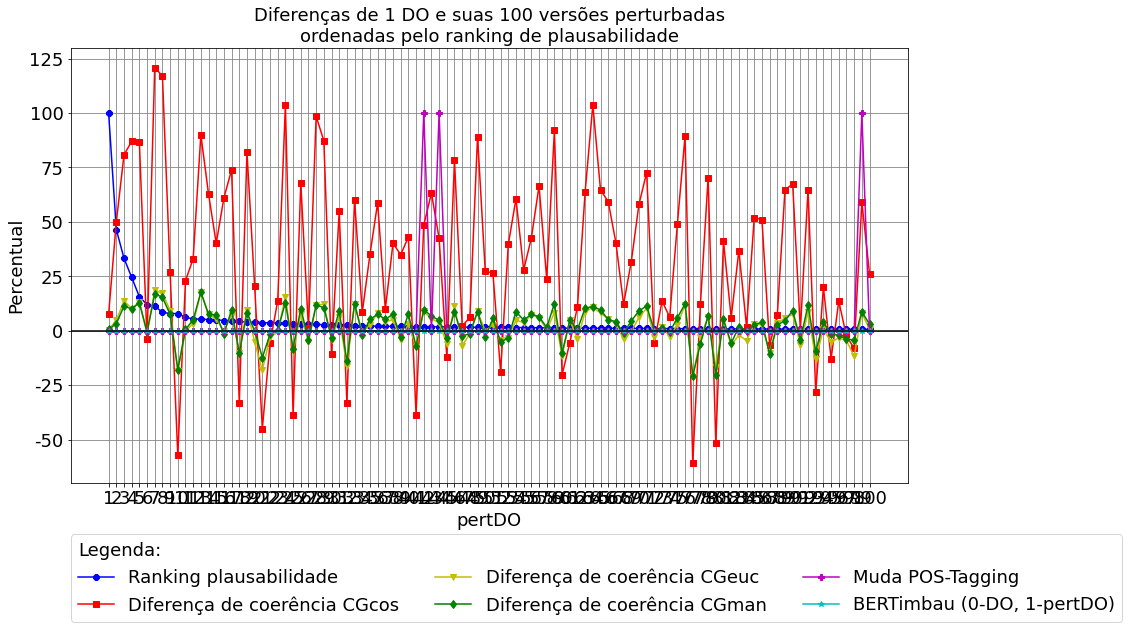

In [162]:
graficoMedidaEquacoesPerturbado(lista_perturbado_classificado_medida1,
                        id_documento,
                        legenda = ['Ranking plausabilidade',
                                   'Diferença de coerência CGcos',
                                   'Diferença de coerência CGeuc',
                                   'Diferença de coerência CGman',
                                   'Muda POS-Tagging',
                                   'BERTimbau (0-DO, 1-pertDO)'])

In [163]:
mostrarMedidasEquacaoCSV(lista_perturbado_classificado_medida1,
                         id_documento,
                         equacao_medida = equacao_medida)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226
Equação medida   : CAW - Palavras adjacentes

DO;classificacao(1-DO, 0-pertDO)
Quais órgãos centrais são comuns em universidades?;1
DET NOUN ADJ AUX ADJ ADP NOUN PUNCT 

pertDO;classificacao(1-DO,0-pertDO);palavra selecionada;classe palavra selecionada;CAWcos(selecionada,DO);CAWeuc(selecionada,DO);CAWman(selecionada,DO);palavra perturbada;classe palavra perturbada;CAWcos(perturbada, pertDO);CAWeuc(perturbada, pertDO);CAWman(perturbada, pertDO);ranking de plausabilidade;CAWdcos;CAWdeuc;CAWdman;posigual;palavra_igual
Quais problemas centrais são comuns em universidades ? ; 0 ; órgãos ; NOUN ; 0,6909447738 ; 31,9561048235 ; 1519,0649142857 ; problemas ; NOUN ; 0,6935796397 ; 31,9023181370 ; 1515,8416714286 ; 1,0000000000 ; 0,0381342474 ; 0,0016831428 ; 0,0021218599 ; 0,0000000000 ; 0,0000000000
Quais bancos centrais sã

##### Exemplo DO 2

In [164]:
id_documento = "559dc36ec1b448e1922a84a7bd14cb27"

In [165]:
visualizaMedidasEquacoes(id_documento,
                         medida = medida,
                         equacao_medida = equacao_medida,
                         estrategia_medida = estrategia_medida,
                         filtro_palavra = filtro_palavra)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226
Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


DO: Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente? - 1
     PRON VERB SCONJ DET PROPN ADV VERB ADP NOUN ADP NOUN ADP NOUN ADJ PUNCT 
  Classificações corretas (classe = predição): 99
  1 -Quem concluiu que o Brasil já contava com cursos de doutorado de qualidade suficiente ? [conta(1464,3614928571) -> contava(>1461,3740071429) - 0,0197036602] - 0 - VERB/VERB
  2 -Quem concluiu que o Brasil já contou com cursos de doutorado de qualidade suficiente ? [conta(>1464,3614928571) -> contou(1466,6052428571) - 0,0073305750] - 0 - VERB/VERB
  3 -Quem concluiu que o Brasil já está com cursos de doutorado de qualidade suficiente ? [conta(1464,3614928571) -> está(>1457,7050928571) - 0,0061225942] - 0 - VERB/AUX
  4 -Quem concluiu que o Brasil já nasce com cursos de doutorado de qualidade suficiente ? [conta(>1464,3614928571) -> nasce(1550,7577357143) - 0,0056767161] - 0 - VERB/VERB
  5 -Quem concluiu que o Brasil já conte com cursos de doutorado de qualidade s

In [166]:
lista_perturbado_classificado_medida2 = getListaMedidasEquacaoPerturbado(id_documento,
                                      equacao_medida = equacao_medida, 
                                      estrategia_medida = estrategia_medida,
                                      filtro_palavra = filtro_palavra)

Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

TERMINADO MEDIDAS PERTURBADOS: 100


DO: Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente?


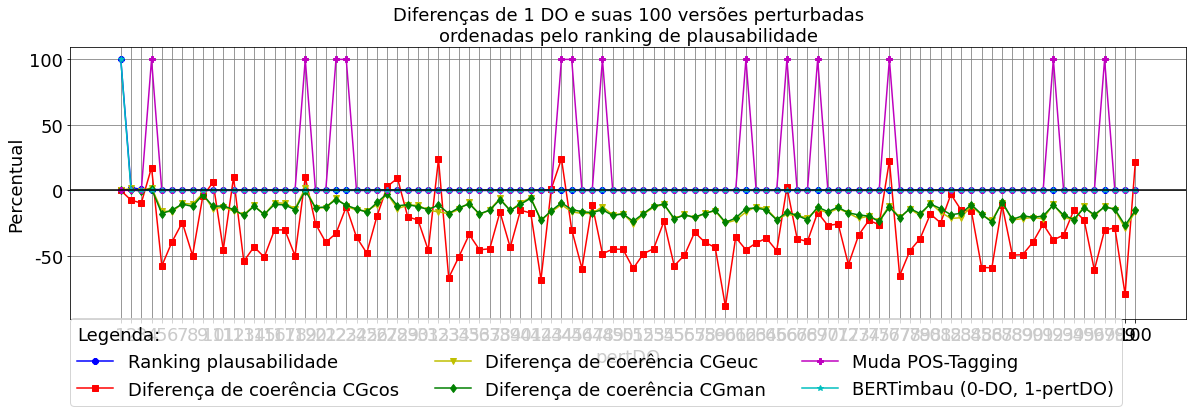

In [167]:
graficoMedidaEquacoesPerturbado(lista_perturbado_classificado_medida2,
                        id_documento,
                        legenda = ['Ranking plausabilidade',
                                       'Diferença de coerência CGcos',
                                       'Diferença de coerência CGeuc',
                                       'Diferença de coerência CGman',
                                       'Muda POS-Tagging',
                                       'BERTimbau (0-DO, 1-pertDO)'])

In [168]:
mostrarMedidasEquacaoCSV(lista_perturbado_classificado_medida1,
                         id_documento,
                         equacao_medida = equacao_medida,
                         )

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226
Equação medida   : CAW - Palavras adjacentes

DO;classificacao(1-DO, 0-pertDO)
Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente?;1
PRON VERB SCONJ DET PROPN ADV VERB ADP NOUN ADP NOUN ADP NOUN ADJ PUNCT 

pertDO;classificacao(1-DO,0-pertDO);palavra selecionada;classe palavra selecionada;CAWcos(selecionada,DO);CAWeuc(selecionada,DO);CAWman(selecionada,DO);palavra perturbada;classe palavra perturbada;CAWcos(perturbada, pertDO);CAWeuc(perturbada, pertDO);CAWman(perturbada, pertDO);ranking de plausabilidade;CAWdcos;CAWdeuc;CAWdman;posigual;palavra_igual
Documentos perturbados: 0


##### Exemplo DO 3

In [169]:
id_documento = "559dc36ec1b448e1922a84a7bd14cb27"

In [170]:
visualizaMedidasEquacoes(id_documento,
                         medida = medida,
                         equacao_medida = equacao_medida,
                         estrategia_medida = estrategia_medida,
                         filtro_palavra = filtro_palavra)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226
Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


DO: Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente? - 1
     PRON VERB SCONJ DET PROPN ADV VERB ADP NOUN ADP NOUN ADP NOUN ADJ PUNCT 
  Classificações corretas (classe = predição): 99
  1 -Quem concluiu que o Brasil já contava com cursos de doutorado de qualidade suficiente ? [conta(1464,3614928571) -> contava(>1461,3740071429) - 0,0197036602] - 0 - VERB/VERB
  2 -Quem concluiu que o Brasil já contou com cursos de doutorado de qualidade suficiente ? [conta(>1464,3614928571) -> contou(1466,6052428571) - 0,0073305750] - 0 - VERB/VERB
  3 -Quem concluiu que o Brasil já está com cursos de doutorado de qualidade suficiente ? [conta(1464,3614928571) -> está(>1457,7050928571) - 0,0061225942] - 0 - VERB/AUX
  4 -Quem concluiu que o Brasil já nasce com cursos de doutorado de qualidade suficiente ? [conta(>1464,3614928571) -> nasce(1550,7577357143) - 0,0056767161] - 0 - VERB/VERB
  5 -Quem concluiu que o Brasil já conte com cursos de doutorado de qualidade s

In [171]:
lista_perturbado_classificado_medida2 = getListaMedidasEquacaoPerturbado(id_documento,
                                      equacao_medida = equacao_medida, 
                                      estrategia_medida = estrategia_medida,
                                      filtro_palavra = filtro_palavra)

Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

TERMINADO MEDIDAS PERTURBADOS: 100


DO: Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente?


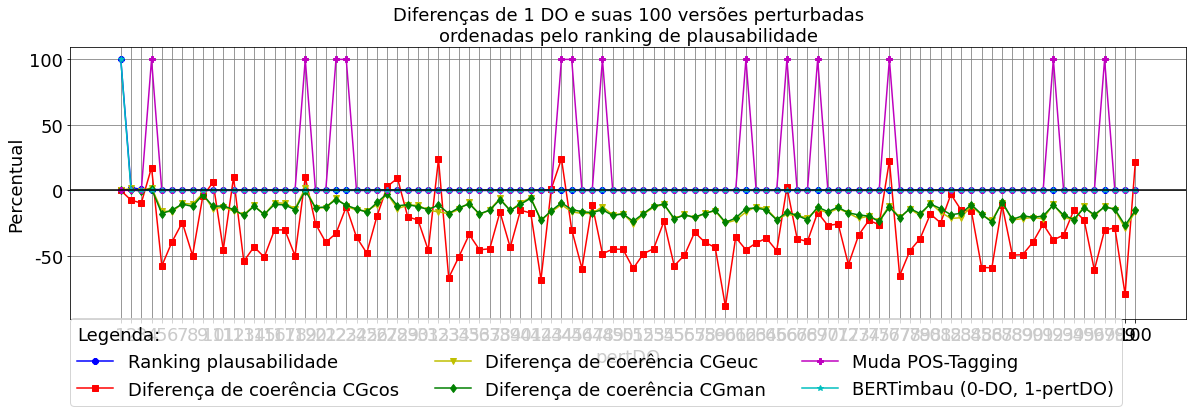

In [172]:
graficoMedidaEquacoesPerturbado(lista_perturbado_classificado_medida2,
                        id_documento,
                        legenda = ['Ranking plausabilidade',
                                       'Diferença de coerência CGcos',
                                       'Diferença de coerência CGeuc',
                                       'Diferença de coerência CGman',
                                       'Muda POS-Tagging',
                                       'BERTimbau (0-DO, 1-pertDO)'])

In [173]:
mostrarMedidasEquacaoCSV(lista_perturbado_classificado_medida1,
                         id_documento,
                         equacao_medida = equacao_medida,
                         )

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226
Equação medida   : CAW - Palavras adjacentes

DO;classificacao(1-DO, 0-pertDO)
Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente?;1
PRON VERB SCONJ DET PROPN ADV VERB ADP NOUN ADP NOUN ADP NOUN ADJ PUNCT 

pertDO;classificacao(1-DO,0-pertDO);palavra selecionada;classe palavra selecionada;CAWcos(selecionada,DO);CAWeuc(selecionada,DO);CAWman(selecionada,DO);palavra perturbada;classe palavra perturbada;CAWcos(perturbada, pertDO);CAWeuc(perturbada, pertDO);CAWman(perturbada, pertDO);ranking de plausabilidade;CAWdcos;CAWdeuc;CAWdman;posigual;palavra_igual
Documentos perturbados: 0


##### Exemplo DO 4

In [174]:
id_documento = "3f8ee2355e1f4745a10f55a9cc41396f"

In [175]:
visualizaMedidasEquacoes(id_documento,
                         medida = medida,
                         equacao_medida = equacao_medida,
                         estrategia_medida = estrategia_medida,
                         filtro_palavra = filtro_palavra)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226
Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


DO: O que é análise de sistemas? - 1
     PRON PRON AUX NOUN ADP NOUN PUNCT 
  Classificações corretas (classe = predição): 98
  1 -O que é arquitetura de sistemas ? [análise(1392,7029000000) -> arquitetura(>1381,1847333333) - 0,0858151019] - 0 - NOUN/NOUN
  2 -O que é desenvolvimento de sistemas ? [análise(1392,7029000000) -> desenvolvimento(>1340,8831333333) - 0,0687543526] - 0 - NOUN/NOUN
  3 -O que é integração de sistemas ? [análise(1392,7029000000) -> integração(>1388,5427166667) - 0,0444001667] - 0 - NOUN/NOUN
  4 -O que é gerenciamento de sistemas ? [análise(1392,7029000000) -> gerenciamento(>1366,9030666667) - 0,0255577080] - 0 - NOUN/NOUN
  5 -O que é avaliação de sistemas ? [análise(>1392,7029000000) -> avaliação(1393,9525333333) - 0,0225297045] - 0 - NOUN/NOUN
  6 -O que é gestão de sistemas ? [análise(1392,7029000000) -> gestão(>1348,9877666667) - 0,0189925488] - 0 - NOUN/NOUN
  7 -O que é segurança de sistemas ? [análise(>1392,7029000000) -> segurança(1398,5588166667) - 

In [176]:
lista_perturbado_classificado_medida2 = getListaMedidasEquacaoPerturbado(id_documento,
                                      equacao_medida = equacao_medida, 
                                      estrategia_medida = estrategia_medida,
                                      filtro_palavra = filtro_palavra)

Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

TERMINADO MEDIDAS PERTURBADOS: 100


DO: O que é análise de sistemas?


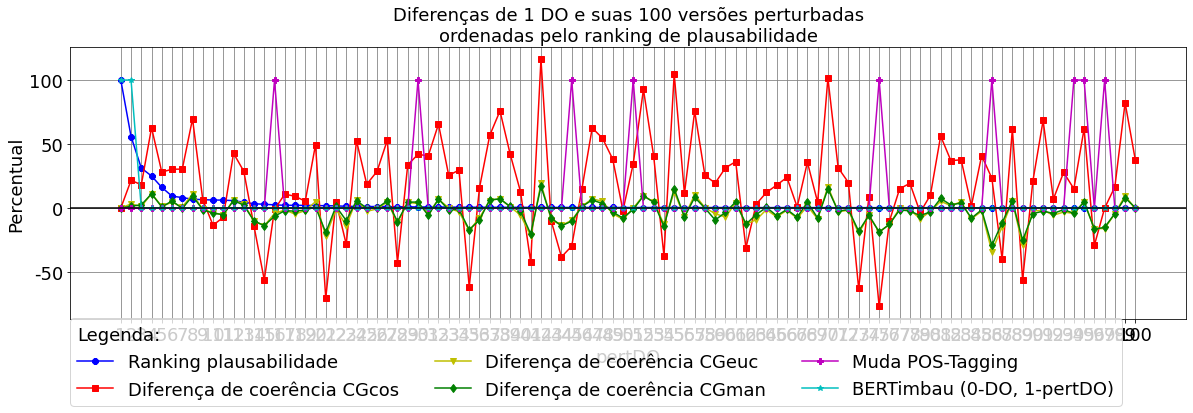

In [177]:
graficoMedidaEquacoesPerturbado(lista_perturbado_classificado_medida2,
                        id_documento,
                        legenda = ['Ranking plausabilidade',
                                       'Diferença de coerência CGcos',
                                       'Diferença de coerência CGeuc',
                                       'Diferença de coerência CGman',
                                       'Muda POS-Tagging',
                                       'BERTimbau (0-DO, 1-pertDO)'])

In [178]:
mostrarMedidasEquacaoCSV(lista_perturbado_classificado_medida1,
                         id_documento,
                         equacao_medida = equacao_medida,
                         )

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226
Equação medida   : CAW - Palavras adjacentes

DO;classificacao(1-DO, 0-pertDO)
O que é análise de sistemas?;1
PRON PRON AUX NOUN ADP NOUN PUNCT 

pertDO;classificacao(1-DO,0-pertDO);palavra selecionada;classe palavra selecionada;CAWcos(selecionada,DO);CAWeuc(selecionada,DO);CAWman(selecionada,DO);palavra perturbada;classe palavra perturbada;CAWcos(perturbada, pertDO);CAWeuc(perturbada, pertDO);CAWman(perturbada, pertDO);ranking de plausabilidade;CAWdcos;CAWdeuc;CAWdman;posigual;palavra_igual
Documentos perturbados: 0


#### Gráfico das diferenças das palavras de um DO e suas versões perturbadas classificadas com equação CG e filtros de palavras = 0 - ALL e medida = "euc"

Não calcula a medida de coerência do documento.
Compara as medidas das palavras com a medida CG( média do documento).

In [179]:
estrategia_medida = 0 # 0 - MEAN 1 - MAX
filtro_palavra = 0    # 0 - ALL, 1 - CLEAN, 2 - REL

# Medida base
medida = "euc"

##### Exemplo DO 1

In [180]:
id_documento = "483b327d3f80408fa56ffa3e3778aabf"

In [181]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


DO: Quais órgãos centrais são comuns em universidades? - 1
     DET NOUN ADJ AUX ADJ ADP NOUN PUNCT 
  Classificações corretas (classe = predição): 100
  1 -Quais problemas centrais são comuns em universidades ? [órgãos(21,3746509552) -> problemas(>19,2175884247) - 0,1822185665] - 0 - NOUN/NOUN
  2 -Quais bancos centrais são comuns em universidades ? [órgãos(21,3746509552) -> bancos(>21,2146568298) - 0,0847164765] - 0 - NOUN/NOUN
  3 -Quais temas centrais são comuns em universidades ? [órgãos(21,3746509552) -> temas(>20,3497085571) - 0,0606549233] - 0 - NOUN/NOUN
  4 -Quais ideias centrais são comuns em universidades ? [órgãos(21,3746509552) -> ideias(>19,0324840546) - 0,0446708091] - 0 - NOUN/NOUN
  5 -Quais questões centrais são comuns em universidades ? [órgãos(21,3746509552) -> questões(>18,6095314026) - 0,0284982342] - 0 - NOUN/NOUN
  6 -Quais conflitos centrais são comuns em universidades ? [órgãos(>21,3746509552) -> conflitos(21,3805637360) - 0,0219079219] - 0 - NOUN/NOUN
  7 -

In [182]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

TERMINADO MEDIDAS PERTURBADOS: 100


DO: Quais órgãos centrais são comuns em universidades?


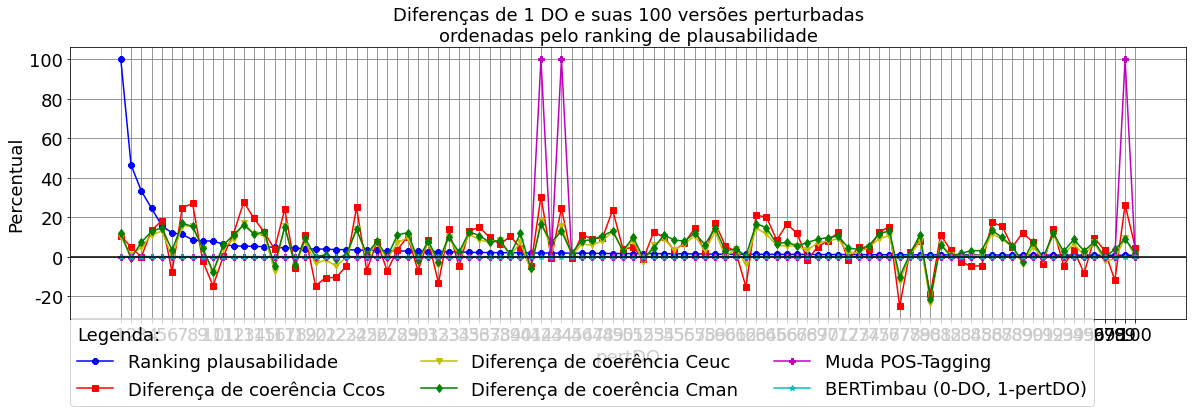

In [183]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [184]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226

DO;classificacao(1-DO, 0-pertDO)
Quais órgãos centrais são comuns em universidades?;1
DET NOUN ADJ AUX ADJ ADP NOUN PUNCT 

pertDO;classificacao(1-DO,0-pertDO);palavra selecionada;classe palavra selecionada;CGcos(selecionada,DO);CGeuc(selecionada,DO);CGman(selecionada,DO);palavra perturbada;classe palavra perturbada;CGcos(perturbada, pertDO);CGeuc(perturbada, pertDO);CGman(perturbada, pertDO);ranking de plausabilidade;dcos;deuc;dman;posigual;palavra_igual
Quais problemas centrais são comuns em universidades ? ; 0 ; órgãos ; NOUN ; 0,8387244940 ; 21,3746509552 ; 1033,0793000000 ; problemas ; NOUN ; 0,8566083312 ; 19,2175884247 ; 910,4521000000 ; 1,0000000000 ; 0,2132266001 ; 0,1009168540 ; 0,1187006651 ; 0,0000000000 ; 0,0000000000
Quais bancos centrais são comuns em universidades ? ; 0 ; órgãos ; NOUN ; 0,838724494

##### Exemplo DO 2

In [185]:
id_documento = "559dc36ec1b448e1922a84a7bd14cb27"

In [186]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


DO: Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente? - 1
     PRON VERB SCONJ DET PROPN ADV VERB ADP NOUN ADP NOUN ADP NOUN ADJ PUNCT 
  Classificações corretas (classe = predição): 99
  1 -Quem concluiu que o Brasil já contava com cursos de doutorado de qualidade suficiente ? [conta(>26,1463623047) -> contava(27,4097900391) - 0,0197036602] - 0 - VERB/VERB
  2 -Quem concluiu que o Brasil já contou com cursos de doutorado de qualidade suficiente ? [conta(>26,1463623047) -> contou(27,8706989288) - 0,0073305750] - 0 - VERB/VERB
  3 -Quem concluiu que o Brasil já está com cursos de doutorado de qualidade suficiente ? [conta(26,1463623047) -> está(>21,5494689941) - 0,0061225942] - 0 - VERB/AUX
  4 -Quem concluiu que o Brasil já nasce com cursos de doutorado de qualidade suficiente ? [conta(>26,1463623047) -> nasce(30,7898216248) - 0,0056767161] - 0 - VERB/VERB
  5 -Quem concluiu que o Brasil já conte com cursos de doutorado de qualidade suficiente ? [con

In [187]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

TERMINADO MEDIDAS PERTURBADOS: 100


DO: Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente?


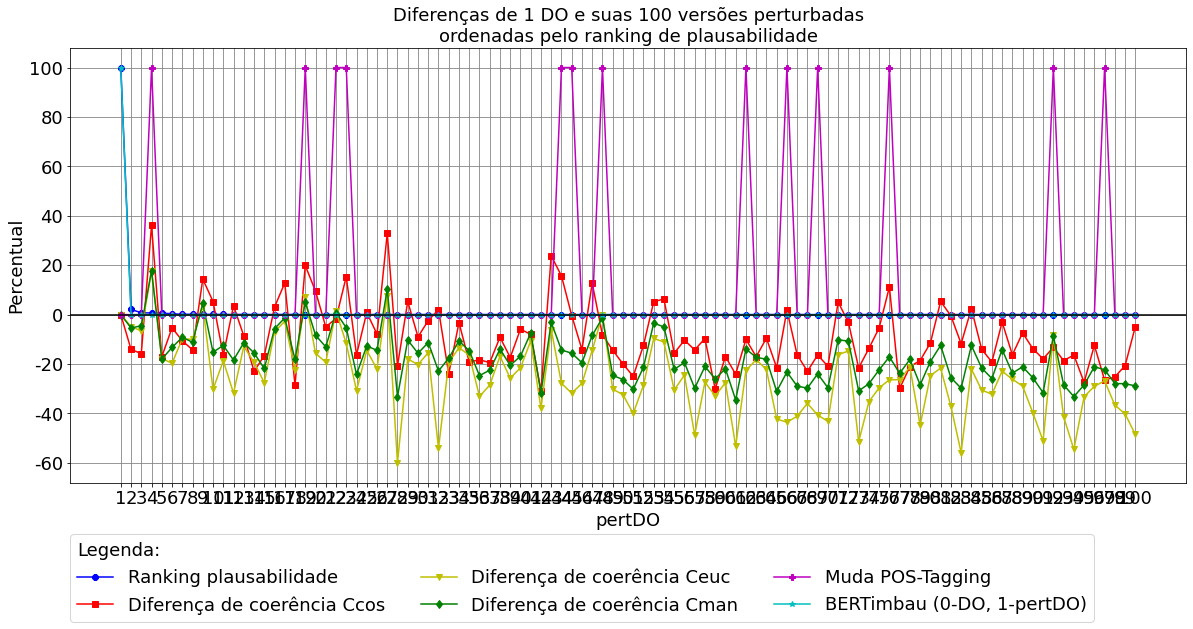

In [188]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [189]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226

DO;classificacao(1-DO, 0-pertDO)
Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente?;1
PRON VERB SCONJ DET PROPN ADV VERB ADP NOUN ADP NOUN ADP NOUN ADJ PUNCT 

pertDO;classificacao(1-DO,0-pertDO);palavra selecionada;classe palavra selecionada;CGcos(selecionada,DO);CGeuc(selecionada,DO);CGman(selecionada,DO);palavra perturbada;classe palavra perturbada;CGcos(perturbada, pertDO);CGeuc(perturbada, pertDO);CGman(perturbada, pertDO);ranking de plausabilidade;dcos;deuc;dman;posigual;palavra_igual
Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente ? ; 1 ; conta ; VERB ; 0,7798631787 ; 26,1463623047 ; 1272,8708000000 ; conta ; VERB ; 0,7798631787 ; 26,1463623047 ; 1272,8708000000 ; 1,0000000000 ; 0,0000000000 ; 0,0000000000 ; 0,0000000000 ; 0,0000000000 ; 1

##### Exemplo DO 3

In [190]:
id_documento = "559dc36ec1b448e1922a84a7bd14cb27"

In [191]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


DO: Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente? - 1
     PRON VERB SCONJ DET PROPN ADV VERB ADP NOUN ADP NOUN ADP NOUN ADJ PUNCT 
  Classificações corretas (classe = predição): 99
  1 -Quem concluiu que o Brasil já contava com cursos de doutorado de qualidade suficiente ? [conta(>26,1463623047) -> contava(27,4097900391) - 0,0197036602] - 0 - VERB/VERB
  2 -Quem concluiu que o Brasil já contou com cursos de doutorado de qualidade suficiente ? [conta(>26,1463623047) -> contou(27,8706989288) - 0,0073305750] - 0 - VERB/VERB
  3 -Quem concluiu que o Brasil já está com cursos de doutorado de qualidade suficiente ? [conta(26,1463623047) -> está(>21,5494689941) - 0,0061225942] - 0 - VERB/AUX
  4 -Quem concluiu que o Brasil já nasce com cursos de doutorado de qualidade suficiente ? [conta(>26,1463623047) -> nasce(30,7898216248) - 0,0056767161] - 0 - VERB/VERB
  5 -Quem concluiu que o Brasil já conte com cursos de doutorado de qualidade suficiente ? [con

In [192]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

TERMINADO MEDIDAS PERTURBADOS: 100


DO: Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente?


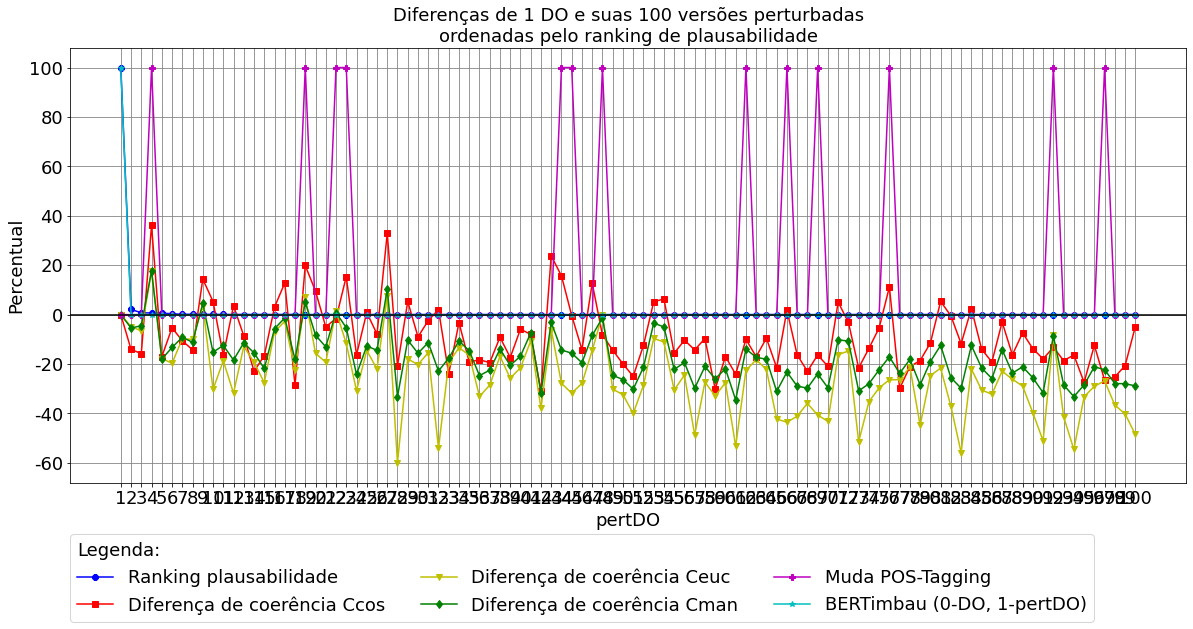

In [193]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [194]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226

DO;classificacao(1-DO, 0-pertDO)
Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente?;1
PRON VERB SCONJ DET PROPN ADV VERB ADP NOUN ADP NOUN ADP NOUN ADJ PUNCT 

pertDO;classificacao(1-DO,0-pertDO);palavra selecionada;classe palavra selecionada;CGcos(selecionada,DO);CGeuc(selecionada,DO);CGman(selecionada,DO);palavra perturbada;classe palavra perturbada;CGcos(perturbada, pertDO);CGeuc(perturbada, pertDO);CGman(perturbada, pertDO);ranking de plausabilidade;dcos;deuc;dman;posigual;palavra_igual
Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente ? ; 1 ; conta ; VERB ; 0,7798631787 ; 26,1463623047 ; 1272,8708000000 ; conta ; VERB ; 0,7798631787 ; 26,1463623047 ; 1272,8708000000 ; 1,0000000000 ; 0,0000000000 ; 0,0000000000 ; 0,0000000000 ; 0,0000000000 ; 1

##### Exemplo DO 4

In [195]:
id_documento = "3f8ee2355e1f4745a10f55a9cc41396f"

In [196]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


DO: O que é análise de sistemas? - 1
     PRON PRON AUX NOUN ADP NOUN PUNCT 
  Classificações corretas (classe = predição): 98
  1 -O que é arquitetura de sistemas ? [análise(21,4723243713) -> arquitetura(>20,3856925964) - 0,0858151019] - 0 - NOUN/NOUN
  2 -O que é desenvolvimento de sistemas ? [análise(21,4723243713) -> desenvolvimento(>20,7901248932) - 0,0687543526] - 0 - NOUN/NOUN
  3 -O que é integração de sistemas ? [análise(>21,4723243713) -> integração(22,1980762482) - 0,0444001667] - 0 - NOUN/NOUN
  4 -O que é gerenciamento de sistemas ? [análise(21,4723243713) -> gerenciamento(>21,0230960846) - 0,0255577080] - 0 - NOUN/NOUN
  5 -O que é avaliação de sistemas ? [análise(>21,4723243713) -> avaliação(21,9315109253) - 0,0225297045] - 0 - NOUN/NOUN
  6 -O que é gestão de sistemas ? [análise(21,4723243713) -> gestão(>19,8760051727) - 0,0189925488] - 0 - NOUN/NOUN
  7 -O que é segurança de sistemas ? [análise(>21,4723243713) -> segurança(22,4741153717) - 0,0180828162] - 0 - NOUN/NOU

In [197]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

TERMINADO MEDIDAS PERTURBADOS: 100


DO: O que é análise de sistemas?


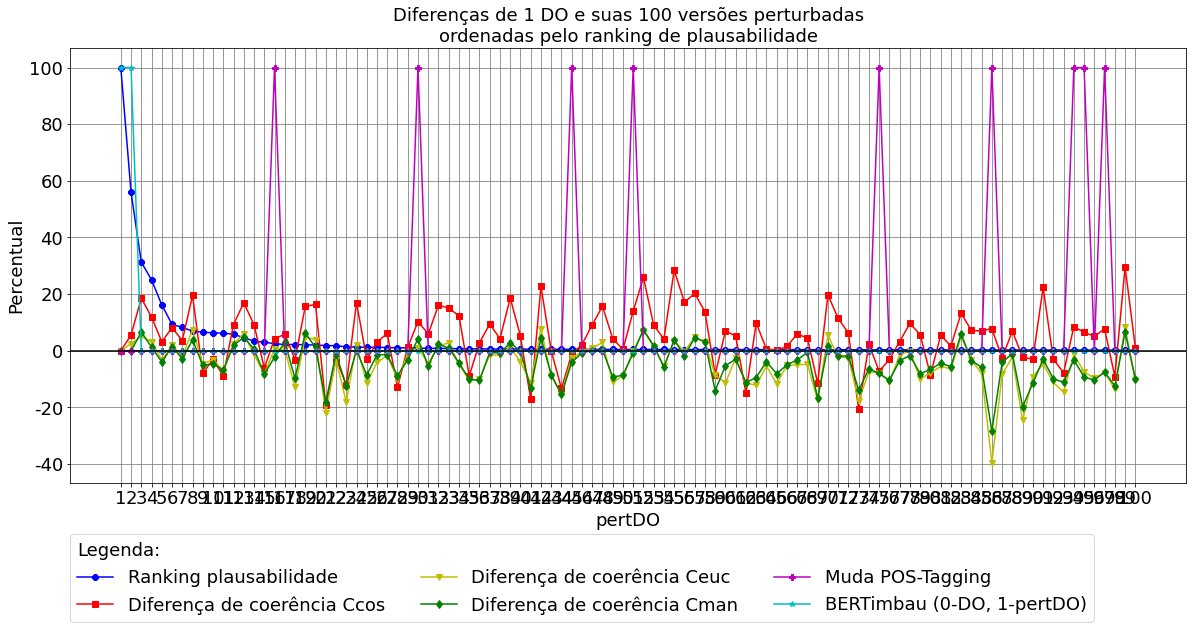

In [198]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [199]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226

DO;classificacao(1-DO, 0-pertDO)
O que é análise de sistemas?;1
PRON PRON AUX NOUN ADP NOUN PUNCT 

pertDO;classificacao(1-DO,0-pertDO);palavra selecionada;classe palavra selecionada;CGcos(selecionada,DO);CGeuc(selecionada,DO);CGman(selecionada,DO);palavra perturbada;classe palavra perturbada;CGcos(perturbada, pertDO);CGeuc(perturbada, pertDO);CGman(perturbada, pertDO);ranking de plausabilidade;dcos;deuc;dman;posigual;palavra_igual
O que é análise de sistemas ? ; 1 ; análise ; NOUN ; 0,8039947152 ; 21,4723243713 ; 1006,0637000000 ; análise ; NOUN ; 0,8039947152 ; 21,4723243713 ; 1006,0637000000 ; 1,0000000000 ; 0,0000000000 ; 0,0000000000 ; 0,0000000000 ; 0,0000000000 ; 1,0000000000
O que é engenharia de sistemas ? ; 1 ; análise ; NOUN ; 0,8039947152 ; 21,4723243713 ; 1006,0637000000 ; engenharia ; NOUN ; 0,8128837

#### Gráfico das diferenças das palavras de um DO e suas versões perturbadas classificadas com equação CG e filtros de palavras = 1 - CLEAN e medida = "euc"

Não calcula a medida de coerência do documento.
Compara as medidas das palavras com a medida CG( média do documento).

In [200]:
estrategia_medida = 0 # 0 - MEAN 1 - MAX
filtro_palavra = 1    # 0 - ALL, 1 - CLEAN, 2 - REL

# Medida base
medida = "euc"

##### Exemplo DO 1

In [201]:
id_documento = "483b327d3f80408fa56ffa3e3778aabf"

In [202]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : CLEAN - Sem as stopwords


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


DO: Quais órgãos centrais são comuns em universidades? - 1
     DET NOUN ADJ AUX ADJ ADP NOUN PUNCT 
  Classificações corretas (classe = predição): 100
  1 -Quais problemas centrais são comuns em universidades ? [órgãos(18,7977466583) -> problemas(>18,3291301727) - 0,1822185665] - 0 - NOUN/NOUN
  2 -Quais bancos centrais são comuns em universidades ? [órgãos(18,7977466583) -> bancos(>18,1466884613) - 0,0847164765] - 0 - NOUN/NOUN
  3 -Quais temas centrais são comuns em universidades ? [órgãos(>18,7977466583) -> temas(18,9113197327) - 0,0606549233] - 0 - NOUN/NOUN
  4 -Quais ideias centrais são comuns em universidades ? [órgãos(18,7977466583) -> ideias(>17,5065860748) - 0,0446708091] - 0 - NOUN/NOUN
  5 -Quais questões centrais são comuns em universidades ? [órgãos(18,7977466583) -> questões(>18,0201416016) - 0,0284982342] - 0 - NOUN/NOUN
  6 -Quais conflitos centrais são comuns em universidades ? [órgãos(>18,7977466583) -> conflitos(19,3402271271) - 0,0219079219] - 0 - NOUN/NOUN
  7 -

In [203]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

TERMINADO MEDIDAS PERTURBADOS: 100


DO: Quais órgãos centrais são comuns em universidades?


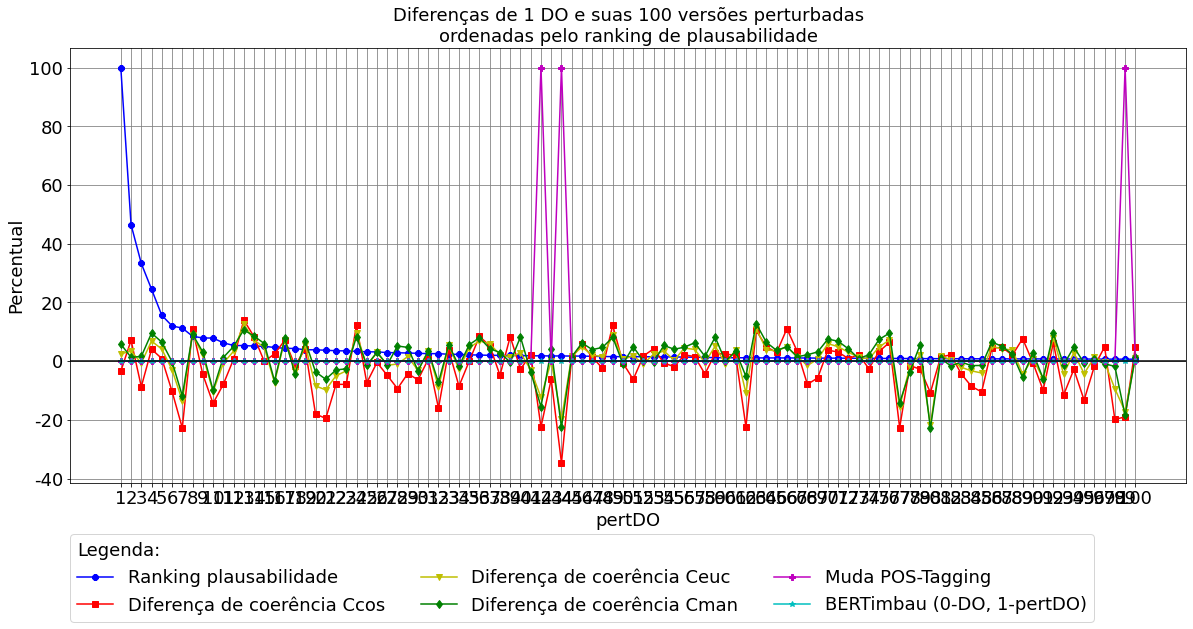

In [204]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [205]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226

DO;classificacao(1-DO, 0-pertDO)
Quais órgãos centrais são comuns em universidades?;1
DET NOUN ADJ AUX ADJ ADP NOUN PUNCT 

pertDO;classificacao(1-DO,0-pertDO);palavra selecionada;classe palavra selecionada;CGcos(selecionada,DO);CGeuc(selecionada,DO);CGman(selecionada,DO);palavra perturbada;classe palavra perturbada;CGcos(perturbada, pertDO);CGeuc(perturbada, pertDO);CGman(perturbada, pertDO);ranking de plausabilidade;dcos;deuc;dman;posigual;palavra_igual
Quais problemas centrais são comuns em universidades ? ; 0 ; órgãos ; NOUN ; 0,8779510260 ; 18,7977466583 ; 901,4778400000 ; problemas ; NOUN ; 0,8719370365 ; 18,3291301727 ; 848,8896500000 ; 1,0000000000 ; -0,0685002839 ; 0,0249293968 ; 0,0583355327 ; 0,0000000000 ; 0,0000000000
Quais bancos centrais são comuns em universidades ? ; 0 ; órgãos ; NOUN ; 0,877951026

##### Exemplo DO 2

In [206]:
id_documento = "559dc36ec1b448e1922a84a7bd14cb27"

In [207]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : CLEAN - Sem as stopwords


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


DO: Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente? - 1
     PRON VERB SCONJ DET PROPN ADV VERB ADP NOUN ADP NOUN ADP NOUN ADJ PUNCT 
  Classificações corretas (classe = predição): 99
  1 -Quem concluiu que o Brasil já contava com cursos de doutorado de qualidade suficiente ? [conta(>25,4696292877) -> contava(26,5661525726) - 0,0197036602] - 0 - VERB/VERB
  2 -Quem concluiu que o Brasil já contou com cursos de doutorado de qualidade suficiente ? [conta(>25,4696292877) -> contou(26,2802581787) - 0,0073305750] - 0 - VERB/VERB
  3 -Quem concluiu que o Brasil já está com cursos de doutorado de qualidade suficiente ? [conta(25,4696292877) -> está(>25,4529838562) - 0,0061225942] - 0 - VERB/AUX
  4 -Quem concluiu que o Brasil já nasce com cursos de doutorado de qualidade suficiente ? [conta(>25,4696292877) -> nasce(28,5730571747) - 0,0056767161] - 0 - VERB/VERB
  5 -Quem concluiu que o Brasil já conte com cursos de doutorado de qualidade suficiente ? [con

In [208]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

TERMINADO MEDIDAS PERTURBADOS: 100


DO: Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente?


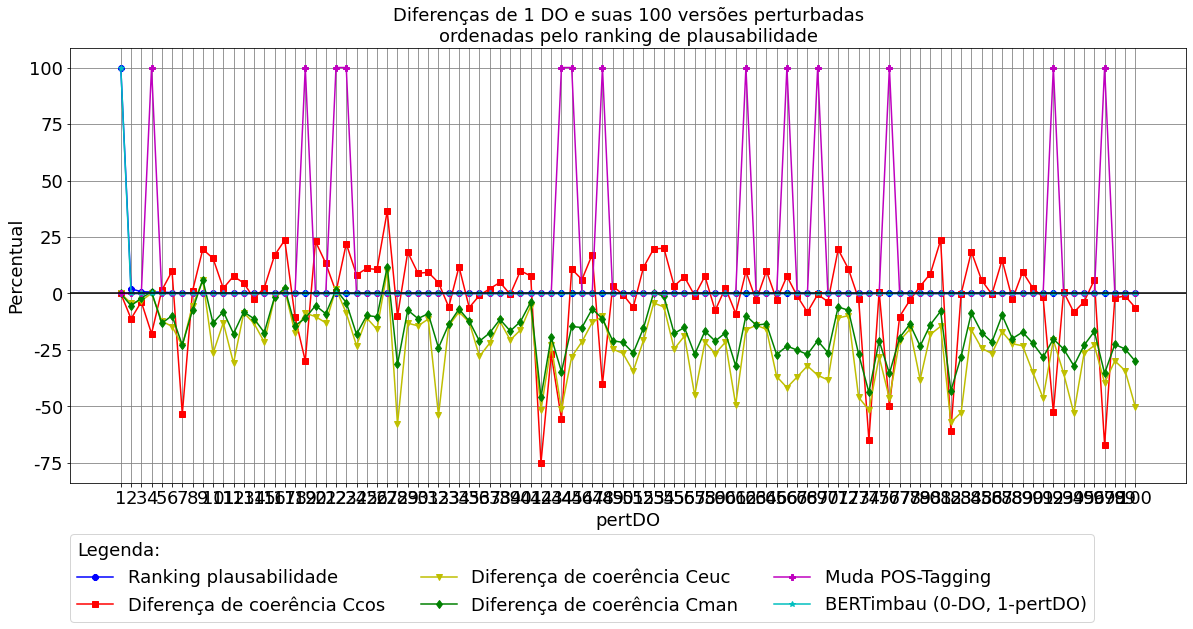

In [209]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [210]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226

DO;classificacao(1-DO, 0-pertDO)
Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente?;1
PRON VERB SCONJ DET PROPN ADV VERB ADP NOUN ADP NOUN ADP NOUN ADJ PUNCT 

pertDO;classificacao(1-DO,0-pertDO);palavra selecionada;classe palavra selecionada;CGcos(selecionada,DO);CGeuc(selecionada,DO);CGman(selecionada,DO);palavra perturbada;classe palavra perturbada;CGcos(perturbada, pertDO);CGeuc(perturbada, pertDO);CGman(perturbada, pertDO);ranking de plausabilidade;dcos;deuc;dman;posigual;palavra_igual
Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente ? ; 1 ; conta ; VERB ; 0,7924766541 ; 25,4696292877 ; 1242,2994000000 ; conta ; VERB ; 0,7924766541 ; 25,4696292877 ; 1242,2994000000 ; 1,0000000000 ; 0,0000000000 ; 0,0000000000 ; 0,0000000000 ; 0,0000000000 ; 1

##### Exemplo DO 3

In [211]:
id_documento = "559dc36ec1b448e1922a84a7bd14cb27"

In [212]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : CLEAN - Sem as stopwords


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


DO: Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente? - 1
     PRON VERB SCONJ DET PROPN ADV VERB ADP NOUN ADP NOUN ADP NOUN ADJ PUNCT 
  Classificações corretas (classe = predição): 99
  1 -Quem concluiu que o Brasil já contava com cursos de doutorado de qualidade suficiente ? [conta(>25,4696292877) -> contava(26,5661525726) - 0,0197036602] - 0 - VERB/VERB
  2 -Quem concluiu que o Brasil já contou com cursos de doutorado de qualidade suficiente ? [conta(>25,4696292877) -> contou(26,2802581787) - 0,0073305750] - 0 - VERB/VERB
  3 -Quem concluiu que o Brasil já está com cursos de doutorado de qualidade suficiente ? [conta(25,4696292877) -> está(>25,4529838562) - 0,0061225942] - 0 - VERB/AUX
  4 -Quem concluiu que o Brasil já nasce com cursos de doutorado de qualidade suficiente ? [conta(>25,4696292877) -> nasce(28,5730571747) - 0,0056767161] - 0 - VERB/VERB
  5 -Quem concluiu que o Brasil já conte com cursos de doutorado de qualidade suficiente ? [con

In [213]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

TERMINADO MEDIDAS PERTURBADOS: 100


DO: Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente?


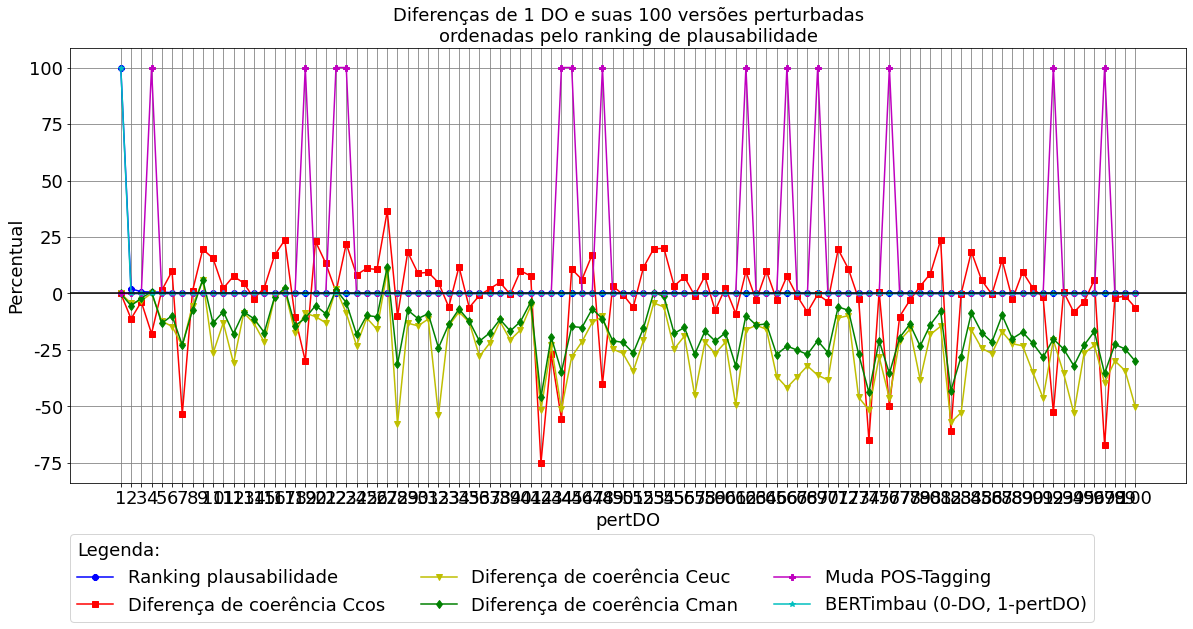

In [214]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [215]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226

DO;classificacao(1-DO, 0-pertDO)
Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente?;1
PRON VERB SCONJ DET PROPN ADV VERB ADP NOUN ADP NOUN ADP NOUN ADJ PUNCT 

pertDO;classificacao(1-DO,0-pertDO);palavra selecionada;classe palavra selecionada;CGcos(selecionada,DO);CGeuc(selecionada,DO);CGman(selecionada,DO);palavra perturbada;classe palavra perturbada;CGcos(perturbada, pertDO);CGeuc(perturbada, pertDO);CGman(perturbada, pertDO);ranking de plausabilidade;dcos;deuc;dman;posigual;palavra_igual
Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente ? ; 1 ; conta ; VERB ; 0,7924766541 ; 25,4696292877 ; 1242,2994000000 ; conta ; VERB ; 0,7924766541 ; 25,4696292877 ; 1242,2994000000 ; 1,0000000000 ; 0,0000000000 ; 0,0000000000 ; 0,0000000000 ; 0,0000000000 ; 1

##### Exemplo DO 4

In [216]:
id_documento = "3f8ee2355e1f4745a10f55a9cc41396f"

In [217]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : CLEAN - Sem as stopwords


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


DO: O que é análise de sistemas? - 1
     PRON PRON AUX NOUN ADP NOUN PUNCT 
  Classificações corretas (classe = predição): 98
  1 -O que é arquitetura de sistemas ? [análise(17,2520351410) -> arquitetura(>15,4263534546) - 0,0858151019] - 0 - NOUN/NOUN
  2 -O que é desenvolvimento de sistemas ? [análise(17,2520351410) -> desenvolvimento(>15,9777059555) - 0,0687543526] - 0 - NOUN/NOUN
  3 -O que é integração de sistemas ? [análise(17,2520351410) -> integração(>16,7743988037) - 0,0444001667] - 0 - NOUN/NOUN
  4 -O que é gerenciamento de sistemas ? [análise(17,2520351410) -> gerenciamento(>15,9063959122) - 0,0255577080] - 0 - NOUN/NOUN
  5 -O que é avaliação de sistemas ? [análise(17,2520351410) -> avaliação(>17,1119613647) - 0,0225297045] - 0 - NOUN/NOUN
  6 -O que é gestão de sistemas ? [análise(17,2520351410) -> gestão(>15,6090230942) - 0,0189925488] - 0 - NOUN/NOUN
  7 -O que é segurança de sistemas ? [análise(17,2520351410) -> segurança(>17,0399589539) - 0,0180828162] - 0 - NOUN/NOU

In [218]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

TERMINADO MEDIDAS PERTURBADOS: 100


DO: O que é análise de sistemas?


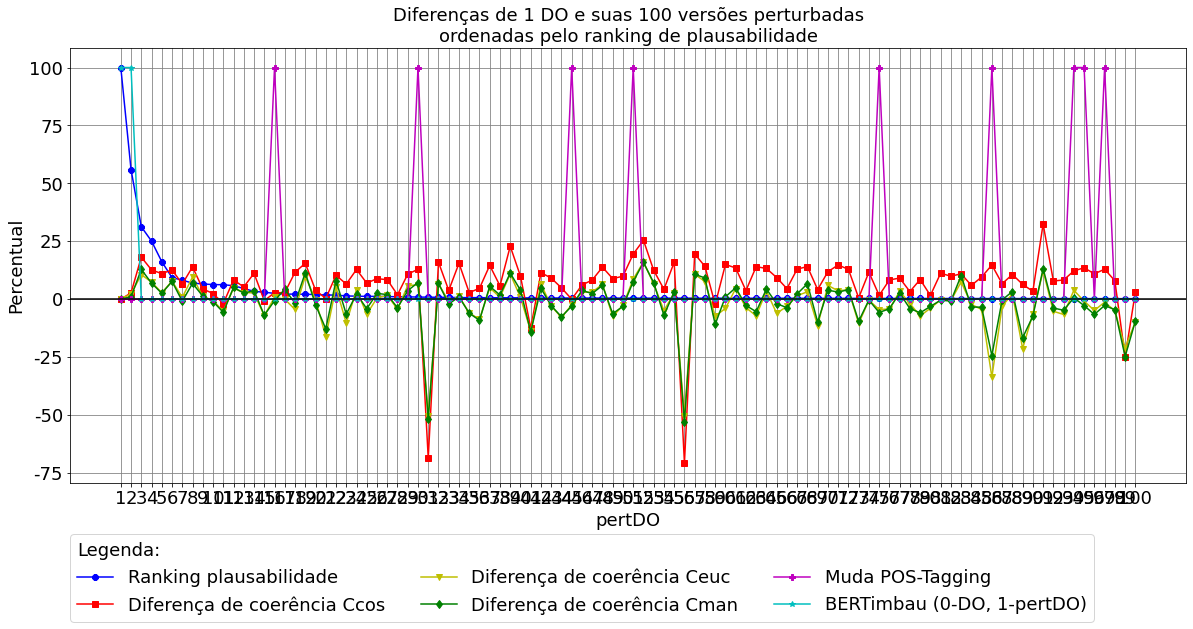

In [219]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [220]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226

DO;classificacao(1-DO, 0-pertDO)
O que é análise de sistemas?;1
PRON PRON AUX NOUN ADP NOUN PUNCT 

pertDO;classificacao(1-DO,0-pertDO);palavra selecionada;classe palavra selecionada;CGcos(selecionada,DO);CGeuc(selecionada,DO);CGman(selecionada,DO);palavra perturbada;classe palavra perturbada;CGcos(perturbada, pertDO);CGeuc(perturbada, pertDO);CGman(perturbada, pertDO);ranking de plausabilidade;dcos;deuc;dman;posigual;palavra_igual
O que é análise de sistemas ? ; 1 ; análise ; NOUN ; 0,8774151802 ; 17,2520351410 ; 825,3157000000 ; análise ; NOUN ; 0,8774151802 ; 17,2520351410 ; 825,3157000000 ; 1,0000000000 ; 0,0000000000 ; 0,0000000000 ; 0,0000000000 ; 0,0000000000 ; 1,0000000000
O que é engenharia de sistemas ? ; 1 ; análise ; NOUN ; 0,8774151802 ; 17,2520351410 ; 825,3157000000 ; engenharia ; NOUN ; 0,8821688294

#### Gráfico das diferenças das palavras de um DO e suas versões perturbadas classificadas com equação CG e filtros de palavras = 2 - REL e medida = "euc"

Não calcula a medida de coerência do documento.
Compara as medidas das palavras com a medida CG( média do documento).

In [221]:
estrategia_medida = 0 # 0 - MEAN 1 - MAX
filtro_palavra = 2    # 0 - ALL, 1 - CLEAN, 2 - REL

# Medida base
medida = "euc"

##### Exemplo DO 1

In [222]:
id_documento = "483b327d3f80408fa56ffa3e3778aabf"

In [223]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : REL - Somente verbos(aux) e substantivos


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


DO: Quais órgãos centrais são comuns em universidades? - 1
     DET NOUN ADJ AUX ADJ ADP NOUN PUNCT 
  Classificações corretas (classe = predição): 100
  1 -Quais problemas centrais são comuns em universidades ? [órgãos(17,8659000397) -> problemas(>16,0430793762) - 0,1822185665] - 0 - NOUN/NOUN
  2 -Quais bancos centrais são comuns em universidades ? [órgãos(17,8659000397) -> bancos(>17,7630767822) - 0,0847164765] - 0 - NOUN/NOUN
  3 -Quais temas centrais são comuns em universidades ? [órgãos(17,8659000397) -> temas(>16,9031200409) - 0,0606549233] - 0 - NOUN/NOUN
  4 -Quais ideias centrais são comuns em universidades ? [órgãos(17,8659000397) -> ideias(>15,4668922424) - 0,0446708091] - 0 - NOUN/NOUN
  5 -Quais questões centrais são comuns em universidades ? [órgãos(17,8659000397) -> questões(>15,5580615997) - 0,0284982342] - 0 - NOUN/NOUN
  6 -Quais conflitos centrais são comuns em universidades ? [órgãos(17,8659000397) -> conflitos(>17,5237312317) - 0,0219079219] - 0 - NOUN/NOUN
  7 -

In [224]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

TERMINADO MEDIDAS PERTURBADOS: 100


DO: Quais órgãos centrais são comuns em universidades?


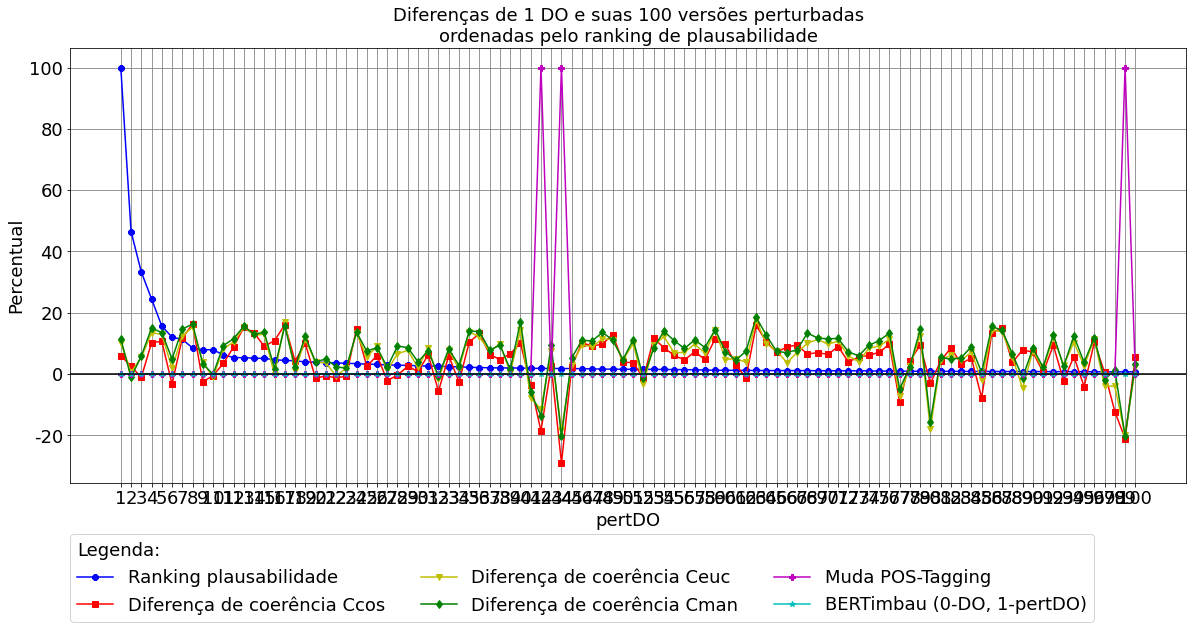

In [225]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [226]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226

DO;classificacao(1-DO, 0-pertDO)
Quais órgãos centrais são comuns em universidades?;1
DET NOUN ADJ AUX ADJ ADP NOUN PUNCT 

pertDO;classificacao(1-DO,0-pertDO);palavra selecionada;classe palavra selecionada;CGcos(selecionada,DO);CGeuc(selecionada,DO);CGman(selecionada,DO);palavra perturbada;classe palavra perturbada;CGcos(perturbada, pertDO);CGeuc(perturbada, pertDO);CGman(perturbada, pertDO);ranking de plausabilidade;dcos;deuc;dman;posigual;palavra_igual
Quais problemas centrais são comuns em universidades ? ; 0 ; órgãos ; NOUN ; 0,8905372620 ; 17,8659000397 ; 867,2429199219 ; problemas ; NOUN ; 0,9011102319 ; 16,0430793762 ; 767,7918701172 ; 1,0000000000 ; 0,1187257442 ; 0,1020279224 ; 0,1146749631 ; 0,0000000000 ; 0,0000000000
Quais bancos centrais são comuns em universidades ? ; 0 ; órgãos ; NOUN ; 0,8905372620

##### Exemplo DO 2

In [227]:
id_documento = "559dc36ec1b448e1922a84a7bd14cb27"

In [228]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : REL - Somente verbos(aux) e substantivos


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


DO: Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente? - 1
     PRON VERB SCONJ DET PROPN ADV VERB ADP NOUN ADP NOUN ADP NOUN ADJ PUNCT 
  Classificações corretas (classe = predição): 99
  1 -Quem concluiu que o Brasil já contava com cursos de doutorado de qualidade suficiente ? [conta(>25,3706760406) -> contava(26,0969390869) - 0,0197036602] - 0 - VERB/VERB
  2 -Quem concluiu que o Brasil já contou com cursos de doutorado de qualidade suficiente ? [conta(>25,3706760406) -> contou(25,4958705902) - 0,0073305750] - 0 - VERB/VERB
  3 -Quem concluiu que o Brasil já está com cursos de doutorado de qualidade suficiente ? [conta(25,3706760406) -> está(>22,9443054199) - 0,0061225942] - 0 - VERB/AUX
  4 -Quem concluiu que o Brasil já nasce com cursos de doutorado de qualidade suficiente ? [conta(>25,3706760406) -> nasce(26,9117622375) - 0,0056767161] - 0 - VERB/VERB
  5 -Quem concluiu que o Brasil já conte com cursos de doutorado de qualidade suficiente ? [con

In [229]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

TERMINADO MEDIDAS PERTURBADOS: 100


DO: Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente?


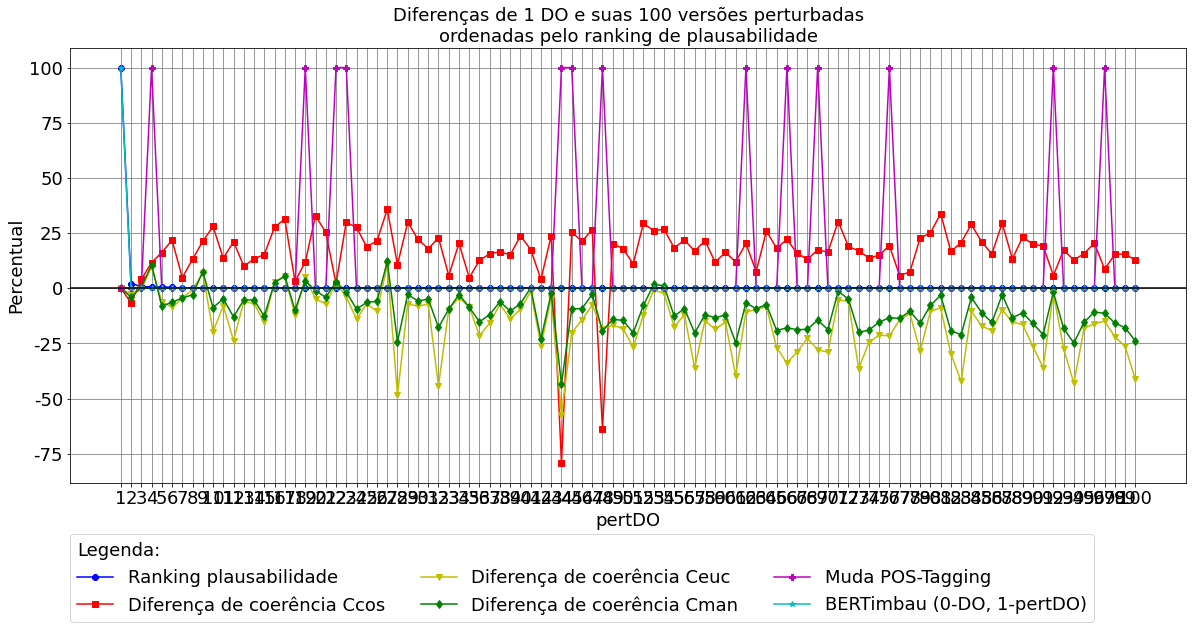

In [230]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [231]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226

DO;classificacao(1-DO, 0-pertDO)
Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente?;1
PRON VERB SCONJ DET PROPN ADV VERB ADP NOUN ADP NOUN ADP NOUN ADJ PUNCT 

pertDO;classificacao(1-DO,0-pertDO);palavra selecionada;classe palavra selecionada;CGcos(selecionada,DO);CGeuc(selecionada,DO);CGman(selecionada,DO);palavra perturbada;classe palavra perturbada;CGcos(perturbada, pertDO);CGeuc(perturbada, pertDO);CGman(perturbada, pertDO);ranking de plausabilidade;dcos;deuc;dman;posigual;palavra_igual
Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente ? ; 1 ; conta ; VERB ; 0,7940904498 ; 25,3706760406 ; 1239,5588378906 ; conta ; VERB ; 0,7940904498 ; 25,3706760406 ; 1239,5588378906 ; 1,0000000000 ; 0,0000000000 ; 0,0000000000 ; 0,0000000000 ; 0,0000000000 ; 1

##### Exemplo DO 3

In [232]:
id_documento = "559dc36ec1b448e1922a84a7bd14cb27"

In [233]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : REL - Somente verbos(aux) e substantivos


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


DO: Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente? - 1
     PRON VERB SCONJ DET PROPN ADV VERB ADP NOUN ADP NOUN ADP NOUN ADJ PUNCT 
  Classificações corretas (classe = predição): 99
  1 -Quem concluiu que o Brasil já contava com cursos de doutorado de qualidade suficiente ? [conta(>25,3706760406) -> contava(26,0969390869) - 0,0197036602] - 0 - VERB/VERB
  2 -Quem concluiu que o Brasil já contou com cursos de doutorado de qualidade suficiente ? [conta(>25,3706760406) -> contou(25,4958705902) - 0,0073305750] - 0 - VERB/VERB
  3 -Quem concluiu que o Brasil já está com cursos de doutorado de qualidade suficiente ? [conta(25,3706760406) -> está(>22,9443054199) - 0,0061225942] - 0 - VERB/AUX
  4 -Quem concluiu que o Brasil já nasce com cursos de doutorado de qualidade suficiente ? [conta(>25,3706760406) -> nasce(26,9117622375) - 0,0056767161] - 0 - VERB/VERB
  5 -Quem concluiu que o Brasil já conte com cursos de doutorado de qualidade suficiente ? [con

In [234]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

TERMINADO MEDIDAS PERTURBADOS: 100


DO: Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente?


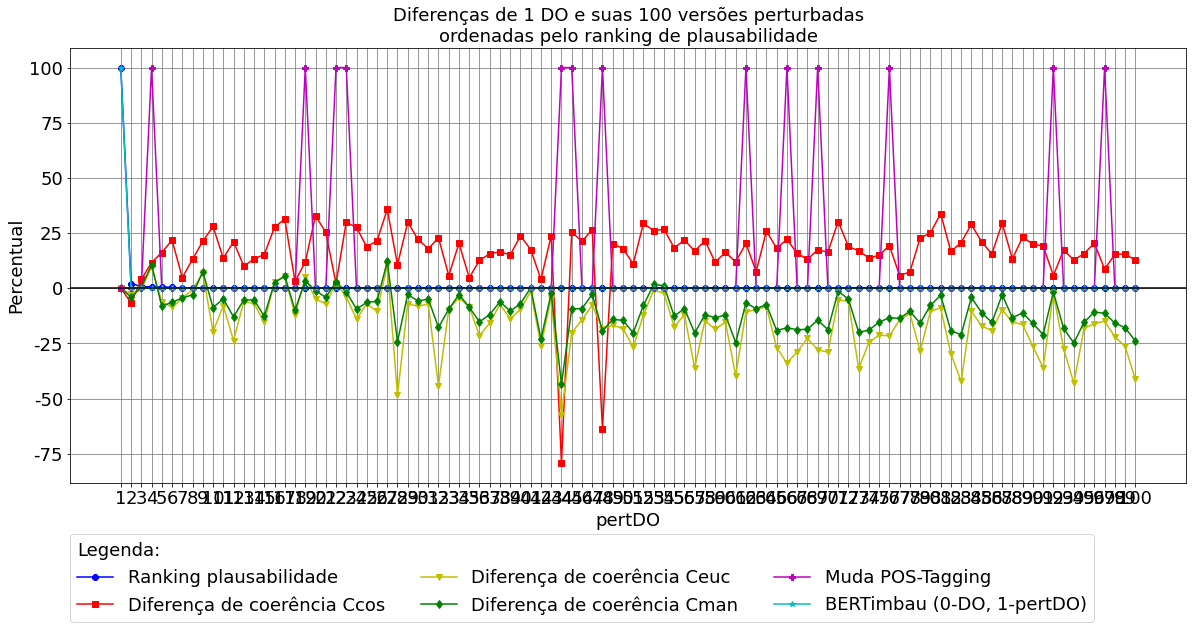

In [235]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [236]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226

DO;classificacao(1-DO, 0-pertDO)
Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente?;1
PRON VERB SCONJ DET PROPN ADV VERB ADP NOUN ADP NOUN ADP NOUN ADJ PUNCT 

pertDO;classificacao(1-DO,0-pertDO);palavra selecionada;classe palavra selecionada;CGcos(selecionada,DO);CGeuc(selecionada,DO);CGman(selecionada,DO);palavra perturbada;classe palavra perturbada;CGcos(perturbada, pertDO);CGeuc(perturbada, pertDO);CGman(perturbada, pertDO);ranking de plausabilidade;dcos;deuc;dman;posigual;palavra_igual
Quem concluiu que o Brasil já conta com cursos de doutorado de qualidade suficiente ? ; 1 ; conta ; VERB ; 0,7940904498 ; 25,3706760406 ; 1239,5588378906 ; conta ; VERB ; 0,7940904498 ; 25,3706760406 ; 1239,5588378906 ; 1,0000000000 ; 0,0000000000 ; 0,0000000000 ; 0,0000000000 ; 0,0000000000 ; 1

##### Exemplo DO 4

In [237]:
id_documento = "3f8ee2355e1f4745a10f55a9cc41396f"

In [238]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : REL - Somente verbos(aux) e substantivos


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


DO: O que é análise de sistemas? - 1
     PRON PRON AUX NOUN ADP NOUN PUNCT 
  Classificações corretas (classe = predição): 98
  1 -O que é arquitetura de sistemas ? [análise(16,5669384003) -> arquitetura(>14,8528852463) - 0,0858151019] - 0 - NOUN/NOUN
  2 -O que é desenvolvimento de sistemas ? [análise(16,5669384003) -> desenvolvimento(>15,4989595413) - 0,0687543526] - 0 - NOUN/NOUN
  3 -O que é integração de sistemas ? [análise(>16,5669384003) -> integração(16,6785392761) - 0,0444001667] - 0 - NOUN/NOUN
  4 -O que é gerenciamento de sistemas ? [análise(16,5669384003) -> gerenciamento(>15,3315410614) - 0,0255577080] - 0 - NOUN/NOUN
  5 -O que é avaliação de sistemas ? [análise(>16,5669384003) -> avaliação(16,8060512543) - 0,0225297045] - 0 - NOUN/NOUN
  6 -O que é gestão de sistemas ? [análise(16,5669384003) -> gestão(>14,5353746414) - 0,0189925488] - 0 - NOUN/NOUN
  7 -O que é segurança de sistemas ? [análise(16,5669384003) -> segurança(>16,1391048431) - 0,0180828162] - 0 - NOUN/NOU

In [239]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

TERMINADO MEDIDAS PERTURBADOS: 100


DO: O que é análise de sistemas?


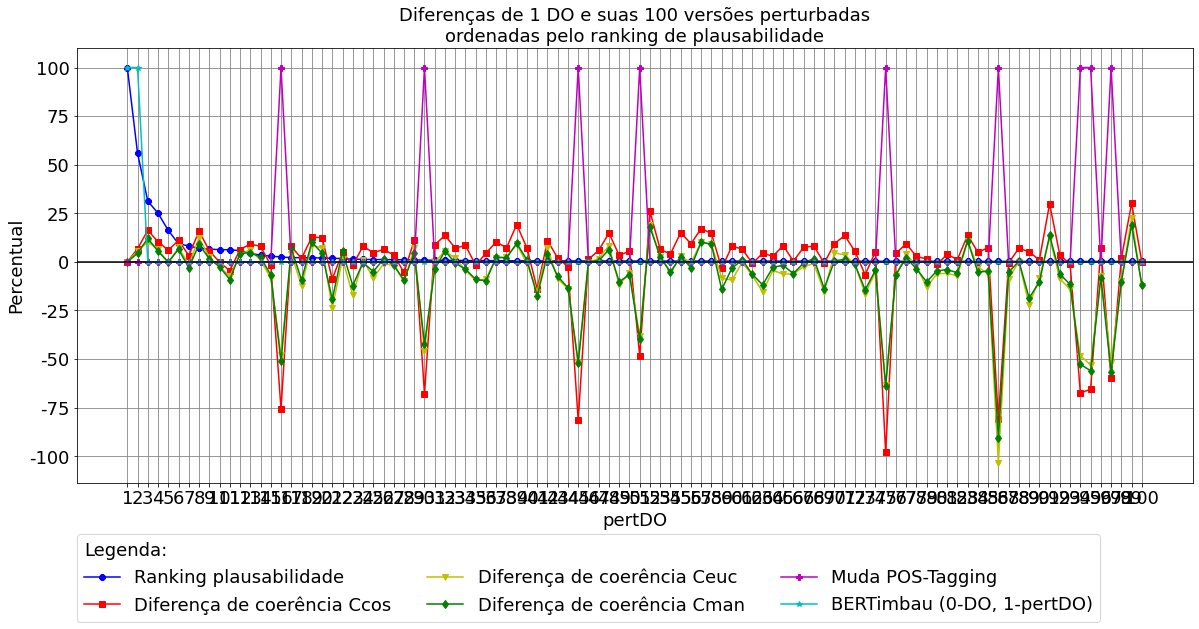

In [240]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [241]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226

DO;classificacao(1-DO, 0-pertDO)
O que é análise de sistemas?;1
PRON PRON AUX NOUN ADP NOUN PUNCT 

pertDO;classificacao(1-DO,0-pertDO);palavra selecionada;classe palavra selecionada;CGcos(selecionada,DO);CGeuc(selecionada,DO);CGman(selecionada,DO);palavra perturbada;classe palavra perturbada;CGcos(perturbada, pertDO);CGeuc(perturbada, pertDO);CGman(perturbada, pertDO);ranking de plausabilidade;dcos;deuc;dman;posigual;palavra_igual
O que é análise de sistemas ? ; 1 ; análise ; NOUN ; 0,8876600266 ; 16,5669384003 ; 778,5982055664 ; análise ; NOUN ; 0,8876600266 ; 16,5669384003 ; 778,5982055664 ; 1,0000000000 ; 0,0000000000 ; 0,0000000000 ; 0,0000000000 ; 0,0000000000 ; 1,0000000000
O que é engenharia de sistemas ? ; 1 ; análise ; NOUN ; 0,8876600266 ; 16,5669384003 ; 778,5982055664 ; engenharia ; NOUN ; 0,8996818662

#### Gera a medida de coerência CG(2) de DO e suas versões perturbadas classificads e com filtro de palavras igual a REL(2) 


In [242]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Documentos originais e perturados e suas classificações:", len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente))
print("  Classificados corretamente(classe=previsão):", len(lista_retorno_classificado_corretamente))
print("  Classificados incorretamente(classe!=previsão):", len(lista_retorno_classificado_incorretamente))

medida = 'euc'
equacao_medida = 2 # 0 - CAW, 1 - CWP, 2 - CG
estrategia_medida = 0 # 0 - MEAN 1 - MAX
filtro_palavra = 2    # 0 - ALL, 1 - CLEAN, 2 - REL

lista_perturbado_classificado_medida = []

conta_pertDO_correto = 0
conta_pertDO_incorreto = 0
conta_DO_correto = 0
conta_DO_incorreto = 0

conta_melhor_DO_correto = 0
conta_melhor_pertDO_correto = 0
conta_melhor_DO_incorreto = 0
conta_melhor_pertDO_incorreto = 0

classe_iguais_pertDO_correto = 0
classe_iguais_pertDO_incorreto = 0

pertDO_igual_DO_correto = 0
pertDO_igual_DO_incorreto = 0
pertDO_diferente_DO_correto = 0
pertDO_diferente_DO_incorreto = 0

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

# Percorre os documentos
for i, linha in lista_documentos_originais_bar:   
  # Limita a quantidade de dados a serem processados
  #if i < 2:    
    # Recupera o id do documento original
    id_documento_original = linha['id']
    
    # print("id_documento_original:",id_documento_original) 
    # Localiza os dados do documento original
    documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
    # Recupera o documento Original
    #print("documento_original:",documento_original)
    #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
    #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
    #print("documento_original_tokens:",documento_original_tokens)
    #print("len(documento_original_tokens):",len(documento_original_tokens))
    #print("documento_original_pos:",documento_original_pos)
    #print("len(documento_original_pos):",len(documento_original_pos))
    
    # Verifica se o documento original foi classificado corretamente    
    documento_id_original = id_documento_original in lista_retorno_classificado_corretamente_sem_repeticao_indexado.index
    #print("documento_id_original:", documento_id_original)

    # Recupera a classificação do original
    classe = ""
    # Se o documento original foi encontrado foi classificado corretamente    
    if documento_id_original == True:             
      documento = lista_documentos_agrupados_indexado.loc[id_documento_original]
      #print("documento:",documento)
      classe =  str(documento['classe'])
      conta_DO_correto = conta_DO_correto + 1
    else:
      classe = "0"
      conta_DO_incorreto = conta_DO_incorreto + 1

    maior_ranking = 0

    lista_perturbado_classificado = []

    # Percorre os documentos perturbados e suas classificações a partir do original
    for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

      # Id do documento perturbado
      id_perturbado = str(linha['id']) + "_pert_" + str(j)
      #id_perturbado = linha['id'] + 1
      #print("id_perturbado:",id_perturbado)

      # Localiza os dados do documento perturbado
      documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
      # Recupera o documento perturrbado
      #print("documento_perturbado:",documento_perturbado)
      #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
      #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
      #print("documento_perturbado_tokens:",documento_perturbado_tokens)
      #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
      #print("documento_perturbado_pos:",documento_perturbado_pos)
      #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

      # Recupera a sentença mascarada e seus dados do documento perturbado
      index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)

      # Encontrar o índice da palavra mascarada
      index_wi = getIndicePalavraMascarada(sentenca_mascarada)       
      
      palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
      # print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
      token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos,token_predito)
      # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

      cos_DO, euc_DO, man_DO = getMedidasCoerenciaDocumento(id_documento_original,
                                                              documento_original, 
                                                              lista_sentenca_documento_original, 
                                                              documento_original_tokens, 
                                                              documento_original_pos,
                                                              equacao_medida = equacao_medida,
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)

        #print("     DO     :", palavra_mascarada, " - ", cos_DO, euc_DO, man_DO)

      cos_pertDO, euc_pertDO, man_pertDO = getMedidasCoerenciaDocumento(id_perturbado,
                                                              documento_perturbado, 
                                                              lista_sentenca_documento_perturbado, 
                                                              documento_perturbado_tokens, 
                                                              documento_perturbado_pos,
                                                              equacao_medida = equacao_medida,
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)

      # print("    pertDO :", token_predito, " - ", cos_pertDO, euc_pertDO, man_pertDO)

      # Recupera o id documento perturbado se ele foi classificado corretamente
      documento_id_perturbado_correto = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == id_perturbado]
      #print("documento_id_perturbado_correto:",id_perturbado,documento_id_perturbado_correto)
            
      # Localiza a classificação do documento perturbado  
      classe = 1
      # Se foi encontrado foi classificado corretamente
      #if documento_id_perturbado_correto == True:
      if len(documento_id_perturbado_correto) != 0:
        classe = 0        
        documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
        conta_pertDO_correto = conta_pertDO_correto + 1
      else:
        # Recupera o id documento perturbado se ele foi classificado incorretamente        
        documento_id_perturbado_incorreto = lista_retorno_classificado_incorretamente_sem_repeticao.loc[lista_retorno_classificado_incorretamente_sem_repeticao["id"] == id_perturbado]
        
        # Se foi encontrado foi classificado incorretamente
        #if documento_id_perturbado_incorreto == True:
        if len(documento_id_perturbado_incorreto) != 0:
          conta_pertDO_incorreto = conta_pertDO_incorreto + 1
          #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))          
          documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
          #print("documento:",documento)
      
      # Guarda o maior rankin do peso
      if j == 0:
        maior_ranking = peso_predito 
      else:
        if peso_predito > maior_ranking:
           maior_ranking = peso_predito 

      # Guarda os dados
      lista_perturbado_classificado.append([str(id_documento_original) + "_pert_" + str(j), #0
                                              str(documento['documento']),            #1
                                              palavra_mascarada,                      #2
                                              palavra_mascarada_classe,               #3                                   
                                              token_predito,                          #4
                                              token_predito_classe,                   #5
                                              peso_predito,                           #6
                                              classe,                                 #7
                                              cos_DO,                                 #8
                                              euc_DO,                                 #9
                                              man_DO,                                 #10
                                              cos_pertDO,                             #11
                                              euc_pertDO,                             #12
                                              man_pertDO,                             #13
                                              ])
    
    # Cosseno
    if medida == 'cos':
      indice_palavra_selecionada = 8 # índice palavra original selecionada
      indice_palavra_substituida = 11 # índice palavra substituída
    else:
      # Euclidiana
      if medida == 'euc':
        indice_palavra_selecionada = 9 # índice palavra original selecionada
        indice_palavra_substituida = 12 # índice palavra substituída
      else:
        # Manhatan
        if medida == 'man':
          indice_palavra_selecionada = 10 # índice palavra original selecionada
          indice_palavra_substituida = 13 # índice palavra substituída

    # Calcula as medidas do documento perturbado    
    for i, x in enumerate(lista_perturbado_classificado):      
      # print("x:",x)
      ranking_percentual = x[6] / maior_ranking
      # calcula as diferenças
      if x[8] != 0:
        dcos = (x[11]-x[8])/x[8] * 10
      else:
        dcos = x[11] * 10
      if x[9] != 0:
        deuc = (x[9]-x[12])/x[9]
      else:
        deuc = -x[12]
      if x[10] != 0:
        dman = (x[10]-x[13])/x[10]
      else:
        dman = -x[13]

      # POS Tagging iguais entre selecionada e perturbada  
      pos_igual = 1
      if x[3] == x[5]:
        pos_igual = 0
        if x[7] == 0:
          classe_iguais_pertDO_correto = classe_iguais_pertDO_correto +  1
        else:
          classe_iguais_pertDO_incorreto = classe_iguais_pertDO_incorreto + 1

      # Avalia a medida para o cosseno
      if medida == 'cos':
        # Similaridade do cosseno(busca a maior distância) da palavra original e modificada(substituta) com o documento
        if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos        
          # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
          if x[7] == 0:
            conta_melhor_DO_correto = conta_melhor_DO_correto + 1
          else:  
            conta_melhor_DO_incorreto = conta_melhor_DO_incorreto + 1      
        else:
          # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
          if x[7] == 0:
            conta_melhor_pertDO_correto = conta_melhor_pertDO_correto + 1
          else:  
            conta_melhor_pertDO_incorreto = conta_melhor_pertDO_incorreto + 1      
      else:
        # distância Euclidiana(busca a menor distância) da palavra original e modificada(substituta) com o documento
        if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man        
            # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
            if x[7] == 0:
              conta_melhor_DO_correto = conta_melhor_DO_correto + 1
            else:  
              conta_melhor_DO_incorreto = conta_melhor_DO_incorreto + 1      
        else:
            # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
            if x[7] == 0:
              conta_melhor_pertDO_correto = conta_melhor_pertDO_correto + 1
            else:  
              conta_melhor_pertDO_incorreto = conta_melhor_pertDO_incorreto + 1
          
      # Verifica se as palavras são iguais
      palavra_igual = 0
      if x[2] == x[4]:
        palavra_igual = 1        
        # Classificados como incoerente
        if x[7] == 0:
          pertDO_igual_DO_correto = pertDO_igual_DO_correto + 1
        else:
          pertDO_igual_DO_incorreto = pertDO_igual_DO_incorreto + 1
      # Palavras diferentes
      else:        
        # Classificados como incoerente
        if x[7] == 0:
          pertDO_diferente_DO_correto = pertDO_diferente_DO_correto + 1
        else:
          pertDO_diferente_DO_incorreto = pertDO_diferente_DO_incorreto + 1

      lista_perturbado_classificado_medida.append([x[0],
                                                   x[1],
                                                   x[2],
                                                   x[3],
                                                   x[4],
                                                   x[5],
                                                   x[6],
                                                   x[7],
                                                   x[8],
                                                   x[9],
                                                   x[10],
                                                   x[11],
                                                   x[12],
                                                   x[13],
                                                   ranking_percentual,  #14
                                                   dcos,                #15
                                                   deuc,                #16
                                                   dman,                #17
                                                   pos_igual,           #18
                                                   palavra_igual])      #19

# Ordena a lista das medidas pela plausabilidade
lista_perturbado_classificado_medida = sorted(lista_perturbado_classificado_medida, key=lambda x: (x[2], x[6]), reverse=True)

print("TERMINADO MEDIDAS PERTURBADOS:", len(lista_perturbado_classificado_medida))

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226


Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

TERMINADO MEDIDAS PERTURBADOS: 90000


##### Geral

In [243]:
total_DO = conta_DO_correto + conta_DO_incorreto
total_pertDO = conta_pertDO_correto + conta_pertDO_incorreto

print("Documentos Originais:", total_DO)
print("Documentos originais classificados corretamente com repetição   :", len(lista_retorno_DO_correto))
print("Documentos originais classificados incorretamente com repetição :", len(lista_retorno_DO_incorreto))

print("Documentos originais classificados corretamente sem repetição   :", conta_DO_correto)
print("Documentos originais classificados incorretamente sem repetição :", conta_DO_incorreto)
print()
print("Documentos perturbados:", total_pertDO)
print("Documentos perturbados classificados corretamente               :", conta_pertDO_correto)
print("Documentos perturbados classificados incorretamente             :", conta_pertDO_incorreto)


Documentos Originais: 900
Documentos originais classificados corretamente com repetição   : 89043
Documentos originais classificados incorretamente com repetição : 957
Documentos originais classificados corretamente sem repetição   : 900
Documentos originais classificados incorretamente sem repetição : 0

Documentos perturbados: 90000
Documentos perturbados classificados corretamente               : 88731
Documentos perturbados classificados incorretamente             : 1269


##### Classe morfossintática

In [244]:
total_pertDO = conta_pertDO_correto + conta_pertDO_incorreto
total_classes_iguais = classe_iguais_pertDO_correto + classe_iguais_pertDO_incorreto

print("Documentos perturbados:", total_pertDO)
print("     classe da palavra perturbada é igual a classe da palavra em DO      :", total_classes_iguais, " / {0:.2%} do total".format(total_classes_iguais/total_pertDO))
print("     classe da palavra perturbada é diferente da classe da palavra em DO :", total_pertDO-total_classes_iguais, " / {0:.2%} do total".format((total_pertDO-total_classes_iguais)/total_pertDO))
print()
print("Documentos perturbados(pertDO) classificados corretamente                :", conta_pertDO_correto, " / {0:.2%} do total".format( conta_pertDO_correto/total_pertDO))

print("Quantidade de documentos perturbados classificados corretamente onde a ")
print("     classe da palavra perturbada é igual a classe da palavra em DO      :", classe_iguais_pertDO_correto, " / {0:.2%} do total".format( classe_iguais_pertDO_correto/conta_pertDO_correto))
print("Quantidade de documentos perturbados classificados corretamente onde a ")
print("     classe da palavra perturbada é diferente a classe da palavra em DO  :", conta_pertDO_correto-classe_iguais_pertDO_correto, " / {0:.2%} do total".format((conta_pertDO_correto-classe_iguais_pertDO_correto)/conta_pertDO_correto))
print()
print("Documentos perturbados(pertDO) classificados incorretamente              :", conta_pertDO_incorreto, " / {0:.2%} do total".format(conta_pertDO_incorreto/total_pertDO))
print("Quantidade de documentos perturbados classificados incorretamente onde a ")
if conta_pertDO_incorreto != 0:
  percentual = classe_iguais_pertDO_incorreto/conta_pertDO_incorreto
else:
  percentual = 0
print("     classe da palavra perturbada é igual a classe da palavra em DO      :", classe_iguais_pertDO_incorreto, " / {0:.2%} do total".format(percentual))
print("Quantidade de documentos perturbados classificados incorretamente onde a ")
if conta_pertDO_incorreto != 0:
  percentual = (conta_pertDO_incorreto-classe_iguais_pertDO_incorreto)/conta_pertDO_incorreto
else:
  percentual = 0
print("     classe da palavra perturbada é diferente a classe da palavra em DO  :", conta_pertDO_incorreto-classe_iguais_pertDO_incorreto, " / {0:.2%} do total".format(percentual))

Documentos perturbados: 90000
     classe da palavra perturbada é igual a classe da palavra em DO      : 71641  / 79.60% do total
     classe da palavra perturbada é diferente da classe da palavra em DO : 18359  / 20.40% do total

Documentos perturbados(pertDO) classificados corretamente                : 88731  / 98.59% do total
Quantidade de documentos perturbados classificados corretamente onde a 
     classe da palavra perturbada é igual a classe da palavra em DO      : 70429  / 79.37% do total
Quantidade de documentos perturbados classificados corretamente onde a 
     classe da palavra perturbada é diferente a classe da palavra em DO  : 18302  / 20.63% do total

Documentos perturbados(pertDO) classificados incorretamente              : 1269  / 1.41% do total
Quantidade de documentos perturbados classificados incorretamente onde a 
     classe da palavra perturbada é igual a classe da palavra em DO      : 1212  / 95.51% do total
Quantidade de documentos perturbados classificados in

##### Medida

In [245]:
total_pertDO = conta_pertDO_correto + conta_pertDO_incorreto

print("Documentos perturbados:", total_pertDO)
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
print("   maior que a medida da palavra selecionada comparada comparada os embeddings do DO :", (conta_melhor_DO_correto+conta_melhor_DO_incorreto), " / {0:.2%} do total".format((conta_melhor_DO_correto+conta_melhor_DO_incorreto)/total_pertDO))
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
print("   menor que a medida da palavra selecionada comparada comparada os embeddings do DO :", total_pertDO-(conta_melhor_DO_correto+conta_melhor_DO_incorreto), " / {0:.2%} do total".format((total_pertDO-(conta_melhor_DO_correto+conta_melhor_DO_incorreto))/total_pertDO))
print()
print("Documentos perturbados(pertDO) classificados corretamente                            :", conta_pertDO_correto, " / {0:.2%} do total".format(conta_pertDO_correto/total_pertDO))
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
print("   maior que a medida da palavra selecionada comparada comparada os embeddings do DO :", conta_melhor_DO_correto, " / {0:.2%} do total".format(conta_melhor_DO_correto/conta_pertDO_correto))
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
print("   menor que a medida da palavra selecionada comparada com os embeddings de DO       :", conta_melhor_pertDO_correto, " / {0:.2%} do total".format(conta_melhor_pertDO_correto/conta_pertDO_correto))

print()
print("Documentos perturbados(pertDO) classificados incorretamente                          :", conta_pertDO_incorreto, " / {0:.2%} do total".format(conta_pertDO_incorreto/total_pertDO))
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
if conta_pertDO_incorreto != 0:
  percentual = conta_melhor_DO_incorreto/conta_pertDO_incorreto
else:
  percentual = 0
print("   maior que a medida da palavra selecionada comparada comparada os embeddings de DO :", conta_melhor_DO_incorreto, " / {0:.2%} do total".format(percentual))
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
if conta_pertDO_incorreto != 0:
  percentual = conta_melhor_pertDO_incorreto/conta_pertDO_incorreto
else:
  percentual = 0
print("   menor que a medida da palavra selecionada comparada com os embeddings de DO    :", conta_melhor_pertDO_incorreto, " / {0:.2%} do total".format(percentual))

Documentos perturbados: 90000
A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é
   maior que a medida da palavra selecionada comparada comparada os embeddings do DO : 64222  / 71.36% do total
A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é
   menor que a medida da palavra selecionada comparada comparada os embeddings do DO : 25778  / 28.64% do total

Documentos perturbados(pertDO) classificados corretamente                            : 88731  / 98.59% do total
A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é
   maior que a medida da palavra selecionada comparada comparada os embeddings do DO : 63228  / 71.26% do total
A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é
   menor que a medida da palavra 

##### Palavra selecionada igual a perturbada

In [246]:
total_pertDO = conta_pertDO_correto + conta_pertDO_incorreto

print("Documentos perturbados:", total_pertDO)
print("     palavra perturbada é igual a palavra selecionada em DO            :", (pertDO_igual_DO_correto + pertDO_igual_DO_incorreto), " / {0:.2%} do total".format((pertDO_igual_DO_correto + pertDO_igual_DO_incorreto)/total_pertDO))
if (pertDO_igual_DO_correto + pertDO_igual_DO_incorreto) != 0:
  print("       Classificado corretamente(menos coerente)                         :", pertDO_igual_DO_correto , " / {0:.2%} do total".format((pertDO_igual_DO_correto)/(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto)))
else:
  print("       Classificado corretamente(menos coerente)                         :", pertDO_igual_DO_correto , " / 0.00% do total")  
if (pertDO_igual_DO_correto + pertDO_igual_DO_incorreto) != 0:
  print("       Classificado incorretamente(coerente)                             :", pertDO_igual_DO_incorreto, " / {0:.2%} do total".format((pertDO_igual_DO_incorreto)/(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto)))
else:  
  print("       Classificado incorretamente(coerente)                             :", pertDO_igual_DO_incorreto, " / 0.00% do total")
print("     palavra perturbada é diferente da palavra selecionada em DO       :", total_pertDO-(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto), " / {0:.2%} do total".format((total_pertDO-(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto))/total_pertDO))
print("       Classificado corretamente(menos coerente)                         :", pertDO_diferente_DO_correto , " / {0:.2%} do total".format((pertDO_diferente_DO_correto)/(total_pertDO-(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto))))
print("       Classificado incorretamente(coerente)                             :", pertDO_diferente_DO_incorreto, " / {0:.2%} do total".format((pertDO_diferente_DO_incorreto)/(total_pertDO-(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto))))
print()
print("Documentos perturbados(pertDO) classificados corretamente              :", conta_pertDO_correto, " / {0:.2%} do total".format(conta_pertDO_correto/total_pertDO))
print("Quantidade de documentos perturbados classificados corretamente onde a ")
print("     palavra perturbada é igual a palavra selecionada em DO            :", pertDO_igual_DO_correto, " / {0:.2%} do total".format((pertDO_igual_DO_correto)/conta_pertDO_correto))
print("Quantidade de documentos perturbados classificados corretamente onde a ")
print("     palavra perturbada é diferente a palavra selecionada em DO        :", conta_pertDO_correto-pertDO_igual_DO_correto, " / {0:.2%} do total".format((conta_pertDO_correto-pertDO_igual_DO_correto)/conta_pertDO_correto))

print()
print("Documentos perturbados(pertDO) classificados incorretamente            :", conta_pertDO_incorreto, " / {0:.2%} do total".format(conta_pertDO_incorreto/total_pertDO))
print("Quantidade de documentos perturbados classificados incorretamente onde a ")
print("     palavra perturbada é igual da palavra em DO                       :", pertDO_igual_DO_incorreto, " / {0:.2%} do total".format(pertDO_igual_DO_incorreto/conta_pertDO_incorreto))
print("Quantidade de documentos perturbados classificados incorretamente onde a ")
print("     palavra perturbada é diferente da palavra selecionada em DO       :", conta_pertDO_incorreto-pertDO_igual_DO_incorreto, " / {0:.2%} do total".format((conta_pertDO_incorreto-pertDO_igual_DO_incorreto)/conta_pertDO_incorreto))

Documentos perturbados: 90000
     palavra perturbada é igual a palavra selecionada em DO            : 657  / 0.73% do total
       Classificado corretamente(menos coerente)                         : 8  / 1.22% do total
       Classificado incorretamente(coerente)                             : 649  / 98.78% do total
     palavra perturbada é diferente da palavra selecionada em DO       : 89343  / 99.27% do total
       Classificado corretamente(menos coerente)                         : 88723  / 99.31% do total
       Classificado incorretamente(coerente)                             : 620  / 0.69% do total

Documentos perturbados(pertDO) classificados corretamente              : 88731  / 98.59% do total
Quantidade de documentos perturbados classificados corretamente onde a 
     palavra perturbada é igual a palavra selecionada em DO            : 8  / 0.01% do total
Quantidade de documentos perturbados classificados corretamente onde a 
     palavra perturbada é diferente a palavra selec

#### Gera a medida de distância Euclidina(euc) da palavra perturbada e a média dos embeddings do seu documento(CG) classificado com filtro de palavras igual a 0(ALL) 

In [247]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Documentos originais e perturados e suas classificações:", len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente))
print("  Classificados corretamente(classe=previsão):", len(lista_retorno_classificado_corretamente))
print("  Classificados incorretamente(classe!=previsão):", len(lista_retorno_classificado_incorretamente))

medida = 'euc'

lista_perturbado_classificado_medida = []

conta_pertDO_correto = 0
conta_pertDO_incorreto = 0
conta_DO_correto = 0
conta_DO_incorreto = 0

conta_melhor_DO_correto = 0
conta_melhor_pertDO_correto = 0
conta_melhor_DO_incorreto = 0
conta_melhor_pertDO_incorreto = 0

classe_iguais_pertDO_correto = 0
classe_iguais_pertDO_incorreto = 0

pertDO_igual_DO_correto = 0
pertDO_igual_DO_incorreto = 0
pertDO_diferente_DO_correto = 0
pertDO_diferente_DO_incorreto = 0

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

# Percorre os documentos
for i, linha in lista_documentos_originais_bar:   
  # Limita a quantidade de dados a serem processados
  #if i < 2:    
    # Recupera o id do documento original
    id_documento_original = linha['id']
    
    # print("id_documento_original:",id_documento_original) 
    # Localiza os dados do documento original
    documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
    # Recupera o documento Original
    #print("documento_original:",documento_original)
    #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
    #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
    #print("documento_original_tokens:",documento_original_tokens)
    #print("len(documento_original_tokens):",len(documento_original_tokens))
    #print("documento_original_pos:",documento_original_pos)
    #print("len(documento_original_pos):",len(documento_original_pos))
    
    # Verifica se o documento original foi classificado corretamente    
    documento_id_original = id_documento_original in lista_retorno_classificado_corretamente_sem_repeticao_indexado.index
    #print("documento_id_original:", documento_id_original)

    # Recupera a classificação do original
    classe = ""
    # Se o documento original foi encontrado foi classificado corretamente    
    if documento_id_original == True:             
      documento = lista_documentos_agrupados_indexado.loc[id_documento_original]
      #print("documento:",documento)
      classe =  str(documento['classe'])
      conta_DO_correto = conta_DO_correto + 1
    else:
      classe = "0"
      conta_DO_incorreto = conta_DO_incorreto + 1

    maior_ranking = 0

    lista_perturbado_classificado = []

    # Percorre os documentos perturbados e suas classificações a partir do original
    for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

      # Id do documento perturbado
      id_perturbado = str(linha['id']) + "_pert_" + str(j)
      #id_perturbado = linha['id'] + 1
      #print("id_perturbado:",id_perturbado)

      # Localiza os dados do documento perturbado
      documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
      # Recupera o documento perturrbado
      #print("documento_perturbado:",documento_perturbado)
      #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
      #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
      #print("documento_perturbado_tokens:",documento_perturbado_tokens)
      #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
      #print("documento_perturbado_pos:",documento_perturbado_pos)
      #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

      # Recupera a sentença mascarada e seus dados do documento perturbado
      index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)

      # Encontrar o índice da palavra mascarada
      index_wi = getIndicePalavraMascarada(sentenca_mascarada)       
      
      palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
      # print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
      token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos,token_predito)
      # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

      cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO = getMedidasComparacaoPalavrasGlobal(id_documento_original,
                                                                                       index_sentenca, 
                                                                                       index_wi,
                                                                                       0, #Estratégia 0 = MEAN
                                                                                       0) #Filtro palavra 0 = All
      #print("    Ctx DO     :", palavra_mascarada, " - ", cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO)

      cos_ctxall_pertDO, euc_ctxall_pertDO, man_ctxall_pertDO = getMedidasComparacaoPalavrasGlobal(id_perturbado,
                                                                                       index_sentenca, 
                                                                                       index_wi,
                                                                                       0, #Estratégia 0 = MEAN
                                                                                       0) #Filtro palavra 0 = All
      # print("    Ctx pertDO :", token_predito, " - ", cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO)

      # Recupera o id documento perturbado se ele foi classificado corretamente
      documento_id_perturbado_correto = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == id_perturbado]
      #print("documento_id_perturbado_correto:",id_perturbado,documento_id_perturbado_correto)
            
      # Localiza a classificação do documento perturbado  
      classe = 1
      # Se foi encontrado foi classificado corretamente
      #if documento_id_perturbado_correto == True:
      if len(documento_id_perturbado_correto) != 0:
        classe = 0        
        documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
        conta_pertDO_correto = conta_pertDO_correto + 1
      else:
        # Recupera o id documento perturbado se ele foi classificado incorretamente        
        documento_id_perturbado_incorreto = lista_retorno_classificado_incorretamente_sem_repeticao.loc[lista_retorno_classificado_incorretamente_sem_repeticao["id"] == id_perturbado]
        
        # Se foi encontrado foi classificado incorretamente
        #if documento_id_perturbado_incorreto == True:
        if len(documento_id_perturbado_incorreto) != 0:
          conta_pertDO_incorreto = conta_pertDO_incorreto + 1
          #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))          
          documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
          #print("documento:",documento)
      
      # Guarda o maior rankin do peso
      if j == 0:
        maior_ranking = peso_predito 
      else:
        if peso_predito > maior_ranking:
           maior_ranking = peso_predito 

      # Guarda os dados
      lista_perturbado_classificado.append([str(id_documento_original) + "_pert_" + str(j), #0
                                            str(documento['documento']),            #1
                                            palavra_mascarada,                      #2
                                            palavra_mascarada_classe,               #3                                   
                                            token_predito,                          #4
                                            token_predito_classe,                   #5
                                            peso_predito,                           #6
                                            classe,                                 #7
                                            cos_ctxall_DO,                          #8
                                            euc_ctxall_DO,                          #9
                                            man_ctxall_DO,                          #10
                                            cos_ctxall_pertDO,                      #11
                                            euc_ctxall_pertDO,                      #12
                                            man_ctxall_pertDO,                      #13
                                            ])
    
    # Cosseno
    if medida == 'cos':
      indice_palavra_selecionada = 8 # índice palavra original selecionada
      indice_palavra_substituida = 11 # índice palavra substituída
    else:
      # Euclidiana
      if medida == 'euc':
        indice_palavra_selecionada = 9 # índice palavra original selecionada
        indice_palavra_substituida = 12 # índice palavra substituída
      else:
        # Manhatan
        if medida == 'man':
          indice_palavra_selecionada = 10 # índice palavra original selecionada
          indice_palavra_substituida = 13 # índice palavra substituída

    # Calcula as medidas do documento perturbado    
    for i, x in enumerate(lista_perturbado_classificado):      
      # print("x:",x)
      ranking_percentual = x[6] / maior_ranking
      # calcula as diferenças
      if x[8] != 0:
        dcos = (x[11]-x[8])/x[8] * 10
      else:
        dcos = x[11] * 10
      if x[9] != 0:
        deuc = (x[9]-x[12])/x[9]
      else:
        deuc = -x[12]
      if x[10] != 0:
        dman = (x[10]-x[13])/x[10]
      else:
        dman = -x[13]
        
      # POS Tagging iguais entre selecionada e perturbada  
      pos_igual = 1
      if x[3] == x[5]:
        pos_igual = 0
        if x[7] == 0:
          classe_iguais_pertDO_correto = classe_iguais_pertDO_correto +  1
        else:
          classe_iguais_pertDO_incorreto = classe_iguais_pertDO_incorreto + 1

      # Avalia a medida para o cosseno
      if medida == 'cos':
        # Similaridade do cosseno(busca a maior distância) da palavra original e modificada(substituta) com o documento
        if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos        
          # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
          if x[7] == 0:
            conta_melhor_DO_correto = conta_melhor_DO_correto + 1
          else:  
            conta_melhor_DO_incorreto = conta_melhor_DO_incorreto + 1      
        else:
          # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
          if x[7] == 0:
            conta_melhor_pertDO_correto = conta_melhor_pertDO_correto + 1
          else:  
            conta_melhor_pertDO_incorreto = conta_melhor_pertDO_incorreto + 1      
      else:
        # distância euclidiana(busca a menor distância) da palavra original e modificada(substituta) com o documento
        if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man        
            # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
            if x[7] == 0:
              conta_melhor_DO_correto = conta_melhor_DO_correto + 1
            else:  
              conta_melhor_DO_incorreto = conta_melhor_DO_incorreto + 1      
        else:
            # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
            if x[7] == 0:
              conta_melhor_pertDO_correto = conta_melhor_pertDO_correto + 1
            else:  
              conta_melhor_pertDO_incorreto = conta_melhor_pertDO_incorreto + 1
          
      # Verifica se as palavras são iguais
      palavra_igual = 0
      if x[2] == x[4]:
        palavra_igual = 1        
        # Classificados como incoerente
        if x[7] == 0:
          pertDO_igual_DO_correto = pertDO_igual_DO_correto + 1
        else:
          pertDO_igual_DO_incorreto = pertDO_igual_DO_incorreto + 1
      # Palavras diferentes
      else:        
        # Classificados como incoerente
        if x[7] == 0:
          pertDO_diferente_DO_correto = pertDO_diferente_DO_correto + 1
        else:
          pertDO_diferente_DO_incorreto = pertDO_diferente_DO_incorreto + 1

      lista_perturbado_classificado_medida.append([x[0],
                                                   x[1],
                                                   x[2],
                                                   x[3],
                                                   x[4],
                                                   x[5],
                                                   x[6],
                                                   x[7],
                                                   x[8],
                                                   x[9],
                                                   x[10],
                                                   x[11],
                                                   x[12],
                                                   x[13],
                                                   ranking_percentual,  #14
                                                   dcos,                #15
                                                   deuc,                #16
                                                   dman,                #17
                                                   pos_igual,           #18
                                                   palavra_igual])      #19

# Ordena a lista das medidas pela plausabilidade
lista_perturbado_classificado_medida = sorted(lista_perturbado_classificado_medida, key=lambda x: (x[2], x[6]), reverse=True)

print("TERMINADO MEDIDAS PERTURBADOS:", len(lista_perturbado_classificado_medida))

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226


Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

TERMINADO MEDIDAS PERTURBADOS: 90000


##### Geral

In [248]:
total_DO = conta_DO_correto + conta_DO_incorreto
total_pertDO = conta_pertDO_correto + conta_pertDO_incorreto

print("Documentos Originais:", total_DO)
print("Documentos originais classificados corretamente com repetição   :", len(lista_retorno_DO_correto))
print("Documentos originais classificados incorretamente com repetição :", len(lista_retorno_DO_incorreto))

print("Documentos originais classificados corretamente sem repetição   :", conta_DO_correto)
print("Documentos originais classificados incorretamente sem repetição :", conta_DO_incorreto)
print()
print("Documentos perturbados:", total_pertDO)
print("Documentos perturbados classificados corretamente               :", conta_pertDO_correto)
print("Documentos perturbados classificados incorretamente             :", conta_pertDO_incorreto)


Documentos Originais: 900
Documentos originais classificados corretamente com repetição   : 89043
Documentos originais classificados incorretamente com repetição : 957
Documentos originais classificados corretamente sem repetição   : 900
Documentos originais classificados incorretamente sem repetição : 0

Documentos perturbados: 90000
Documentos perturbados classificados corretamente               : 88731
Documentos perturbados classificados incorretamente             : 1269


##### Classe morfossintática

In [249]:
total_pertDO = conta_pertDO_correto + conta_pertDO_incorreto
total_classes_iguais = classe_iguais_pertDO_correto + classe_iguais_pertDO_incorreto

print("Documentos perturbados:", total_pertDO)
print("     classe da palavra perturbada é igual a classe da palavra em DO      :", total_classes_iguais, " / {0:.2%} do total".format(total_classes_iguais/total_pertDO))
print("     classe da palavra perturbada é diferente da classe da palavra em DO :", total_pertDO-total_classes_iguais, " / {0:.2%} do total".format((total_pertDO-total_classes_iguais)/total_pertDO))
print()
print("Documentos perturbados(pertDO) classificados corretamente                :", conta_pertDO_correto, " / {0:.2%} do total".format( conta_pertDO_correto/total_pertDO))

print("Quantidade de documentos perturbados classificados corretamente onde a ")
print("     classe da palavra perturbada é igual a classe da palavra em DO      :", classe_iguais_pertDO_correto, " / {0:.2%} do total".format( classe_iguais_pertDO_correto/conta_pertDO_correto))
print("Quantidade de documentos perturbados classificados corretamente onde a ")
print("     classe da palavra perturbada é diferente a classe da palavra em DO  :", conta_pertDO_correto-classe_iguais_pertDO_correto, " / {0:.2%} do total".format((conta_pertDO_correto-classe_iguais_pertDO_correto)/conta_pertDO_correto))
print()
print("Documentos perturbados(pertDO) classificados incorretamente              :", conta_pertDO_incorreto, " / {0:.2%} do total".format(conta_pertDO_incorreto/total_pertDO))
print("Quantidade de documentos perturbados classificados incorretamente onde a ")
if conta_pertDO_incorreto != 0:
  percentual = classe_iguais_pertDO_incorreto/conta_pertDO_incorreto
else:
  percentual = 0
print("     classe da palavra perturbada é igual a classe da palavra em DO      :", classe_iguais_pertDO_incorreto, " / {0:.2%} do total".format(percentual))
print("Quantidade de documentos perturbados classificados incorretamente onde a ")
if conta_pertDO_incorreto != 0:
  percentual = (conta_pertDO_incorreto-classe_iguais_pertDO_incorreto)/conta_pertDO_incorreto
else:
  percentual = 0
print("     classe da palavra perturbada é diferente a classe da palavra em DO  :", conta_pertDO_incorreto-classe_iguais_pertDO_incorreto, " / {0:.2%} do total".format(percentual))

Documentos perturbados: 90000
     classe da palavra perturbada é igual a classe da palavra em DO      : 71641  / 79.60% do total
     classe da palavra perturbada é diferente da classe da palavra em DO : 18359  / 20.40% do total

Documentos perturbados(pertDO) classificados corretamente                : 88731  / 98.59% do total
Quantidade de documentos perturbados classificados corretamente onde a 
     classe da palavra perturbada é igual a classe da palavra em DO      : 70429  / 79.37% do total
Quantidade de documentos perturbados classificados corretamente onde a 
     classe da palavra perturbada é diferente a classe da palavra em DO  : 18302  / 20.63% do total

Documentos perturbados(pertDO) classificados incorretamente              : 1269  / 1.41% do total
Quantidade de documentos perturbados classificados incorretamente onde a 
     classe da palavra perturbada é igual a classe da palavra em DO      : 1212  / 95.51% do total
Quantidade de documentos perturbados classificados in

##### Medida

In [250]:
total_pertDO = conta_pertDO_correto + conta_pertDO_incorreto

print("Documentos perturbados:", total_pertDO)
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
print("   maior que a medida da palavra selecionada comparada comparada os embeddings do DO :", (conta_melhor_DO_correto+conta_melhor_DO_incorreto), " / {0:.2%} do total".format((conta_melhor_DO_correto+conta_melhor_DO_incorreto)/total_pertDO))
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
print("   menor que a medida da palavra selecionada comparada comparada os embeddings do DO :", total_pertDO-(conta_melhor_DO_correto+conta_melhor_DO_incorreto), " / {0:.2%} do total".format((total_pertDO-(conta_melhor_DO_correto+conta_melhor_DO_incorreto))/total_pertDO))
print()
print("Documentos perturbados(pertDO) classificados corretamente                            :", conta_pertDO_correto, " / {0:.2%} do total".format(conta_pertDO_correto/total_pertDO))
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
print("   maior que a medida da palavra selecionada comparada comparada os embeddings do DO :", conta_melhor_DO_correto, " / {0:.2%} do total".format(conta_melhor_DO_correto/conta_pertDO_correto))
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
print("   menor que a medida da palavra selecionada comparada com os embeddings de DO       :", conta_melhor_pertDO_correto, " / {0:.2%} do total".format(conta_melhor_pertDO_correto/conta_pertDO_correto))

print()
print("Documentos perturbados(pertDO) classificados incorretamente                          :", conta_pertDO_incorreto, " / {0:.2%} do total".format(conta_pertDO_incorreto/total_pertDO))
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
if conta_pertDO_incorreto != 0:
  percentual = conta_melhor_DO_incorreto/conta_pertDO_incorreto
else:
  percentual = 0
print("   maior que a medida da palavra selecionada comparada comparada os embeddings de DO :", conta_melhor_DO_incorreto, " / {0:.2%} do total".format(percentual))
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
if conta_pertDO_incorreto != 0:
  percentual = conta_melhor_pertDO_incorreto/conta_pertDO_incorreto
else:
  percentual = 0
print("   menor que a medida da palavra selecionada comparada com os embeddings de DO    :", conta_melhor_pertDO_incorreto, " / {0:.2%} do total".format(percentual))

Documentos perturbados: 90000
A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é
   maior que a medida da palavra selecionada comparada comparada os embeddings do DO : 71892  / 79.88% do total
A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é
   menor que a medida da palavra selecionada comparada comparada os embeddings do DO : 18108  / 20.12% do total

Documentos perturbados(pertDO) classificados corretamente                            : 88731  / 98.59% do total
A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é
   maior que a medida da palavra selecionada comparada comparada os embeddings do DO : 70890  / 79.89% do total
A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é
   menor que a medida da palavra 

##### Palavra selecionada igual a perturbada

In [251]:
total_pertDO = conta_pertDO_correto + conta_pertDO_incorreto

print("Documentos perturbados:", total_pertDO)
print("     palavra perturbada é igual a palavra selecionada em DO            :", (pertDO_igual_DO_correto + pertDO_igual_DO_incorreto), " / {0:.2%} do total".format((pertDO_igual_DO_correto + pertDO_igual_DO_incorreto)/total_pertDO))
if (pertDO_igual_DO_correto + pertDO_igual_DO_incorreto) != 0:
  print("       Classificado corretamente(menos coerente)                         :", pertDO_igual_DO_correto , " / {0:.2%} do total".format((pertDO_igual_DO_correto)/(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto)))
else:
  print("       Classificado corretamente(menos coerente)                         :", pertDO_igual_DO_correto , " / 0.00% do total")  
if (pertDO_igual_DO_correto + pertDO_igual_DO_incorreto) != 0:
  print("       Classificado incorretamente(coerente)                             :", pertDO_igual_DO_incorreto, " / {0:.2%} do total".format((pertDO_igual_DO_incorreto)/(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto)))
else:  
  print("       Classificado incorretamente(coerente)                             :", pertDO_igual_DO_incorreto, " / 0.00% do total")
print("     palavra perturbada é diferente da palavra selecionada em DO       :", total_pertDO-(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto), " / {0:.2%} do total".format((total_pertDO-(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto))/total_pertDO))
print("       Classificado corretamente(menos coerente)                         :", pertDO_diferente_DO_correto , " / {0:.2%} do total".format((pertDO_diferente_DO_correto)/(total_pertDO-(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto))))
print("       Classificado incorretamente(coerente)                             :", pertDO_diferente_DO_incorreto, " / {0:.2%} do total".format((pertDO_diferente_DO_incorreto)/(total_pertDO-(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto))))
print()
print("Documentos perturbados(pertDO) classificados corretamente              :", conta_pertDO_correto, " / {0:.2%} do total".format(conta_pertDO_correto/total_pertDO))
print("Quantidade de documentos perturbados classificados corretamente onde a ")
print("     palavra perturbada é igual a palavra selecionada em DO            :", pertDO_igual_DO_correto, " / {0:.2%} do total".format((pertDO_igual_DO_correto)/conta_pertDO_correto))
print("Quantidade de documentos perturbados classificados corretamente onde a ")
print("     palavra perturbada é diferente a palavra selecionada em DO        :", conta_pertDO_correto-pertDO_igual_DO_correto, " / {0:.2%} do total".format((conta_pertDO_correto-pertDO_igual_DO_correto)/conta_pertDO_correto))

print()
print("Documentos perturbados(pertDO) classificados incorretamente            :", conta_pertDO_incorreto, " / {0:.2%} do total".format(conta_pertDO_incorreto/total_pertDO))
print("Quantidade de documentos perturbados classificados incorretamente onde a ")
print("     palavra perturbada é igual da palavra em DO                       :", pertDO_igual_DO_incorreto, " / {0:.2%} do total".format(pertDO_igual_DO_incorreto/conta_pertDO_incorreto))
print("Quantidade de documentos perturbados classificados incorretamente onde a ")
print("     palavra perturbada é diferente da palavra selecionada em DO       :", conta_pertDO_incorreto-pertDO_igual_DO_incorreto, " / {0:.2%} do total".format((conta_pertDO_incorreto-pertDO_igual_DO_incorreto)/conta_pertDO_incorreto))

Documentos perturbados: 90000
     palavra perturbada é igual a palavra selecionada em DO            : 657  / 0.73% do total
       Classificado corretamente(menos coerente)                         : 8  / 1.22% do total
       Classificado incorretamente(coerente)                             : 649  / 98.78% do total
     palavra perturbada é diferente da palavra selecionada em DO       : 89343  / 99.27% do total
       Classificado corretamente(menos coerente)                         : 88723  / 99.31% do total
       Classificado incorretamente(coerente)                             : 620  / 0.69% do total

Documentos perturbados(pertDO) classificados corretamente              : 88731  / 98.59% do total
Quantidade de documentos perturbados classificados corretamente onde a 
     palavra perturbada é igual a palavra selecionada em DO            : 8  / 0.01% do total
Quantidade de documentos perturbados classificados corretamente onde a 
     palavra perturbada é diferente a palavra selec

#### Gráfico das medidas dos documentos perturbados classificados incorretamente

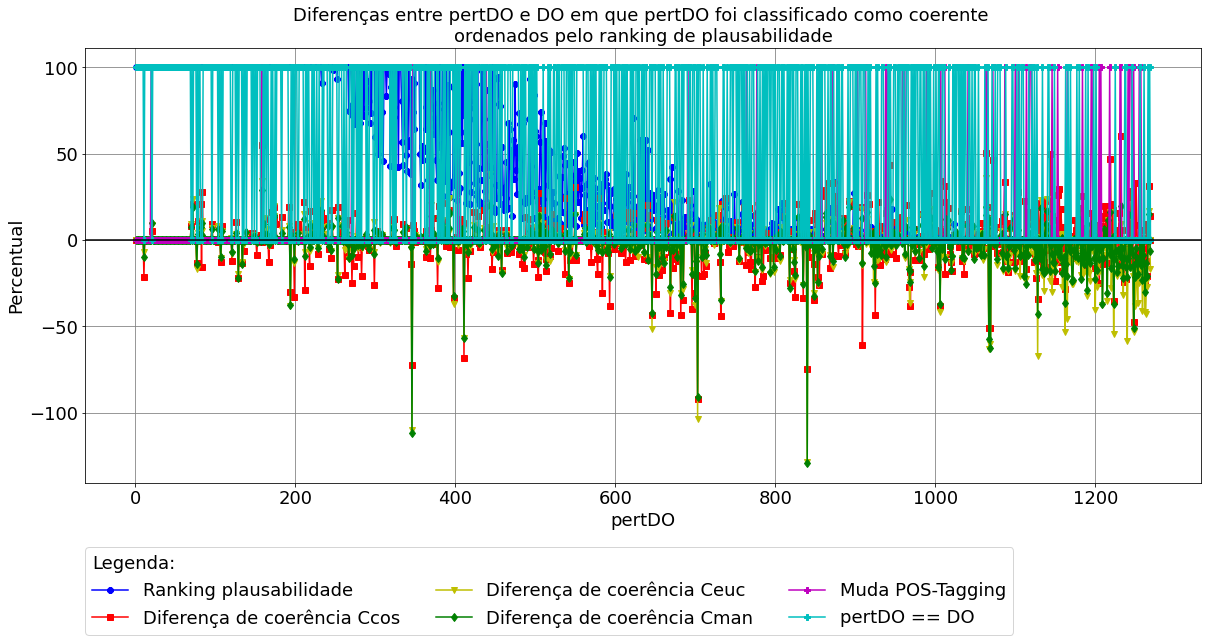

In [252]:
# Import da biblioteca
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# Dados do gráfico
lista = [x for x in lista_perturbado_classificado_medida if x[7] ==1]
lista = sorted(lista, key=lambda x: (x[6]), reverse=True)

lista_ranking = [x[14]*100 for x in lista]
lista_dcos = [x[15]*50 for x in lista]
lista_deuc = [x[16]*100 for x in lista]
lista_dman = [x[17]*100 for x in lista]
lista_pos_igual = [x[18]*100 for x in lista]
listapertDOigualDO = [x[19]*100 for x in lista]

# Eixo x e y de Pertubado
eixo_x1 = list(range(1, len(lista_ranking)+1))
eixo_y1 = lista_ranking

# Eixo x e y de Pertubado
eixo_x2 = list(range(1, len(lista_dcos)+1))
eixo_y2 = lista_dcos

# Eixo x e y de Pertubado
eixo_x3 = list(range(1, len(lista_deuc)+1))
eixo_y3 = lista_deuc

# Eixo x e y de Pertubado
eixo_x4 = list(range(1, len(lista_dman)+1))
eixo_y4 = lista_dman
  
# Eixo x e y de Pertubado
eixo_x5 = list(range(1, len(lista_pos_igual)+1))
eixo_y5 = lista_pos_igual

# Eixo x e y de Pertubado
eixo_x6 = list(range(1, len(listapertDOigualDO)+1))
eixo_y6 = listapertDOigualDO

# Título do gráfico
plt.title('Diferenças entre pertDO e DO em que pertDO foi classificado como coerente \nordenados pelo ranking de plausabilidade')
# Texto do eixo x
plt.xlabel('pertDO')
# Texto do eixo y
plt.ylabel('Percentual')

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams['figure.figsize'] = (15,8)

# Insere os dados no gráfico
plt.plot(eixo_x1, eixo_y1, 'b'+'-', marker="8", label='Ranking plausabilidade')
plt.plot(eixo_x2, eixo_y2, 'r'+'-', marker="s", label='Diferença de coerência Ccos')
plt.plot(eixo_x3, eixo_y3, 'y'+'-', marker="v", label='Diferença de coerência Ceuc')
plt.plot(eixo_x4, eixo_y4, 'g'+'-', marker="d", label='Diferença de coerência Cman')
plt.plot(eixo_x5, eixo_y5, 'm'+'-', marker="P", label='Muda POS-Tagging')
plt.plot(eixo_x6, eixo_y6, 'c'+'-', marker="P", label='pertDO == DO')

# Plota a linha do eixo y em 0
plt.axhline(y=0, color='black', linestyle='-')

# Desenha linha da grade
plt.grid(color='gray', linestyle='solid')

# Configura o eixo x e y para conter somente números inteiros
#plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
#plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

# Insere a legenda e por padrão usa o label de cada gráfico em colunas na parte inferior do gráfico
plt.legend(title='Legenda:', loc=(0.0, -0.35), ncol=3)._legend_box.align='left'

# Mostra o gráfico
plt.show()

#### Mostra os dados das medidas das perturbações em CSV para documentos perturbados classificados incorretamente

In [253]:
# Cabeçalho dos documentos perturbados    
print("pertDO;" +                                   #0
      "classificacao(1-DO,0-pertDO);" +   #1
      "palavra selecionada;" +                      #2
      "classe palavra selecionada;" +               #3
      "cos(selecionada,DO);" +                      #4
      "euc(selecionada,DO);" +                      #5
      "man(selecionada,DO);" +                      #6
      "palavra perturbada;" +                       #7
      "classe palavra perturbada;" +                #8
      "cos(perturbada, pertDO);" +                  #9
      "euc(perturbada, pertDO);" +                  #10
      "man(perturbada, pertDO);"+                   #11
      "ranking de plausabilidade;" +                #12
      "dcos;" +                                     #13
      "deuc;" +                                     #14
      "dman;" +                                     #15
      "posigual;" +                                 #16
      "palavra_igual")                              #17

# Percorre os documentos perturbados e suas classificações a partir do original
for i, x in enumerate(lista_perturbado_classificado_medida):
  if x[7] == 1: 
    print(x[1],";",               #0
          x[7],";",               #1
          x[2],";",               #2
          x[3],";",               #3
          trataNumero(x[8]),";",  #4
          trataNumero(x[9]),";",  #5
          trataNumero(x[10]),";", #6
          x[4],";",               #7
          x[5],";",               #8
          trataNumero(x[11]),";", #9
          trataNumero(x[12]),";", #10
          trataNumero(x[13]),";", #11              
          trataNumero(x[14]),";", #12              
          trataNumero(x[15]),";", #13
          trataNumero(x[16]),";", #14
          trataNumero(x[17]),";", #15
          trataNumero(x[18]),";", #16
          trataNumero(x[19])      #17
          )        

pertDO;classificacao(1-DO,0-pertDO);palavra selecionada;classe palavra selecionada;cos(selecionada,DO);euc(selecionada,DO);man(selecionada,DO);palavra perturbada;classe palavra perturbada;cos(perturbada, pertDO);euc(perturbada, pertDO);man(perturbada, pertDO);ranking de plausabilidade;dcos;deuc;dman;posigual;palavra_igual
Quem são os pioneiros da era da informação ? ; 1 ; ícones ; NOUN ; 0,8178728819 ; 23,3064212799 ; 1077,0947000000 ; pioneiros ; NOUN ; 0,8104572892 ; 23,6248779297 ; 1092,5322000000 ; 0,1385249784 ; -0,0906692572 ; -0,0136639017 ; -0,0143325373 ; 0,0000000000 ; 0,0000000000
Quem são os ícones da era da informação ? ; 1 ; ícones ; NOUN ; 0,8178728819 ; 23,3064212799 ; 1077,0947000000 ; ícones ; NOUN ; 0,8178728819 ; 23,3064212799 ; 1077,0947000000 ; 0,0505937282 ; 0,0000000000 ; 0,0000000000 ; 0,0000000000 ; 0,0000000000 ; 1,0000000000
A quem é credita a frase " Ciência é para a Ciência da Computação assim como a hidrodinâmica é para a construção de encanamentos " ? ; 

#### Visualização das medidas dos documentos perturbados

In [254]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

print("Documentos originais e perturados e suas classificações:", len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente))
print("  Classificados corretamente(classe=previsão):", len(lista_retorno_classificado_corretamente))
print("  Classificados incorretamente(classe!=previsão):", len(lista_retorno_classificado_incorretamente))

medida =  'euc'

exibir_dados = False

lista_melhor_DO_correto = []
lista_melhor_pertDO_correto = []
lista_melhor_DO_incorreto = []
lista_melhor_pertDO_incorreto = []
      
# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

# Percorre os documentos
for i, linha in lista_documentos_originais_bar:   

  # Limita a quantidade de dados a serem exibidas
  if i < 2:    
  # Procura um documento específico
  #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

    # Recupera o id do documento original
    id_documento_original = linha['id']

    # print("id_documento_original:",id_documento_original) 
    # Localiza os dados do documento original
    documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
    # Recupera o documento Original
    #print("documento_original:",documento_original)
    #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
    #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
    #print("documento_original_tokens:",documento_original_tokens)
    #print("len(documento_original_tokens):",len(documento_original_tokens))
    #print("documento_original_pos:",documento_original_pos)
    #print("len(documento_original_pos):",len(documento_original_pos))
    
    # Recupera o documento original se ele foi classificado corretamente    
    documento_id_original = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == str(linha['id'])]
    #print("documento_id_original:", documento_id_original)

    # Recupera a classificação do original
    classe = ""
    # Se o documento original foi encontrado foi classificado corretamente
    if len(documento_id_original) != 0:
      #print("documento_id_original:",len(documento_id_original))          
      documento = lista_documentos_agrupados_indexado.loc[id_documento_original]
      #print("documento:",documento)
      classe =  str(documento['classe'])      
    else:
      classe = "0"
   
    if exibir_dados == True:
      #Mostra o documento original e sua classificação
      print("\nDO: " + linha["documento"] + " - " + classe)          
      # Concatena as pos do documento
      pos_concatenado = ""
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print("    " + " " + pos_concatenado)
      
    # Lista com documentos perturbados e sua classificacao para o DO
    lista_perturbado_classificado_correto = []
    lista_perturbado_classificado_incorreto = []

    # Percorre os documentos perturbados e suas classificações a partir do original
    for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

        # Id do documento perturbado
        id_perturbado = str(linha['id']) + "_pert_" + str(j)
        #id_perturbado = linha['id'] + 1
        #print("id_perturbado:",id_perturbado)

        # Localiza os dados do documento perturbado
        documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
        # Recupera o documento perturrbado
        #print("documento_perturbado:",documento_perturbado)
        #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
        #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
        #print("documento_perturbado_tokens:",documento_perturbado_tokens)
        #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
        #print("documento_perturbado_pos:",documento_perturbado_pos)
        #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

        # Recupera a sentença mascarada e seus dados do documento perturbado
        index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)
          
        # Encontrar o índice da palavra mascarada
        index_wi = getIndicePalavraMascarada(sentenca_mascarada)

        palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
        #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
        token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
        #print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

        # Encontrar o índice da palavra mascarada
        index_wi = getIndicePalavraMascarada(sentenca_mascarada) 
        
        palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
        # print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
        token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos,token_predito)
        # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

        cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO = getMedidasComparacaoPalavrasGlobal(id_documento_original,
                                                                                       index_sentenca, 
                                                                                       index_wi,
                                                                                       0, #Estratégia 0 = MEAN
                                                                                       0) #Filtro palavra 0 = All
	
        #print("    Ctx DO     :", palavra_mascarada, " - ", cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO)
        cos_ctxall_pertDO, euc_ctxall_pertDO, man_ctxall_pertDO = getMedidasComparacaoPalavrasGlobal(id_perturbado,
                                                                                       index_sentenca, 
                                                                                       index_wi,
                                                                                       0, #Estratégia 0 = MEAN
                                                                                       0) #Filtro palavra 0 = All

        # print("    Ctx pertDO :", token_predito, " - ", cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO)

        # Recupera o id documento perturbado se ele foi classificado corretamente
        documento_id_perturbado_correto = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == id_perturbado]        
        
        # Se foi encontrado foi classificado corretamente
        if len(documento_id_perturbado_correto) != 0:
          
          versaoPerturbadaClassificada = True
          #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))                    
          documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
          #print("documento:",documento)
          lista_perturbado_classificado_correto.append([str(id_documento_original) + "_pert_" + str(j), #0
                                    str(documento['documento']),            #1
                                    palavra_mascarada,                      #2
                                    palavra_mascarada_classe,               #3                                   
                                    token_predito,                          #4
                                    token_predito_classe,                   #5
                                    peso_predito,                           #6
                                    0,                                      #7 #0 = classe documento original
                                    cos_ctxall_DO,                          #8
                                    euc_ctxall_DO,                          #9
                                    man_ctxall_DO,                          #10
                                    cos_ctxall_pertDO,                      #11
                                    euc_ctxall_pertDO,                      #12
                                    man_ctxall_pertDO,                      #13
                                    ])          

        else:
          # Recupera o id documento perturbado se ele foi classificado incorretamente
          documento_id_perturbado_incorreto = lista_retorno_classificado_incorretamente_sem_repeticao.loc[lista_retorno_classificado_incorretamente_sem_repeticao["id"] == id_perturbado]

          # Se foi encontrado foi classificado incorretamente
          if len(documento_id_perturbado_incorreto) != 0:            
            #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))          
            documento = lista_documentos_agrupados.loc[lista_documentos_agrupados["id"] == str(documento_id_perturbado_incorreto['id'].values[0])]
            #print("documento:",documento)
            lista_perturbado_classificado_incorreto.append([str(id_documento_original) + "_pert_" + str(j), #0
                                    str(documento['documento'].values[0]),  #1
                                    palavra_mascarada,                      #2
                                    palavra_mascarada_classe,               #3                                   
                                    token_predito,                          #4
                                    token_predito_classe,                   #5
                                    peso_predito,                           #6
                                    1,                                      #7 #1 = classe documento perturbado
                                    cos_ctxall_DO,                          #8
                                    euc_ctxall_DO,                          #9
                                    man_ctxall_DO,                          #10
                                    cos_ctxall_pertDO,                      #11
                                    euc_ctxall_pertDO,                      #12
                                    man_ctxall_pertDO,                      #13
                                    ])                                  
                
    # Ordena as listas
    lista_perturbado_classificado_correto = sorted(lista_perturbado_classificado_correto, key=lambda x: (x[2], x[6]), reverse=True)
    lista_perturbado_classificado_incorreto = sorted(lista_perturbado_classificado_incorreto, key=lambda x: (x[2], x[6]), reverse=True)

    # Cosseno
    if medida == 'cos':
      indice_palavra_selecionada = 8 # índice palavra original selecionada
      indice_palavra_substituida = 11 # índice palavra substiuída
    else:        
      # Euclidiana
      if medida == 'euc':
        indice_palavra_selecionada = 9 # índice palavra original selecionada
        indice_palavra_substituida = 12 # índice palavra substituída
      else:          
        # Manhatan
        if medida == 'man':
          indice_palavra_selecionada = 10 # índice palavra original selecionada
          indice_palavra_substituida = 13 # índice palavra substituída
    
    if exibir_dados == True:
      # Mostra a saída das classificações    
      print("  Classificações corretas (classe = predição): " + str(len(lista_perturbado_classificado_correto)))

    if len(lista_perturbado_classificado_correto) != 0:           
      conta_melhor_DO = 0 
      conta_melhor_pertDO = 0
      classes_iguais = 0
              
      for i, x in enumerate(lista_perturbado_classificado_correto):
        melhorDO = ">"
        melhor_pertDO = ""

        # Classes morfosintáticas iguais
        if x[3] == x[5]:
          classes_iguais = classes_iguais + 1
  
        # similaridade do cosseno euclidiana(busca a maior distância)
        if medida == 'cos':
          if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
            # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
            melhorDO = ">"
            melhor_pertDO = ""
            conta_melhor_DO = conta_melhor_DO + 1            
            linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
            lista_melhor_DO_correto.append(linha)
               
          else:
            # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
            melhorDO = ""
            melhor_pertDO = ">"
            conta_melhor_pertDO = conta_melhor_pertDO + 1
            
            linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
            lista_melhor_pertDO_correto.append(linha)
                       
        else:
          # distância euclidiana(busca a menor distância)          
          if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man  
            # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
            melhorDO = ">"
            melhor_pertDO = ""
            conta_melhor_DO = conta_melhor_DO + 1
            
            linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
            lista_melhor_DO_correto.append(linha)            
            
          else:
            # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
            melhorDO = ""
            melhor_pertDO = ">"
            conta_melhor_pertDO = conta_melhor_pertDO + 1
            linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
            lista_melhor_pertDO_correto.append(linha)
            
        if exibir_dados == True:
          linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
          print("   " + linha)
         
      if exibir_dados == True:
        print("       DO melhor      :",conta_melhor_DO, " pertDOMelhor:",conta_melhor_pertDO)
        print("       Classes iguais :",classes_iguais)

    if exibir_dados == True:
      print("  Classificações incorretas(classe != predição): " + str(len(lista_perturbado_classificado_incorreto)))
      
    if len(lista_perturbado_classificado_incorreto) != 0:           
      conta_melhor_DO = 0 
      conta_melhor_pertDO = 0
      classes_iguais = 0
        
      for i, x in enumerate(lista_perturbado_classificado_incorreto):
          melhorDO = ">"
          melhor_pertDO = ""

          # Classes morfosintáticas iguais
          if x[3] == x[5]:
            classes_iguais = classes_iguais  + 1

          #if x[indice_palavra_selecionada] < x[indice_palavra_substituida]: #cos
          if x[indice_palavra_selecionada] > x[indice_palavra_substituida]: #euc e man
            melhorDO = ""
            melhor_pertDO = ">"          
            conta_melhor_pertDO = conta_melhor_pertDO + 1
            linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
            lista_melhor_pertDO_incorreto.append(linha)
           
          else:
            conta_melhor_DO = conta_melhor_DO + 1
            linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
            lista_melhor_DO_incorreto.append(linha)
            
          if exibir_dados == True: 
            linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
            print("   " + linha)
                 
      if exibir_dados == True:  
        print("       DO melhor      :",conta_melhor_DO, " pertDOMelhor:",conta_melhor_pertDO)
        print("       Classes iguais :",classes_iguais)

Documentos originais e perturados e suas classificações: 180000
  Classificados corretamente(classe=previsão): 177774
  Classificados incorretamente(classe!=previsão): 2226


Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

In [255]:
print("Documentos perturbados(pertDO) classificados corretamente")
print("  A distância Euclidiana da palavra selecionada em DO com o seu contexto(media palavras da sentença) é melhor do que de sua versão perturbada")
print("  lista_melhor_DO_correto:",len(lista_melhor_DO_correto))
for i, x in enumerate(lista_melhor_DO_correto):
  if i < 10:
    print("     ", x)
print()

print("  A distância Euclidiana da palavra selecionada em DO com o seu contexto(media palavras da sentença) é pior do que de sua versão perturbada")
print("  lista_melhor_pertDO_correto", len(lista_melhor_pertDO_correto))
for i, x in enumerate(lista_melhor_pertDO_correto):
  #if i < 10:
    print("     ", x)
print()

print("Documentos perturbados(pertDO) classificados incorretamente")
print("  A distância Euclidiana da palavra selecionada em DO com o seu contexto(media palavras da sentença) é melhor do que de sua versão perturbada")
print("  lista_melhor_DO_incorreto:", len(lista_melhor_DO_incorreto))
for i, x in enumerate(lista_melhor_DO_incorreto):
  if i < 10:
    print("     ", x)
print()

print("  A distância Euclidiana da palavra selecionada em DO com o seu contexto(media palavras da sentença) é pior do que de sua versão perturbada")
print("  lista_melhor_pertDO_incorreto:", len(lista_melhor_pertDO_incorreto))
for i, x in enumerate(lista_melhor_pertDO_incorreto):
  if i < 10:
    print("     ", x)

Documentos perturbados(pertDO) classificados corretamente
  A distância Euclidiana da palavra selecionada em DO com o seu contexto(media palavras da sentença) é melhor do que de sua versão perturbada
  lista_melhor_DO_correto: 194
      Como poderia ser definido um sistema de informação ? [pode(>20,8696136475) -> poderia(21,9849281311) - 0,0142964069] - 0
      Como deveria ser definido um sistema de informação ? [pode(>20,8696136475) -> deveria(21,8393325806) - 0,0050744000] - 0
      Como poderá ser definido um sistema de informação ? [pode(>20,8696136475) -> poderá(22,8299312592) - 0,0017065962] - 0
      Como deverá ser definido um sistema de informação ? [pode(>20,8696136475) -> deverá(21,5879116058) - 0,0011192632] - 0
      Como costuma ser definido um sistema de informação ? [pode(>20,8696136475) -> costuma(26,0400619507) - 0,0008689259] - 0
      Como precisa ser definido um sistema de informação ? [pode(>20,8696136475) -> precisa(23,2596626282) - 0,0005275471] - 0
      Como 

#### Listas documentos originais e perturbados classificados corretamente

In [256]:
print("Documentos originais e perturbados classificados corretamente(classe=previsão):", len(lista_retorno_classificado_corretamente))
conta = 0
for i, linha in lista_retorno_classificado_corretamente.iterrows():
  conta = conta + 1
  if i < 2000:    
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]       
    if len(documento) != 0:    
      print("   ", conta, documento['documento'], documento['classe'])

Documentos originais e perturbados classificados corretamente(classe=previsão): 177774
    1 Quem coleta informações sobre os indivíduos? 1
    2 Quem forneceu informações sobre os indivíduos ? 0
    3 Quem coleta informações sobre os indivíduos? 1
    4 Quem gera informações sobre os indivíduos ? 0
    5 Quem coleta informações sobre os indivíduos? 1
    6 Quem temos informações sobre os indivíduos ? 0
    7 Quem coleta informações sobre os indivíduos? 1
    8 Quem envia informações sobre os indivíduos ? 0
    9 Quem coleta informações sobre os indivíduos? 1
    10 Quem revela informações sobre os indivíduos ? 0
    11 Quem coleta informações sobre os indivíduos? 1
    12 Quem fornecem informações sobre os indivíduos ? 0
    13 O que é CPDs? 1
    14 O que são CPDs ? 0
    15 O que é CPDs? 1
    16 O que representam CPDs ? 0
    17 Por quem foi proposta a arquitetura de von Neumann? 1
    18 Por quem foi aplicada a arquitetura de von Neumann ? 0
    19 Por quem foi proposta a arquitet

#### Listas documentos originais e perturbados classificados incorretamente

In [257]:
print("Documentos originais e perturbados classificados incorretamente(classe!=previsão):", len(lista_retorno_classificado_incorretamente))
conta = 0
for i, linha in lista_retorno_classificado_incorretamente.iterrows():
  conta = conta + 1
  if i < 2000:    
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]       
    if len(documento) != 0:    
      print("   ", conta, documento['documento'], documento['classe'])

Documentos originais e perturbados classificados incorretamente(classe!=previsão): 2226
    1 Onde estão os prazos para aproveitamento de estudos? 1
    2 Onde estão os prazos para aproveitamento de estudos? 1
    3 O que aumenta a procura por profissionais com conhecimento para desenvolver sistemas? 1
    4 O que aumenta a procura por profissionais com conhecimento para desenvolver sistemas? 1
    5 O que aumenta a procura por profissionais com conhecimento para desenvolver sistemas? 1
    6 O que aumenta a procura por profissionais com conhecimento para desenvolver sistemas? 1
    7 O que aumenta a procura por profissionais com conhecimento para desenvolver sistemas? 1
    8 O que aumenta a procura por profissionais com conhecimento para desenvolver sistemas? 1
    9 O que aumenta a procura por profissionais com conhecimento para desenvolver sistemas? 1
    10 Em que o prolog é ótimo ? 0
    11 Em que o prolog é rico ? 0
    12 Com quantos alunos a universidade de Nalanda contou ? 0


#### Listas documentos perturbados com palavra selecionada igual a perturbada

In [258]:
for i, x in enumerate(lista_perturbado_classificado_medida):
      # Verifica se as palavras são iguais
      if x[2] == x[4]:        
        print(x[0], x[1], x[7])        

44033fafb0af47a8b1ff1da0be3e5194_pert_33 Quem são os ícones da era da informação ? 1
337aebb1dbb04bf99b942db828454aeb_pert_0 A quem é credita a frase " Ciência é para a Ciência da Computação assim como a hidrodinâmica é para a construção de encanamentos " ? 1
b7a9cb53d988487b9b8826ceeb5ee00f_pert_0 O que é Siscad ? 1
19f97ef575744f09b17a7c1aafe504e8_pert_0 O que é CREA ? 1
c977613c30484a669d3a2d85f443323c_pert_0 O que é MVC ? 1
8d8bf16ed8d042179a582dde9274af6e_pert_0 O que é PBL ? 1
7bbe628a80c84b4fb95576a9dc9b181f_pert_0 O que é UFSC ? 1
5f8ad2b7d5b7488bafafa3f7c81b5c96_pert_0 O que é UFRG ? 1
6f53c28ab36c432b918f4845587e19e3_pert_0 O que é a Redecomep ? 1
bae8ccf0fd354d1ba76e238561f8893b_pert_0 O que é UNIVASF ? 1
df2911c85c8141c2b5ccd67c184b9678_pert_0 O que é CSU ? 1
9d787ca422f2409f90a1d84f7fe1c16c_pert_0 O que é EDI ? 1
65c4b8b5d7ea45cfab7a4779b3659234_pert_0 O que é Secac ? 1
c67c6a19a3234e2f8c0bd5fa49a90f32_pert_0 O que é UEFS ? 1
3aa1c995b3ab491395042fee99790236_pert_0 O que é

### Listas

#### Lista de documentos originais(1) classificados corretamente(1)

In [259]:
def listaOriginalClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []  
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 1 and linha['predicao'] == 1:
        lista_retorno.append(linha['id'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])        
  return df_lista_retorno

In [260]:
lista_documento_original_classificado_corretamente = listaOriginalClassificadoCorretamente(df_dados_classificacao)
print('lista_documento_original_classificado_corretamente:', len(lista_documento_original_classificado_corretamente))

lista_documento_original_classificado_corretamente: 89043


In [261]:
print("Lista de documentos originais classificados corretamente(coerentes)(classe=1 & previsão=1):", len(lista_documento_original_classificado_corretamente))
for i, documento in lista_documento_original_classificado_corretamente.iterrows():
    # Recupera o documento a ser exibido       
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]       
    print("  ",i, "-", documento['documento'], documento['classe'])

A saída de streaming foi truncada nas últimas 5000 linhas.
   84043 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   84044 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   84045 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   84046 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   84047 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   84048 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   84049 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   84050 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   84051 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   84052 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   84053 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   84054 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   84055 - O que a metodologi

#### Lista de documento originais(1) classificados incorretamente(0)

In [262]:
def listaOriginalClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []  
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 1 and linha['predicao'] == 0:
        lista_retorno.append(linha['id'])
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [263]:
lista_documento_original_classificado_incorretamente = listaOriginalClassificadoIncorretamente(df_dados_classificacao)

print("Lista de documentos originais classificados incorretamente:",len(lista_documento_original_classificado_incorretamente))

Lista de documentos originais classificados incorretamente: 957


In [264]:
print("Lista de documentos originais classificados incorretamente(incoerentes)(classe=1 & previsão=0):", len(lista_documento_original_classificado_incorretamente))
for i, documento in lista_documento_original_classificado_incorretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]       
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais classificados incorretamente(incoerentes)(classe=1 & previsão=0): 957
   0 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   1 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   2 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   3 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   4 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   5 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   6 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   7 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   8 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   9 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   10 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   11 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   12 - O que a metodologia da aut

#### Lista Documentos Perturbados(0) Classificados corretamente(0)

In [265]:
def listaPerturbadoClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []  
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 0 and linha['predicao'] == 0:
        lista_retorno.append(linha['id'])
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [266]:
lista_documento_perturbado_classificado_corretamente = listaPerturbadoClassificadoCorretamente(df_dados_classificacao)
print('lista_documento_perturbado_classificado_corretamente:', len(lista_documento_perturbado_classificado_corretamente))

lista_documento_perturbado_classificado_corretamente: 88731


In [267]:
print("Lista de documentos perturbados classificados corretamente(incoerentes)(classe=0 & previsão=0):", len(lista_documento_perturbado_classificado_corretamente))
for i, documento in lista_documento_perturbado_classificado_corretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]       
    print("  ",i, "-", documento['documento'], documento['classe'])

A saída de streaming foi truncada nas últimas 5000 linhas.
   83731 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   83732 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   83733 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   83734 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   83735 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   83736 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   83737 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   83738 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   83739 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   83740 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   83741 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   83742 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   83743 - O que a metodologi

#### Lista Documentos Perturbados(0) Classificados incorretamente(1)

In [268]:
def listaPerturbadoClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []  
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 0 and linha['predicao'] == 1:
        lista_retorno.append(linha['id'])
        
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [269]:
lista_documento_perturbado_classificado_incorretamente = listaPerturbadoClassificadoIncorretamente(df_dados_classificacao)
print('lista_documento_perturbado_classificado_incorretamente:', len(lista_documento_perturbado_classificado_incorretamente))

lista_documento_perturbado_classificado_incorretamente: 1269


In [270]:
print("Lista de documentos perturbados classificados incorretamente(coerente)(classe=0 & previsão=1):", len(lista_documento_perturbado_classificado_incorretamente))
for i, documento in lista_documento_perturbado_classificado_incorretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]         
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados classificados incorretamente(coerente)(classe=0 & previsão=1): 1269
   0 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   1 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   2 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   3 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   4 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   5 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   6 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   7 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   8 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   9 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   10 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   11 - O que a metodologia da auto-aprendizagem proporciona ao aluno? 1
   12 - O que a metodologia da aut

# 4 Finalização

## 4.1 Tempo final de processamento



In [271]:
 # Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print('')
print('  Tempo processamento:  {:} (h:mm:ss)'.format(tempo_total_processamento))


  Tempo processamento:  0:38:05 (h:mm:ss)
